# <font color="green"> Library Imports </font>

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import requests
import matplotlib.pyplot as plt
from math import floor



from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental

2022-06-04 23:51:41.297498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 23:51:41.297563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# <font color="green"> Helper functions </font>

In [2]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive

<font color='red'><b>Estabelecendo as terminologias:</b></font>



<font><b>Gross revenue</b></font> -> receita bruta (https://bugg.com.br/buggpedia-o-que-e-a-receita-bruta-gross-revenue/). Equivalente ao faturamento (http://bitly.ws/rUMX).

<i>"Gross revenue, also known as gross income, is the sum of all money generated by a business, without taking into account any part of that total that has been or will be used for expenses. As such, gross revenue includes not just money made from the sale of goods and services but also from interest, sale of shares, exchange rates and sales of property and equipment."</i> (https://www.techtarget.com/whatis/definition/gross-revenue)

<b>net revenue</b> -> receita líquida .

<i>'the amount of money received from selling goods or services after all costs have been paid'</i> (https://dictionary.cambridge.org/pt/dicionario/ingles/net-revenue)

<b>ticket médio</b> -><i>"O ticket médio é um indicador de desempenho essencial que fornece o valor médio de vendas por cliente. Para calcular o ticket médio, basta dividir o faturamento total pelo número de vendas do período.Também é possível calcular o ticket médio de determinado produto, serviço ou categoria, conforme a necessidade da empresa."</i> (http://bitly.ws/rUMw)

<i>"Average ticket is a metric that provides details on the average amount of sales per customer. Statistically, the average ticket is computed as the mean size and is calculated by adding total sales over a specified period of time and dividing by the number of customers."</i>(http://bitly.ws/rUNW)

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking - previous </font>

In [3]:
# Data loading

df = pd.read_csv('data.csv')

df.head()

,Unnamed: 0,Unnamed: 0.1,customer_id,customer_acquisition_channel,year,net_revenue,gross_revenue,boxes,Unnamed: 7
0,0,206461;Paid Marketing;2014;W09;71;71;2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,462640;Paid Marketing;2015;W25;28;56;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,666461;Referral;2015;W50;40;40;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,183202;Referral;2013;W42;18;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,410993;Referral;2014;W29;0;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 9


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'customer_id',
       'customer_acquisition_channel', 'year', 'net_revenue', 'gross_revenue',
       'boxes', 'Unnamed: 7'],
      dtype='object')

In [6]:
# Droping first column

df = df[['Unnamed: 0.1', 'customer_id', 'customer_acquisition_channel',
         'year', 'net_revenue', 'gross_revenue', 'boxes', 'Unnamed: 7']]

In [7]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                     0
customer_id                     61
customer_acquisition_channel    61
year                            61
net_revenue                     61
gross_revenue                   61
boxes                           61
Unnamed: 7                      61
dtype: int64

In [8]:
# Filling NA's

for i in df[df['customer_id'].isna() & df['customer_acquisition_channel'].isna() & df['year'].isna()
          & df['net_revenue'].isna() & df['gross_revenue'].isna() & df['boxes'].isna() & df['Unnamed: 7'].isna()].index:
    
    
    df.loc[i, 'customer_id'] = df['Unnamed: 0.1'][i].split(';')[0]
    
    df.loc[i, 'customer_acquisition_channel'] = df['Unnamed: 0.1'][i].split(';')[1]
    
    df.loc[i, 'year'] = df['Unnamed: 0.1'][i].split(';')[2]
    
    df.loc[i, 'net_revenue'] = df['Unnamed: 0.1'][i].split(';')[3]
    
    df.loc[i, 'gross_revenue'] = df['Unnamed: 0.1'][i].split(';')[4]
    
    df.loc[i, 'boxes'] = df['Unnamed: 0.1'][i].split(';')[5]
    
    df.loc[i, 'Unnamed: 7'] = df['Unnamed: 0.1'][i].split(';')[6]



In [9]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                    0
customer_id                     0
customer_acquisition_channel    0
year                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
Unnamed: 7                      0
dtype: int64

In [10]:
# Droping 'Unnamed: 0.1' column

df = df.drop(columns=['Unnamed: 0.1'])

In [11]:
# checking data types

df.dtypes

customer_id                     object
customer_acquisition_channel    object
year                            object
net_revenue                     object
gross_revenue                   object
boxes                           object
Unnamed: 7                      object
dtype: object

In [12]:
# renaming columns 

df = df.rename(columns={'Unnamed: 7':'unknown'})

In [13]:
# Adjusting data types

df['customer_id'] = df['customer_id'].astype('int')

df['year'] = df['year'].astype('int')

df['gross_revenue'] = df['gross_revenue'].astype('int')

df['boxes'] = df['boxes'].astype('int')

De acordo com a definição do dicionário Cambridge 'net revenue' é definido como the 'amount of money received from selling goods or services after all costs have been paid', ou seja, a receita líquida, uma varável numérica. Dessa forma como a coluna 'net_revenue' do dataset apresenta um valor categórico e a coluna 'unknown' apresenta um valor numérico estou assumindo que essa atribuição esteja incorreta e farei os ajustes correspondentes no dataset.

In [14]:
df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'unknown',
              'gross_revenue', 'boxes', 'net_revenue']

In [15]:
# changing 'net_revenue' data type

df['net_revenue'] = df['net_revenue'].astype('int')

Da mesma forma uma vez que uma das colunas iniciais do dataset é anos e um dos exercícios propõe avaliar um modelo de previsão de vendas para os próximos 6 meses, a referida coluna possui valores no formado 'WX' onde X é um número qualquer. O valor máximo de W é 52 (a quantidade de semanas em 1 ano) e W se refere a 'week', portanto assumiremos essa variável como sendo a semana do ano.

In [16]:
print(df['unknown'].unique())


# creating 'week_of_year' columns
df['week_of_year'] = df['unknown'].apply(lambda x: x.split('W')[1])

# droping 'unknown' column
df = df.drop(columns=['unknown'])

# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [17]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,71,2,9
1,462640,Paid Marketing,2015,28,56,10,25
2,666461,Referral,2015,40,40,1,50
3,183202,Referral,2013,18,37,1,42
4,410993,Referral,2014,0,37,1,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,0,40,1,51
715871,170503,Paid Marketing,2015,9,37,1,25
715872,169910,Referral,2015,37,37,1,4
715873,542301,Paid Marketing,2015,56,56,1,11


In [18]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [19]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [20]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140874,283321,Paid Marketing,2014,37,37,1,31


In [21]:
# Showing duplicated rows

df[(df['customer_id']==283321) & (df['customer_acquisition_channel']=='Paid Marketing')
   & (df['year']==2014) & (df['week_of_year']==31) & (df['gross_revenue']==37) & (df['boxes']==37)
   & (df['net_revenue']==1.0)]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140872,283321,Paid Marketing,2014,37,37,1,31
140874,283321,Paid Marketing,2014,37,37,1,31


In [22]:
# Droping duplicated rows

df = df.drop_duplicates()

In [23]:
# Verifying duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Data loading and checking - new </font>

In [24]:
url = 'https://drive.google.com/file/d/1kR7muQtZABNoj7nCWl7DAw2PKNyqsH8x/view?usp=sharing'

path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path, delimiter=';')

In [25]:
df

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,W51,0,40,1
715871,170503,Paid Marketing,2015,W25,9,37,1
715872,169910,Referral,2015,W04,37,37,1
715873,542301,Paid Marketing,2015,W11,56,56,1


In [26]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 7


In [27]:
df.columns

Index(['customer_id', 'customer_acquisition_channel', 'year', 'week',
       'net_revenue', 'gross_revenue', 'boxes'],
      dtype='object')

In [28]:
# Checking for NA's

df.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
week                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
dtype: int64

In [29]:
# checking data types

df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
week                            object
net_revenue                      int64
gross_revenue                    int64
boxes                            int64
dtype: object

Vou trocar o nome da coluna de week para week_of_year porque eu havia desenvolvido toda a sequência abaixo com a coluna de nome week_of_year. Se recessário posso nomeá-la de volta para week.

In [30]:
print(df['week'].unique())

# Renaming 'week' column to 'week_of_year'

df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'week_of_year',
              'net_revenue', 'gross_revenue', 'boxes']


# creating 'week_of_year' columns
df['week_of_year'] = df['week_of_year'].apply(lambda x: x.split('W')[1])


# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')


# reorganizing columns order
df = df[['customer_id', 'customer_acquisition_channel',
         'year','gross_revenue', 'boxes', 'net_revenue',
         'week_of_year']]

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [31]:
df.columns

Index(['customer_id', 'customer_acquisition_channel', 'year', 'gross_revenue',
       'boxes', 'net_revenue', 'week_of_year'],
      dtype='object')

In [32]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [33]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,2,71,9
1,462640,Paid Marketing,2015,56,1,28,25
2,666461,Referral,2015,40,1,40,50
3,183202,Referral,2013,37,1,18,42
4,410993,Referral,2014,37,1,0,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,40,1,0,51
715871,170503,Paid Marketing,2015,37,1,9,25
715872,169910,Referral,2015,37,1,37,4
715873,542301,Paid Marketing,2015,56,1,56,11


In [34]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [35]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [36]:
# Numerical and categorical attributes

num_attributes = df.select_dtypes(['int64','float64'])

cat_attributes = df.select_dtypes(exclude=['int64','float64'])

In [37]:
# Descriptive statistics

descriptive_statistics(num_attributes)

,customer_id,year,gross_revenue,boxes,net_revenue,week_of_year
min,103.000000,2013.000000,14.000000,1.000000,0.000000,1.000000
max,746721.000000,2015.000000,532.000000,17.000000,532.000000,53.000000
range,746618.000000,2.000000,518.000000,16.000000,532.000000,52.000000
mean,323664.862498,2014.196999,41.430585,1.034697,36.415437,27.491899
median,289541.000000,2014.000000,37.000000,1.000000,37.000000,28.000000
std,186136.590059,0.754567,9.752495,0.190199,13.646012,15.105614
skew,0.403586,-0.342490,3.435058,6.621214,0.526808,-0.061525
kurtosis,-1.048270,-1.179912,36.807084,112.525487,10.403764,-1.238845


### <i>1.2.2 general view of attributes</i>

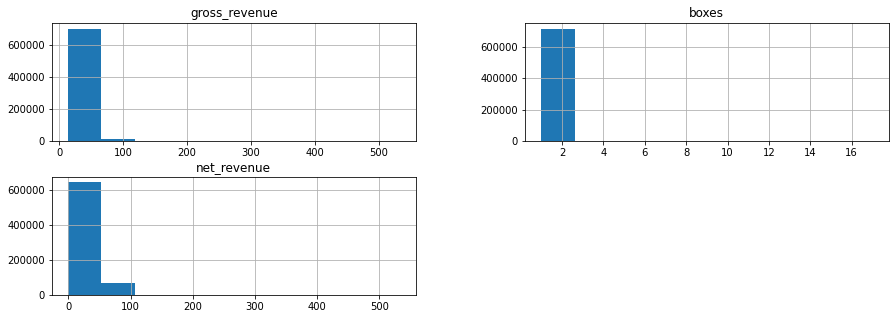

In [38]:
df[['gross_revenue','boxes','net_revenue']].hist(figsize=(15,5));

# 2.0 Feature engineering

In [43]:
df_2 = df.copy()

## <font color="gray"> Semanas do ano </font>

https://www.epochconverter.com/pt/semanas/2015

<b>2013</b>




Janeiro -    semana 1 a 5    -> 1


Fevereiro -  semana 6 - 9    -> 2


Março -      semana 10 - 13  -> 3


Abril -      semana 14 - 18  -> 4


Maio -       semana 19 - 22  -> 5


Junho -      semana 23 - 26  -> 6


Julho -      semana 27 - 31  -> 7


Agosto -     semana 32 - 35  -> 8


Setembro -   semana 36 -40   -> 9


Outubro -    semana 41 - 44  -> 10


Novembro -   semana 45 - 48  -> 11


Dezembro -   semana 49 - 52  -> 12





<b>2014</b>



Janeiro -    semana 1 a 5    -> 1



Fevereiro -  semana 6 - 9    -> 2



Março -      semana 10 - 14  -> 3



 
Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 35  -> 8




Setembro -   semana 36 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 48  -> 11




Dezembro -   semana 49 - 52  -> 12



<b>2015</b>





Janeiro -    semana 1 a 5    -> 1




Fevereiro -  semana 6 - 9    -> 2




Março -      semana 10 - 14  -> 3 




Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 36  -> 8




Setembro -   semana 37 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 49  -> 11




Dezembro -   semana 50 - 53  -> 12

## <font color="gray"> 2.1 Creating new features </font>

In [44]:
# Creating 'semester_of_year' column

df_2['semester_of_year'] =  [1 if i <26 else 2 for i in df['week_of_year']]



# Creating 'month_of_year' column

df_2['month_of_year'] = np.nan


# Filling month of year

# 2013

df_2.loc[df_2['year']==2013, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=13
                                                  else 4 if 14<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=26
                                                  else 7 if 27<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2013, 'week_of_year'] ]


# 2014

df_2.loc[df_2['year']==2014, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2014, 'week_of_year'] ]


# 2015

df_2.loc[df_2['year']==2015, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=36
                                                  else 9 if 37<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=49
                                                  else 12 for i in df_2.loc[df_2['year']==2015, 'week_of_year'] ]


# changing 'month_of_year' data type

df_2['month_of_year'] = df_2['month_of_year'].astype('int')



# Creating 'quarter_of_the_year' column (trimestre)

df_2['quarter'] = [1 if i<= 3
                  else 2 if 4<=i<=6
                  else 3 if 7<=i<=9
                  else 4  for i in df_2['month_of_year']]




# Creating 'week_of_month' column

df_2['week_of_month'] = np.nan


# filling the column:



            

# 2013

df_2.loc[df['year']==2013, 'week_of_month']  = [1 if it in          [1, 6, 10, 14, 19, 23, 27, 32, 36, 41, 45, 49]
                                                  else 2 if it in [2, 7, 11, 15, 20, 24, 28, 33, 37, 42, 46, 50]
                                                  else 3 if it in [3, 8, 12, 16, 21, 25, 29, 34, 38, 43, 47, 51]
                                                  else 4 if it in [4, 9, 13, 17, 22, 26, 30, 35, 39, 44, 48, 52]
                                                  else 5 for it in tuple(df_2.loc[df_2['year']==2013, 'week_of_year']) ]



    

# 2014

df_2.loc[df_2['year']==2014, 'week_of_month']  = [1 if it in       [1, 6, 10, 15, 19, 23, 28, 32, 36, 41, 45, 49]
                                                  else 2 if it in [2, 7, 11, 16, 20, 24, 29, 33, 37, 42, 46, 50]
                                                  else 3 if it in [3, 8, 12, 17, 21, 25, 30, 34, 38, 43, 47, 51]
                                                  else 4 if it in [4, 9, 13, 18, 22, 26, 31, 35, 39, 44, 48, 52]
                                                  else 5 for it in tuple(df_2.loc[df['year']==2014, 'week_of_year']) ]        






    

# 2015

df_2.loc[df_2['year']==2015, 'week_of_month']  = [1 if it in       [1, 6, 10, 15, 19, 23, 28, 32, 37, 41, 45, 50]
                                                  else 2 if it in [2, 7, 11, 16, 20, 24, 29, 33, 38, 42, 46, 51]
                                                  else 3 if it in [3, 8, 12, 17, 21, 25, 30, 34, 39, 43, 47, 52]
                                                  else 4 if it in [4, 9, 13, 18, 22, 26, 31, 35, 40, 44, 48, 53]
                                                          else 5 for it in tuple(df_2.loc[df['year']==2015, 'week_of_year']) ]  
            


    
            

# changing 'week_of_month' data type

df_2['week_of_month'] = df_2['week_of_month'].astype('int')


In [45]:
df_2

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year,semester_of_year,month_of_year,quarter,week_of_month
0,206461,Paid Marketing,2014,71,2,71,9,1,2,1,4
1,462640,Paid Marketing,2015,56,1,28,25,1,6,2,3
2,666461,Referral,2015,40,1,40,50,2,12,4,1
3,183202,Referral,2013,37,1,18,42,2,10,4,2
4,410993,Referral,2014,37,1,0,29,2,7,3,2
...,...,...,...,...,...,...,...,...,...,...,...
715870,741230,Referral,2015,40,1,0,51,2,12,4,2
715871,170503,Paid Marketing,2015,37,1,9,25,1,6,2,3
715872,169910,Referral,2015,37,1,37,4,1,1,1,4
715873,542301,Paid Marketing,2015,56,1,56,11,1,3,1,2


In [46]:
df_2.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
gross_revenue                   0
boxes                           0
net_revenue                     0
week_of_year                    0
semester_of_year                0
month_of_year                   0
quarter                         0
week_of_month                   0
dtype: int64

# 3.0 Data filtering

In [47]:
df_3 = df_2.copy()

In [48]:
# Remover as linhas onde 'net_revenue'==0

df_3 = df_3[df_3['net_revenue']!=0]


# Organizar o dataset cronologicamente (importante para problemas de previsão)

df_3 = df_3.sort_values(by=['year','week_of_year'])



# Remover colunas que não estarão em produção ['customer_acquisition_channel', 'gross_revenue', 'boxes'] e
## agrupar o df mantendo a granulometria em cada semana do ano, somando o net_revenue para cada semana

df_grouped = df_3[['year',
                   'month_of_year',
                   'week_of_month',
                   'week_of_year',
                   'quarter',
                   'semester_of_year',
                   'net_revenue']].groupby(['year',
                                            'month_of_year',
                                            'week_of_month',
                                            'week_of_year',
                                            'quarter',
                                            'semester_of_year']).sum().reset_index()

É possível observar abaixo que a redução na granulometria diminuiu significativamente o tamanho do dataset. Isso pode trazer consequências nos resultados dos modelos a serem avaliados. Entretanto o pressuposto assumido neste momento é o de que essa ação é a que faria maior sentido já que não se sabe quais clientes farão compras futuras, não se sabe também quais serão 'customer_acquisition_channel' utilizados em compras futuras. Uma vez que o problema demanda previsão de 'net_revenue' então decideiu-se manter as variáveis que estarão presentes no futuro.


Dessa forma, baseado na declaração acima, será então salvo o dataset que será assumido como o dataset de produção. As últimas 24 semanas (6 meses) serão separadas e o dataset será composto apenas pela coluna year e week

In [49]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,2,2,1,1,2310
1,2013,1,3,3,1,1,12342
2,2013,1,4,4,1,1,25807
3,2013,1,5,5,1,1,35713
4,2013,2,1,6,1,1,41898
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,245756
152,2015,11,5,49,4,2,265797
153,2015,12,1,50,4,2,261247
154,2015,12,2,51,4,2,216590


In [50]:
## Creating df_production
#
#df_production = df_grouped[['year', 'week_of_year']].copy()
#
#df_production = df_production.iloc[-24:,:]
#
#df_production = df_production.rename(columns={'week_of_year':'week'})
#
#df_production['week'] = ['W'+str(i) for i in df_production['week']]
#
#df_production.to_csv('X_test_production.csv')

# 4.0 Exploratory Data Analysis (EDA)

In [51]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

### <i>4.1.1 numerical attributes</i>

<AxesSubplot:>

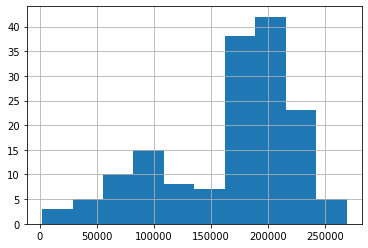

In [52]:
# Response variable

df_grouped['net_revenue'].hist()

In [53]:
df_grouped.columns

Index(['year', 'month_of_year', 'week_of_month', 'week_of_year', 'quarter',
       'semester_of_year', 'net_revenue'],
      dtype='object')

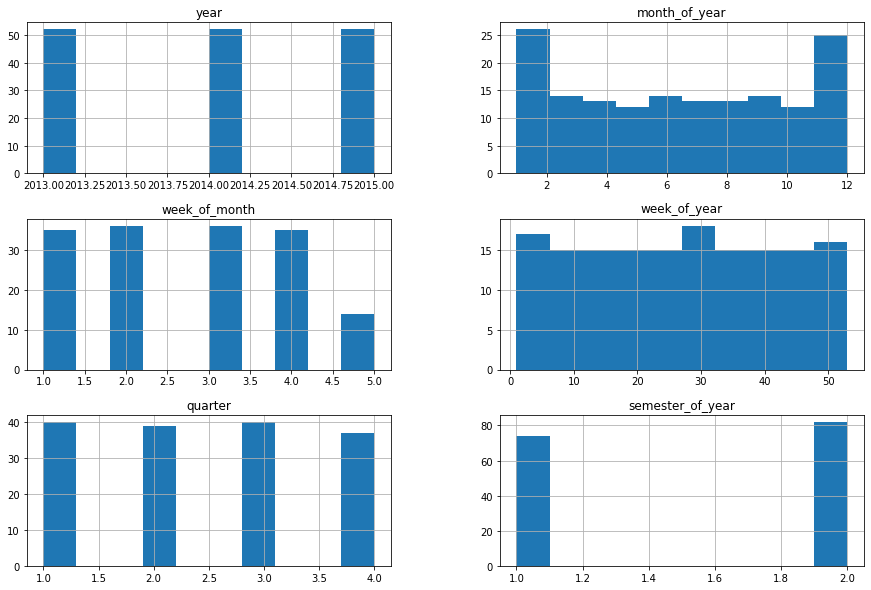

In [54]:
# Predictors

df_grouped[['year', 'month_of_year', 'week_of_month', 'week_of_year', 'quarter', 'semester_of_year']].hist(figsize=(15,10));

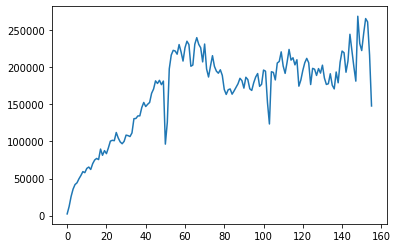

In [55]:
plt.plot(df_grouped['net_revenue'])

### <i>4.1.2 categorical attributes</i>

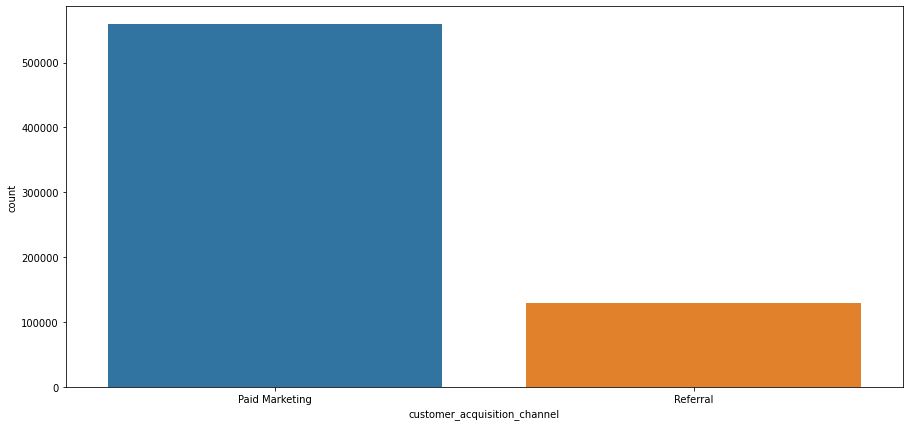

In [56]:
# customer_acquisition_chanell

plt.figure(figsize=(15,7))
sns.countplot(x='customer_acquisition_channel' , data=df_4);

## <font color="gray"> 4.2 Bivariate analysis </font>

### <font color="gray"> Business questions </font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="black"><b>Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

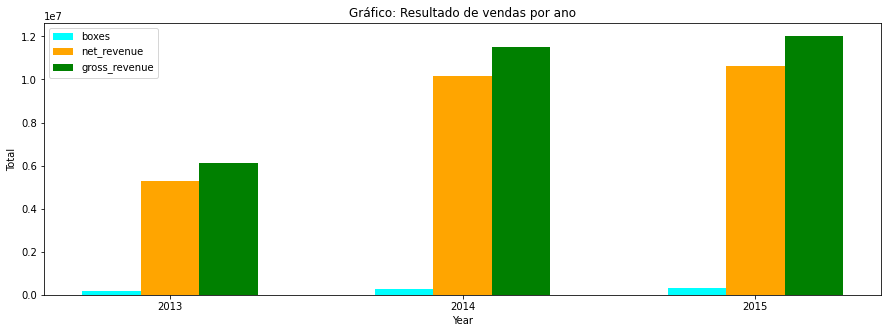

Tabela: Resultado de vendas por ano


,boxes,net_revenue,gross_revenue
year,,,
2013,156289,5295828,6134328
2014,291647,10161460,11505225
2015,292778,10611613,12019567


In [39]:
# data
x = df[['year','boxes','net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['year']
y2 = df[['year','boxes', 'net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['net_revenue']
y3 = df[['year','boxes','net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['gross_revenue']
y1 = df[['year','boxes', 'net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['boxes']





width = 0.2
 
plt.figure(figsize=(15,5))    
    
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')


plt.xticks(x, ['2013', '2014', '2015'])
plt.xlabel("Year")
plt.ylabel("Total")
plt.legend(["boxes", "net_revenue", "gross_revenue"])
plt.title('Gráfico: Resultado de vendas por ano')
plt.show()


# Tabela
print('Tabela: Resultado de vendas por ano')
df[['year','boxes','net_revenue','gross_revenue']].groupby('year').sum()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="black"><b> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

<b>R: Paid Marketing em 2013 e em 2015. Para isso seperaou-se o faturamento de cada customer_acquisition_channel e calculou-se a média para cada valor categórico dessa classe. Resposta abaixo</b></font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [97]:
# 2013

print('2013:')

df.loc[df['year']==2013, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

2013:


,customer_acquisition_channel,gross_revenue
0,Paid Marketing,42.076349
1,Referral,39.821818


In [98]:
# 2015

print('2015:')

df.loc[df['year']==2015, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

2015:


,customer_acquisition_channel,gross_revenue
0,Paid Marketing,42.039881
1,Referral,40.728221


https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="grey"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="black"><b>-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

<b>R: Tabela e gráfico no snipet abaixo</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

Tabela:


,year,customer_id
0,2013,35851
1,2014,54865
2,2015,51643


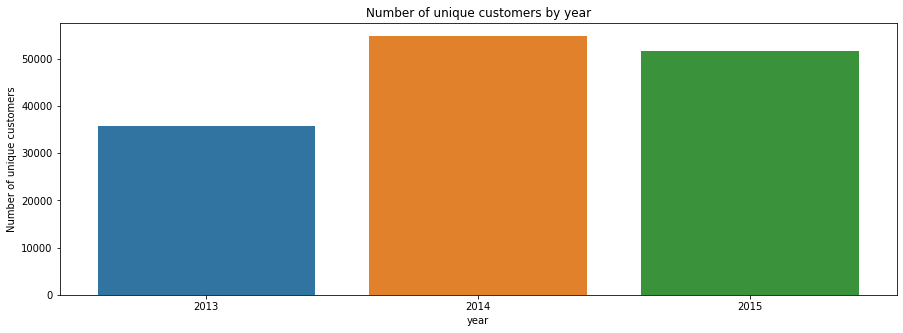

In [42]:
# Gráfico:
plt.figure(figsize=(15,5))
sns.barplot(x='year', y='customer_id', data=df[['customer_id','year']].groupby(['year']).nunique().reset_index())
plt.ylabel('Number of unique customers')
plt.title('Number of unique customers by year')
plt.plot()

# Tabela

# Grouping by year and counting uniques
print('Tabela:')
df[['customer_id','year']].groupby(['year']).nunique().reset_index()

### <font color="gray"> Aditional points </font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="black"><b>-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<b>R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<b>Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<b>Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</b></font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [57]:
# Net revenue total por cliente


print('net_revenue total por cliente:')

df_4[['customer_id', 'net_revenue']].groupby('customer_id').sum().sort_values(by=['net_revenue'], ascending=False)

net_revenue total por cliente:


,net_revenue
customer_id,
158442,9401
69490,9063
122802,8641
114193,8039
214580,7700
...,...
575311,1
674792,1
682310,1


In [58]:
# Perfil de net revenue dos clientes ao longo do tempo


df_aux = df_4[['year', 'week_of_year', 'customer_id', 'net_revenue']].groupby(['year', 'week_of_year', 'customer_id']).sum().reset_index()


print('Tabela net_revenue por cliente ao longo do tempo:')

df_aux

Tabela net_revenue por cliente ao longo do tempo:


,year,week_of_year,customer_id,net_revenue
0,2013,2,19281,28
1,2013,2,22110,18
2,2013,2,29943,18
3,2013,2,31511,23
4,2013,2,43450,18
...,...,...,...,...
688509,2015,52,746590,21
688510,2015,52,746592,20
688511,2015,52,746633,26
688512,2015,52,746640,44


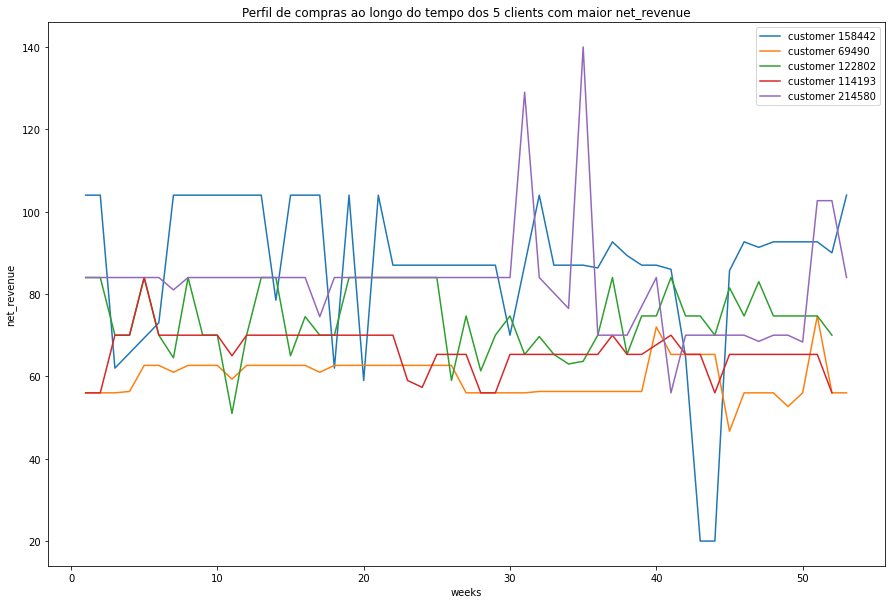

In [59]:
plt.figure(figsize=(15,10))


# customer 158442
sns.lineplot(x='week_of_year',y='net_revenue', data=df_aux[df_aux['customer_id']==158442], label ='customer 158442' ,
             ci=None)
plt.legend()
plt.xlabel('weeks')


# customer 69490
sns.lineplot(x='week_of_year',y='net_revenue', data=df_aux[df_aux['customer_id']==69490], label ='customer 69490' ,
             ci=None)
plt.legend()
plt.xlabel('weeks')


# customer 122802
sns.lineplot(x='week_of_year',y='net_revenue', data=df_aux[df_aux['customer_id']==122802], label ='customer 122802' ,
             ci=None)
plt.legend()
plt.xlabel('weeks')


# customer 114193
sns.lineplot(x='week_of_year',y='net_revenue', data=df_aux[df_aux['customer_id']==114193], label ='customer 114193' ,
             ci=None)
plt.legend()
plt.xlabel('weeks')


# customer 214580
sns.lineplot(x='week_of_year',y='net_revenue', data=df_aux[df_aux['customer_id']==214580], label ='customer 214580' ,
             ci=None)
plt.legend()
plt.xlabel('weeks')


plt.title('Perfil de compras ao longo do tempo dos 5 clients com maior net_revenue');

## <font color="gray"> 4.3 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

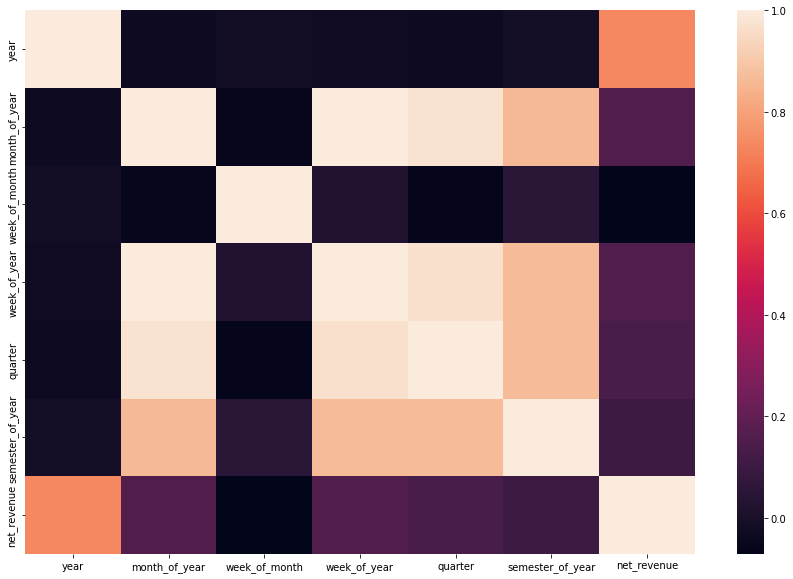

In [60]:
plt.figure(figsize=(15,10))

sns.heatmap(df_grouped.corr());

# 5.0 Data preparation

In [61]:
df_5 = df_grouped.copy()

## <font color="gray"> 5.1 Train/Test split </font>

A separação de treino e teste será feita respeitando a cronologia dos dados. Uma vez que eles já foram organizados na seção anterior então o split treino/teste será feito conforme o enunciado do problema demanda (6 meses futuros). Considerando que a granulometria dos dados ficou em semanas, dessa forma serão separados como conjunto teste as últimas 24 semanas.

In [62]:
df_5

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,2,2,1,1,2310
1,2013,1,3,3,1,1,12342
2,2013,1,4,4,1,1,25807
3,2013,1,5,5,1,1,35713
4,2013,2,1,6,1,1,41898
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,245756
152,2015,11,5,49,4,2,265797
153,2015,12,1,50,4,2,261247
154,2015,12,2,51,4,2,216590


In [63]:
# Redefining os index

df_5.index = [i for i in range(0,len(df_5))]


# Uma vez que as variáveis de data já foi desmembrada em novas features, remover a coluna 'year'

df_5 = df_5.drop(columns=['year'])

In [64]:
# Train 

train, test = df_5.iloc[:-24,:], df_5.iloc[-24:,:]

# X
X_train, X_test = train.drop(columns=['net_revenue']), test.drop(columns=['net_revenue'])

# y 
y_train, y_test = train['net_revenue'].copy(), test['net_revenue'].copy()

In [65]:
# Saving X_test to csv

#X_test.to_csv('X_test.csv')

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

As variáveis remanescentes são variáveis de natureza cíclica. Isso deve ser levado em consideração na hora de se fazer o scaling

In [66]:
# month_of_year

X_train['month_of_year_sin'] = X_train['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_train['month_of_year_cos'] = X_train['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))



# week_of_month

X_train['week_of_month_sin'] = X_train['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['week_of_month_cos'] = X_train['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))



# week_of_year

X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))



# quarter

X_train['quarter_sin'] = X_train['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['quarter_cos'] = X_train['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))




# Mantendo apenas as colunas codificadas 

X_train = X_train[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]

A variável 'semester_of_year' será codificada usando dummies:

In [67]:
# 'semester_of_year' - dummies

X_train['semester_of_year_1'] = X_train['semester_of_year'].apply(lambda x: 1 if x==1 else 0)

X_train['semester_of_year_2'] = X_train['semester_of_year'].apply(lambda x: 1 if x==2 else 0)


# removing original column
X_train = X_train.drop(columns=['semester_of_year'])

Fazendo o scaling dos dados de teste:

In [68]:
# month_of_year

X_test['month_of_year_sin'] = X_test['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_test['month_of_year_cos'] = X_test['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))



# week_of_month

X_test['week_of_month_sin'] = X_test['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['week_of_month_cos'] = X_test['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))



# week_of_year

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))



# quarter

X_test['quarter_sin'] = X_test['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['quarter_cos'] = X_test['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))



# Mantendo apenas as colunas codificadas 

X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]



# 'semester_of_year' - dummies

X_test['semester_of_year_1'] = X_test['semester_of_year'].apply(lambda x: 1 if x==1 else 0)

X_test['semester_of_year_2'] = X_test['semester_of_year'].apply(lambda x: 1 if x==2 else 0)


# removing original column
X_test = X_test.drop(columns=['semester_of_year'])

In [69]:

# reorganizando a ordem das colunas
X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin',
                 'week_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
                 'quarter_sin', 'quarter_cos', 'semester_of_year_1',
                 'semester_of_year_2']]

<AxesSubplot:xlabel='week_of_year_cos', ylabel='week_of_year_sin'>

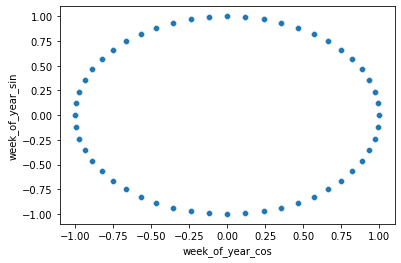

In [70]:
sns.scatterplot(x='week_of_year_cos', y='week_of_year_sin', data=X_train)

# 6.0 Machine learning

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="black"><b>Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.
    
  
    
    
 </font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [71]:
list_model_names = []
list_mae = []
list_mape = []
list_rmse = []
list_predictions = []

## <font color="gray"> 6.1 Baseline model </font>

In [72]:

# model definition
dummy_reg = DummyRegressor()

# model fit
dummy_reg.fit(X_train, y_train)

# predictions
y_pred = dummy_reg.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(dummy_reg))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(dummy_reg)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: DummyRegressor()

MAE: 51003.472222222226
MAPE: 0.22762596648341418
RMSE: 59268.88569588602


## <font color="gray"> 6.2 Linear Regression </font>

In [73]:

# model definition
lr = LinearRegression()

# model fit
lr.fit(X_train, y_train)

# predictions
y_pred = lr.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lr))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lr)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: LinearRegression()

MAE: 54266.141905380005
MAPE: 0.2454816354991803
RMSE: 61016.43400052654


## <font color="gray"> 6.3 Random Forest </font>

In [74]:
# model definition
rf = RandomForestRegressor()

# model fit
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(rf))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Random Forest')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: RandomForestRegressor()

MAE: 50553.24694543652
MAPE: 0.2339142756899902
RMSE: 54158.84191651306


## <font color="gray"> 6.4 Neural Network - MLP</font>

In [75]:
# ========================= ANN com LOOCV ===================================================

# ========================= model training =======================================

in_dim = np.array(X_train).shape[1]
out_dim = np.array(y_train.to_frame()).shape[1]



   
# define model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(100, input_dim=in_dim, activation="relu"))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(32, activation="relu"))
# Defining the Ouput layer
model.add(Dense(out_dim))
# Compiling the model
model.compile(loss="mse", optimizer="rmsprop")      

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#predictions
y_pred = model.predict(X_test)
    

# ============================================================================================ 


# Metrics
print('Model metrics: {}\n'.format('Neural Network'))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Neural Network')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1100      
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-06-04 23:52:03.891662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-04 23:52:03.891734: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-04 23:52:03.891776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SP300UNG098): /proc/driver/nvidia/version does not exist
2022-06-04 23:52:03.892152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11/11 [==============================] - 0s 950us/step - loss: 28657518592.0000
Epoch 2/100
11/11 [==============================] - 0s 835us/step - loss: 28657215488.0000
Epoch 3/100
11/11 [==============================] - 0s 839us/step - loss: 28656877568.0000
Epoch 4/100
11/11 [==============================] - 0s 846us/step - loss: 28656459776.0000
Epoch 5/100
11/11 [==============================] - 0s 842us/step - loss: 28655933440.0000
Epoch 6/100
11/11 [==============================] - 0s 768us/step - loss: 28655284224.0000
Epoch 7/100
11/11 [==============================] - 0s 805us/step - loss: 28654497792.0000
Epoch 8/100
11/11 [==============================] - 0s 823us/step - loss: 28653572096.0000
Epoch 9/100
11/11 [==============================] - 0s 806us/step - loss: 28652496896.0000
Epoch 10/100
11/11 [==============================] - 0s 795us/step - loss: 28651257856.0000
Epoch 11/100
11/11 [==============================] - 0s 777us/step - loss: 28649848832.000

11/11 [==============================] - 0s 775us/step - loss: 27261431808.0000
Epoch 90/100
11/11 [==============================] - 0s 834us/step - loss: 27218259968.0000
Epoch 91/100
11/11 [==============================] - 0s 795us/step - loss: 27174815744.0000
Epoch 92/100
11/11 [==============================] - 0s 773us/step - loss: 27129913344.0000
Epoch 93/100
11/11 [==============================] - 0s 747us/step - loss: 27083614208.0000
Epoch 94/100
11/11 [==============================] - 0s 785us/step - loss: 27037560832.0000
Epoch 95/100
11/11 [==============================] - 0s 788us/step - loss: 26990641152.0000
Epoch 96/100
11/11 [==============================] - 0s 768us/step - loss: 26942670848.0000
Epoch 97/100
11/11 [==============================] - 0s 778us/step - loss: 26894104576.0000
Epoch 98/100
11/11 [==============================] - 0s 795us/step - loss: 26844055552.0000
Epoch 99/100
11/11 [==============================] - 0s 791us/step - loss: 2679265

## <font color="gray"> 6.5 ARIMA </font>

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [76]:
# Dataframe para ARIMA

df_arima_train = pd.DataFrame(y_train)

df_arima_test = pd.DataFrame(y_test)

In [77]:
# Implementando ARIMA

decomposition =  seasonal_decompose(df_arima_train, period=62)

model = ARIMA(df_arima_train, order=(2,1,2))

results = model.fit()

In [78]:
## Ajuste arima

# results.fittedvalues


# Inserindo as predições no conjunto teste

df_arima_test['predictions'] = results.predict(start=132, end=155)

In [79]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_arima_test['net_revenue'].values,
                                                       df_arima_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('ARIMA')
list_mae.append(mean_absolute_error(y_test, df_arima_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_arima_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_arima_test['predictions'].values, squared=False))

list_predictions.append(df_arima_test['predictions'].values)

MAE: 29550.20103563106
MAPE: 0.1320715768009972
RMSE: 37647.96266719912


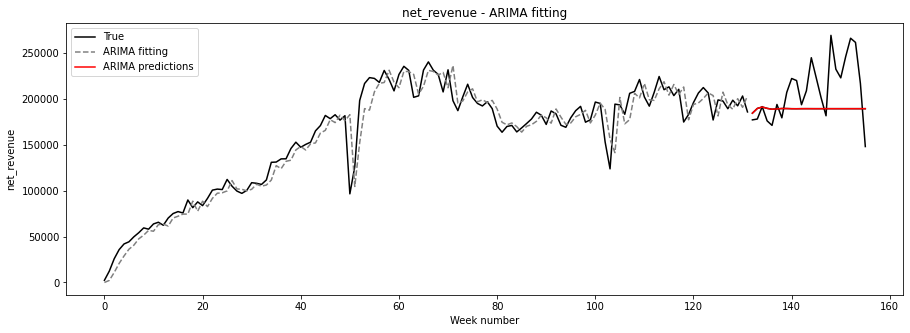

In [80]:
plt.figure(figsize=(15,5))


plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='ARIMA fitting', linestyle="--")
plt.legend()


plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - ARIMA fitting');

## <font color="gray"><i> Overall results </i></font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="black"><b>Qual modelo teve a melhor performance?
    
<font color="black"><b>R: Considerando a métrica MAE (e também MAPE e RMSE) a abordagem que retornou o menor erro no conjunto de teste foi o ARIMA (tabela abaixo).</b></font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [81]:
print('Resultado modelos:')

pd.DataFrame({'MAPE':list_mape, 'MAE':list_mae, 'RMSE':list_rmse}, index=list_model_names).sort_values(by=['MAE'])

Resultado modelos:


,MAPE,MAE,RMSE
ARIMA,0.132072,29550.201036,37647.962667
Random Forest,0.233914,50553.246945,54158.841917
DummyRegressor(),0.227626,51003.472222,59268.885696
LinearRegression(),0.245482,54266.141905,61016.434001
Neural Network,0.984373,206208.435186,208583.033362


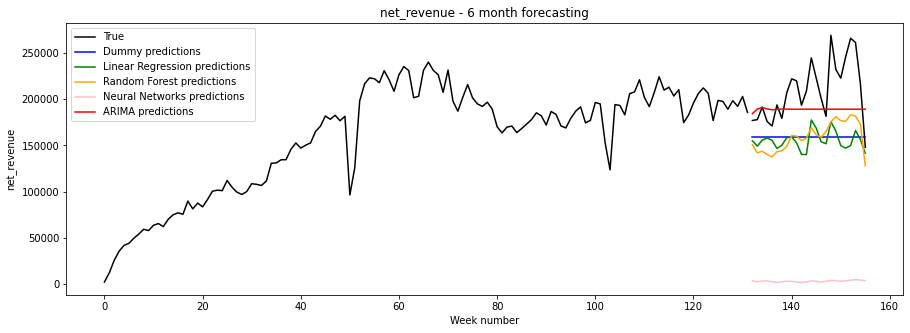

In [82]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()



# Random Forest
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()



# Neural Networks
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')

plt.legend()


# ARIMA
plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()




plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

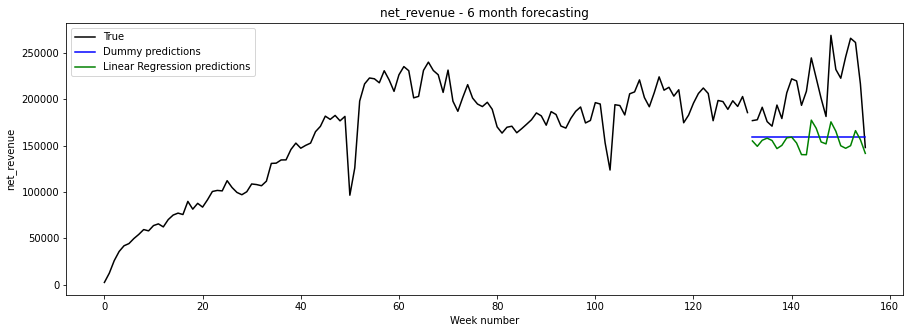

In [83]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="grey">Qual modelo teve a melhor performance?

- <font color="grey">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="black"><b>Como realizou treino e teste?</b></font>
    
<font color="black"><b>R: Conforme mencionado anteriormente, por se tratar de um problema de previsão no tempo é importante considerar essa informação na resolução do problema na parte da separação dos respectivos conjuntos de treino e teste. Ambos os conjuntos precisam estar organizados temporalmente onde o conjunto teste deve corresponder ao período futuro em relação ao conjunto de treino. Uma vez que a granulometria usada para resolver o problema estava em semanas e a demanda de previsão era para 6 meses então separou-se as últimas 24 semanas para ser o conjunto teste.</b></font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

## <font color="orange"> 6.6 Evaluating data slices </font>

Ao observar o plot abaixo de net_revenue em função das semanas é possível observar que o comportamento de net_revenue antes de 60 semanas é diferente do comportamento após 60 semanas. Enquanto que no primeiro caso é possível observar um comportament de crescimento em função do tempo, no segundo caso esse comportamento é diferente. Dessa forma esses diferentes perfis de comportamento podem, de alguma forma, estar comprometendo a eficiência do algoritmo na previsão de vendas para 6 meses.


Uma vez que o enunciado do problema demanda a previsão de vendas para 6 meses (24 semanas) e que não foi mencionado sobre critérios de utilização dos dados no treinamento dos algoritmos, decidiu-se então adotar a seguinte estratégia:

- O conjunto de teste foi mantido para as últimas 24 semanas do dataset conforme as demais avaliações.
- Foram avaliados diferentes conjuntos de treinamento relizando-se diferentes slices no conjunto de treinamento, variando a data mais antiga do dado de treinamento (início do slicing) e mantendo a data mais recente (mais próxima da primeira data do conjunto de teste, término do slicing).
- As métricas do modelo foram coletadas para cada diferente slicing aplicado aos dados para então se obter um ponto de corte ideal que maximiza do desempenho do modelo.
- A estratégia foi repetida para os demais modelos de machine learning avaliados anteriormente

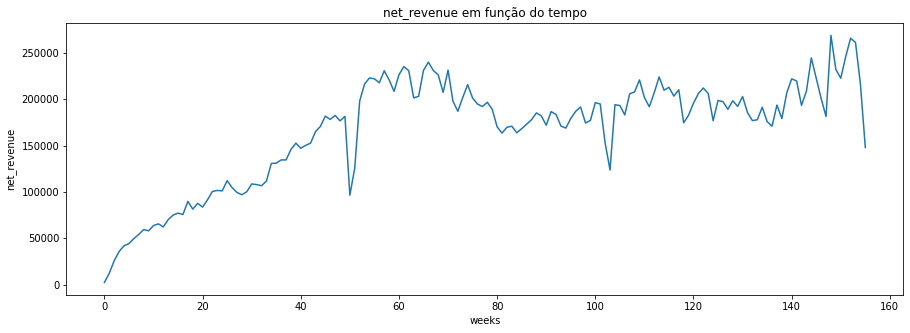

In [84]:
plt.figure(figsize=(15,5))
plt.plot(df_grouped['net_revenue']);
plt.xlabel('weeks')
plt.ylabel('net_revenue')
plt.title('net_revenue em função do tempo');

In [85]:
# Lists to store metrics for optimed slicing

list_best_mae = []
list_best_mape = []
list_best_rmse = []
list_best_slicing_index = []

list_model_names = []

### <font color="orange"> Linear Regression </font>

In [86]:
# Linear Regression - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = LinearRegression()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format(model))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append(lr)
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: LinearRegression()

MAE: 54266.141905380005
MAPE: 0.2454816354991803
RMSE: 61016.43400052654

Initial slicing index evaluated: 1

Model metrics: LinearRegression()

MAE: 53581.43563714661
MAPE: 0.24318877213176948
RMSE: 59998.85981334715

Initial slicing index evaluated: 2

Model metrics: LinearRegression()

MAE: 53078.900198159216
MAPE: 0.24091140155622845
RMSE: 59393.03717248731

Initial slicing index evaluated: 3

Model metrics: LinearRegression()

MAE: 53011.3804062544
MAPE: 0.2412272993148621
RMSE: 58858.655871761744

Initial slicing index evaluated: 4

Model metrics: LinearRegression()

MAE: 53309.489587907134
MAPE: 0.24410547931194485
RMSE: 58524.88673702149

Initial slicing index evaluated: 5

Model metrics: LinearRegression()

MAE: 52846.14636313589
MAPE: 0.24274046996300513
RMSE: 57632.66772142471

Initial slicing index evaluated: 6

Model metrics: LinearRegression()

MAE: 52540.91638380166
MAPE: 0.2416716965717002
RMSE: 572


Initial slicing index evaluated: 64

Model metrics: LinearRegression()

MAE: 37162.13509330214
MAPE: 0.16426965774736293
RMSE: 45167.271671521674

Initial slicing index evaluated: 65

Model metrics: LinearRegression()

MAE: 37168.82476022103
MAPE: 0.16430216965386057
RMSE: 45172.42567087775

Initial slicing index evaluated: 66

Model metrics: LinearRegression()

MAE: 36860.335408060244
MAPE: 0.1625510886218953
RMSE: 45152.01884847596

Initial slicing index evaluated: 67

Model metrics: LinearRegression()

MAE: 36904.091325515205
MAPE: 0.16267545024096622
RMSE: 45209.93189553677

Initial slicing index evaluated: 68

Model metrics: LinearRegression()

MAE: 36574.200866936124
MAPE: 0.1607997918869644
RMSE: 45110.17194969619

Initial slicing index evaluated: 69

Model metrics: LinearRegression()

MAE: 36165.7117055332
MAPE: 0.15884732282006747
RMSE: 44697.35228636306

Initial slicing index evaluated: 70

Model metrics: LinearRegression()

MAE: 36003.276046145365
MAPE: 0.15808261559702555


### <font color="orange"> Random Forest </font>

In [87]:
# Random Forest - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = RandomForestRegressor()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('Random Forest'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('Random Forest')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: RandomForestRegressor()

MAE: 50500.07281448412
MAPE: 0.23283281400409098
RMSE: 54421.38889642969

Initial slicing index evaluated: 1

Model metrics: RandomForestRegressor()

MAE: 50507.41376587301
MAPE: 0.23278334446022983
RMSE: 54509.016251005574

Initial slicing index evaluated: 2

Model metrics: RandomForestRegressor()

MAE: 50700.64431547618
MAPE: 0.23454035768295314
RMSE: 54400.13209056202

Initial slicing index evaluated: 3

Model metrics: RandomForestRegressor()

MAE: 51154.38353769841
MAPE: 0.23747257312304795
RMSE: 54435.78938629486

Initial slicing index evaluated: 4

Model metrics: RandomForestRegressor()

MAE: 51353.39611557539
MAPE: 0.23854952687838246
RMSE: 54655.1311629871

Initial slicing index evaluated: 5

Model metrics: RandomForestRegressor()

MAE: 50649.43873710317
MAPE: 0.23440642095938488
RMSE: 54386.126833869836

Initial slicing index evaluated: 6

Model metrics: RandomForestRegressor()

MAE: 51035.65400297619


Initial slicing index evaluated: 55

Model metrics: RandomForestRegressor()

MAE: 34472.144069444446
MAPE: 0.15025442593034835
RMSE: 42997.844302437

Initial slicing index evaluated: 56

Model metrics: RandomForestRegressor()

MAE: 34795.230131944445
MAPE: 0.1516567260863786
RMSE: 43526.72833538605

Initial slicing index evaluated: 57

Model metrics: RandomForestRegressor()

MAE: 34483.68855555556
MAPE: 0.15072820635075432
RMSE: 42805.34329877469

Initial slicing index evaluated: 58

Model metrics: RandomForestRegressor()

MAE: 34395.7756875
MAPE: 0.15026965467753542
RMSE: 42706.93695718949

Initial slicing index evaluated: 59

Model metrics: RandomForestRegressor()

MAE: 34252.70627777777
MAPE: 0.14943467652295625
RMSE: 42607.57079194777

Initial slicing index evaluated: 60

Model metrics: RandomForestRegressor()

MAE: 34465.03952777778
MAPE: 0.15027432789393794
RMSE: 42968.8860649406

Initial slicing index evaluated: 61

Model metrics: RandomForestRegressor()

MAE: 34434.87416666667


Initial slicing index evaluated: 113

Model metrics: RandomForestRegressor()

MAE: 24302.672083333327
MAPE: 0.11325689260013024
RMSE: 30735.49068297911

Initial slicing index evaluated: 114

Model metrics: RandomForestRegressor()

MAE: 25637.702083333337
MAPE: 0.11801968412857498
RMSE: 32427.679054762837

Initial slicing index evaluated: 115

Model metrics: RandomForestRegressor()

MAE: 27079.076666666664
MAPE: 0.12330199192518927
RMSE: 34215.52468405924

Initial slicing index evaluated: 116

Model metrics: RandomForestRegressor()

MAE: 28229.210416666665
MAPE: 0.12820586878466161
RMSE: 35027.38323659392

Initial slicing index evaluated: 117

Model metrics: RandomForestRegressor()

MAE: 28125.859166666673
MAPE: 0.12793632050715323
RMSE: 35059.91714134949

Initial slicing index evaluated: 118

Model metrics: RandomForestRegressor()

MAE: 30736.362916666665
MAPE: 0.13801314120641942
RMSE: 38294.99045533833

Initial slicing index evaluated: 119

Model metrics: RandomForestRegressor()

MA

### <font color="orange"> Neural Networks MLP </font>

In [88]:
# MLP Neural Networks - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    in_dim = np.array(X_train).shape[1]
    out_dim = np.array(y_train.to_frame()).shape[1]
    
    
    
       
    # define model
    model = Sequential()
    
    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(100, input_dim=in_dim, activation="relu"))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(32, activation="relu"))
    # Defining the Ouput layer
    model.add(Dense(out_dim))
    # Compiling the model
    model.compile(loss="mse", optimizer="rmsprop")      
    
    model.summary()
    
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]], epochs=100, batch_size=12, verbose=1)
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('MLP'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('MLP')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1100      
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 930us/step - loss: 28657287168.0000
Epoch 2/100
11/11 [==============================] - 0s 784us/step - loss: 28656797696.0000
Epoch 3/100
11/11 [==============================] - 0s 753us/step - loss: 28656236544.0000
Epoch 4/100
11/11 [=====================

11/11 [==============================] - 0s 746us/step - loss: 27366742016.0000
Epoch 81/100
11/11 [==============================] - 0s 765us/step - loss: 27323705344.0000
Epoch 82/100
11/11 [==============================] - 0s 1ms/step - loss: 27279742976.0000
Epoch 83/100
11/11 [==============================] - 0s 795us/step - loss: 27234363392.0000
Epoch 84/100
11/11 [==============================] - 0s 713us/step - loss: 27188793344.0000
Epoch 85/100
11/11 [==============================] - 0s 748us/step - loss: 27141894144.0000
Epoch 86/100
11/11 [==============================] - 0s 753us/step - loss: 27093467136.0000
Epoch 87/100
11/11 [==============================] - 0s 721us/step - loss: 27044538368.0000
Epoch 88/100
11/11 [==============================] - 0s 745us/step - loss: 26995460096.0000
Epoch 89/100
11/11 [==============================] - 0s 757us/step - loss: 26944933888.0000
Epoch 90/100
11/11 [==============================] - 0s 731us/step - loss: 268931809

11/11 [==============================] - 0s 750us/step - loss: 28500234240.0000
Epoch 58/100
11/11 [==============================] - 0s 773us/step - loss: 28482498560.0000
Epoch 59/100
11/11 [==============================] - 0s 769us/step - loss: 28464492544.0000
Epoch 60/100
11/11 [==============================] - 0s 762us/step - loss: 28445913088.0000
Epoch 61/100
11/11 [==============================] - 0s 805us/step - loss: 28426840064.0000
Epoch 62/100
11/11 [==============================] - 0s 767us/step - loss: 28407035904.0000
Epoch 63/100
11/11 [==============================] - 0s 785us/step - loss: 28386549760.0000
Epoch 64/100
11/11 [==============================] - 0s 788us/step - loss: 28365506560.0000
Epoch 65/100
11/11 [==============================] - 0s 779us/step - loss: 28343920640.0000
Epoch 66/100
11/11 [==============================] - 0s 807us/step - loss: 28322191360.0000
Epoch 67/100
11/11 [==============================] - 0s 768us/step - loss: 2829944

11/11 [==============================] - 0s 746us/step - loss: 28955013120.0000
Epoch 35/100
11/11 [==============================] - 0s 740us/step - loss: 28944089088.0000
Epoch 36/100
11/11 [==============================] - 0s 745us/step - loss: 28932734976.0000
Epoch 37/100
11/11 [==============================] - 0s 769us/step - loss: 28920782848.0000
Epoch 38/100
11/11 [==============================] - 0s 781us/step - loss: 28908271616.0000
Epoch 39/100
11/11 [==============================] - 0s 746us/step - loss: 28895213568.0000
Epoch 40/100
11/11 [==============================] - 0s 752us/step - loss: 28881698816.0000
Epoch 41/100
11/11 [==============================] - 0s 745us/step - loss: 28867573760.0000
Epoch 42/100
11/11 [==============================] - 0s 779us/step - loss: 28852742144.0000
Epoch 43/100
11/11 [==============================] - 0s 723us/step - loss: 28837150720.0000
Epoch 44/100
11/11 [==============================] - 0s 768us/step - loss: 2882108

11/11 [==============================] - 0s 796us/step - loss: 29312149504.0000
Epoch 12/100
11/11 [==============================] - 0s 771us/step - loss: 29311068160.0000
Epoch 13/100
11/11 [==============================] - 0s 754us/step - loss: 29309861888.0000
Epoch 14/100
11/11 [==============================] - 0s 792us/step - loss: 29308485632.0000
Epoch 15/100
11/11 [==============================] - 0s 774us/step - loss: 29306984448.0000
Epoch 16/100
11/11 [==============================] - 0s 738us/step - loss: 29305346048.0000
Epoch 17/100
11/11 [==============================] - 0s 777us/step - loss: 29303560192.0000
Epoch 18/100
11/11 [==============================] - 0s 770us/step - loss: 29301594112.0000
Epoch 19/100
11/11 [==============================] - 0s 761us/step - loss: 29299462144.0000
Epoch 20/100
11/11 [==============================] - 0s 755us/step - loss: 29297164288.0000
Epoch 21/100
11/11 [==============================] - 0s 735us/step - loss: 2929466

11/11 [==============================] - 0s 760us/step - loss: 28095000576.0000
Epoch 100/100
11/11 [==============================] - 0s 769us/step - loss: 28061569024.0000

Initial slicing index evaluated: 3

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3ba47ada90>

MAE: 207670.03297932944
MAPE: 0.9912871783920645
RMSE: 210081.7139917254
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               1100      
                                                                 
 dense_16 (Dense)            (None, 32)                3232      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
____________________

11/11 [==============================] - 0s 854us/step - loss: 28871520256.0000
Epoch 69/100
11/11 [==============================] - 0s 768us/step - loss: 28844826624.0000
Epoch 70/100
11/11 [==============================] - 0s 744us/step - loss: 28817580032.0000
Epoch 71/100
11/11 [==============================] - 0s 721us/step - loss: 28789485568.0000
Epoch 72/100
11/11 [==============================] - 0s 753us/step - loss: 28761378816.0000
Epoch 73/100
11/11 [==============================] - 0s 726us/step - loss: 28732436480.0000
Epoch 74/100
11/11 [==============================] - 0s 741us/step - loss: 28702218240.0000
Epoch 75/100
11/11 [==============================] - 0s 769us/step - loss: 28671459328.0000
Epoch 76/100
11/11 [==============================] - 0s 774us/step - loss: 28640479232.0000
Epoch 77/100
11/11 [==============================] - 0s 778us/step - loss: 28608198656.0000
Epoch 78/100
11/11 [==============================] - 0s 788us/step - loss: 2857572

11/11 [==============================] - 0s 763us/step - loss: 29590855680.0000
Epoch 38/100
11/11 [==============================] - 0s 734us/step - loss: 29579554816.0000
Epoch 39/100
11/11 [==============================] - 0s 744us/step - loss: 29567643648.0000
Epoch 40/100
11/11 [==============================] - 0s 711us/step - loss: 29555116032.0000
Epoch 41/100
11/11 [==============================] - 0s 724us/step - loss: 29542084608.0000
Epoch 42/100
11/11 [==============================] - 0s 722us/step - loss: 29528545280.0000
Epoch 43/100
11/11 [==============================] - 0s 713us/step - loss: 29514350592.0000
Epoch 44/100
11/11 [==============================] - 0s 734us/step - loss: 29499729920.0000
Epoch 45/100
11/11 [==============================] - 0s 718us/step - loss: 29484621824.0000
Epoch 46/100
11/11 [==============================] - 0s 746us/step - loss: 29468903424.0000
Epoch 47/100
11/11 [==============================] - 0s 733us/step - loss: 2945266

11/11 [==============================] - 0s 788us/step - loss: 29963356160.0000
Epoch 15/100
11/11 [==============================] - 0s 787us/step - loss: 29961277440.0000
Epoch 16/100
11/11 [==============================] - 0s 789us/step - loss: 29958991872.0000
Epoch 17/100
11/11 [==============================] - 0s 797us/step - loss: 29956452352.0000
Epoch 18/100
11/11 [==============================] - 0s 759us/step - loss: 29953728512.0000
Epoch 19/100
11/11 [==============================] - 0s 775us/step - loss: 29950763008.0000
Epoch 20/100
11/11 [==============================] - 0s 775us/step - loss: 29947488256.0000
Epoch 21/100
11/11 [==============================] - 0s 778us/step - loss: 29944039424.0000
Epoch 22/100
11/11 [==============================] - 0s 782us/step - loss: 29940369408.0000
Epoch 23/100
11/11 [==============================] - 0s 752us/step - loss: 29936408576.0000
Epoch 24/100
11/11 [==============================] - 0s 766us/step - loss: 2993209

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               1100      
                                                                 
 dense_25 (Dense)            (None, 32)                3232      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 905us/step - loss: 30196070400.0000
Epoch 2/100
11/11 [==============================] - 0s 850us/step - loss: 30195755008.0000
Epoch 3/100
11/11 [==============================] - 0s 826us/step - loss: 30195400704.0000
Epoch 4/100
11/11 [=====================

11/11 [==============================] - 0s 749us/step - loss: 29214670848.0000
Epoch 81/100
11/11 [==============================] - 0s 777us/step - loss: 29180993536.0000
Epoch 82/100
11/11 [==============================] - 0s 776us/step - loss: 29145362432.0000
Epoch 83/100
11/11 [==============================] - 0s 787us/step - loss: 29110394880.0000
Epoch 84/100
11/11 [==============================] - 0s 767us/step - loss: 29074925568.0000
Epoch 85/100
11/11 [==============================] - 0s 759us/step - loss: 29038954496.0000
Epoch 86/100
11/11 [==============================] - 0s 759us/step - loss: 29001918464.0000
Epoch 87/100
11/11 [==============================] - 0s 758us/step - loss: 28963606528.0000
Epoch 88/100
11/11 [==============================] - 0s 720us/step - loss: 28924532736.0000
Epoch 89/100
11/11 [==============================] - 0s 722us/step - loss: 28885319680.0000
Epoch 90/100
11/11 [==============================] - 0s 696us/step - loss: 2884432

11/11 [==============================] - 0s 714us/step - loss: 30048784384.0000
Epoch 58/100
11/11 [==============================] - 0s 723us/step - loss: 30030886912.0000
Epoch 59/100
11/11 [==============================] - 0s 724us/step - loss: 30013206528.0000
Epoch 60/100
11/11 [==============================] - 0s 750us/step - loss: 29995481088.0000
Epoch 61/100
11/11 [==============================] - 0s 734us/step - loss: 29976358912.0000
Epoch 62/100
11/11 [==============================] - 0s 758us/step - loss: 29956694016.0000
Epoch 63/100
11/11 [==============================] - 0s 861us/step - loss: 29936902144.0000
Epoch 64/100
11/11 [==============================] - 0s 777us/step - loss: 29916307456.0000
Epoch 65/100
11/11 [==============================] - 0s 733us/step - loss: 29894307840.0000
Epoch 66/100
11/11 [==============================] - 0s 775us/step - loss: 29872617472.0000
Epoch 67/100
11/11 [==============================] - 0s 752us/step - loss: 2985012

11/11 [==============================] - 0s 773us/step - loss: 30494615552.0000
Epoch 35/100
11/11 [==============================] - 0s 781us/step - loss: 30483765248.0000
Epoch 36/100
11/11 [==============================] - 0s 777us/step - loss: 30472560640.0000
Epoch 37/100
11/11 [==============================] - 0s 758us/step - loss: 30461016064.0000
Epoch 38/100
11/11 [==============================] - 0s 763us/step - loss: 30448580608.0000
Epoch 39/100
11/11 [==============================] - 0s 767us/step - loss: 30435653632.0000
Epoch 40/100
11/11 [==============================] - 0s 769us/step - loss: 30422464512.0000
Epoch 41/100
11/11 [==============================] - 0s 793us/step - loss: 30408482816.0000
Epoch 42/100
11/11 [==============================] - 0s 745us/step - loss: 30394425344.0000
Epoch 43/100
11/11 [==============================] - 0s 768us/step - loss: 30379431936.0000
Epoch 44/100
11/11 [==============================] - 0s 802us/step - loss: 3036385

11/11 [==============================] - 0s 797us/step - loss: 30847182848.0000
Epoch 12/100
11/11 [==============================] - 0s 763us/step - loss: 30845093888.0000
Epoch 13/100
11/11 [==============================] - 0s 791us/step - loss: 30842720256.0000
Epoch 14/100
11/11 [==============================] - 0s 762us/step - loss: 30840195072.0000
Epoch 15/100
11/11 [==============================] - 0s 773us/step - loss: 30837280768.0000
Epoch 16/100
11/11 [==============================] - 0s 756us/step - loss: 30834130944.0000
Epoch 17/100
11/11 [==============================] - 0s 765us/step - loss: 30830665728.0000
Epoch 18/100
11/11 [==============================] - 0s 772us/step - loss: 30827022336.0000
Epoch 19/100
11/11 [==============================] - 0s 738us/step - loss: 30823018496.0000
Epoch 20/100
11/11 [==============================] - 0s 771us/step - loss: 30818764800.0000
Epoch 21/100
11/11 [==============================] - 0s 791us/step - loss: 3081411

11/11 [==============================] - 0s 741us/step - loss: 28667430912.0000
Epoch 100/100
11/11 [==============================] - 0s 775us/step - loss: 28610895872.0000

Initial slicing index evaluated: 10

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3ba473bb80>

MAE: 205489.42778523764
MAPE: 0.9806742169109443
RMSE: 207916.98029182467
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               1100      
                                                                 
 dense_37 (Dense)            (None, 32)                3232      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________

11/11 [==============================] - 0s 760us/step - loss: 30037065728.0000
Epoch 77/100
11/11 [==============================] - 0s 755us/step - loss: 29997844480.0000
Epoch 78/100
11/11 [==============================] - 0s 758us/step - loss: 29959272448.0000
Epoch 79/100
11/11 [==============================] - 0s 728us/step - loss: 29919971328.0000
Epoch 80/100
11/11 [==============================] - 0s 752us/step - loss: 29881579520.0000
Epoch 81/100
11/11 [==============================] - 0s 745us/step - loss: 29838364672.0000
Epoch 82/100
11/11 [==============================] - 0s 757us/step - loss: 29798615040.0000
Epoch 83/100
11/11 [==============================] - 0s 753us/step - loss: 29755713536.0000
Epoch 84/100
11/11 [==============================] - 0s 742us/step - loss: 29711355904.0000
Epoch 85/100
11/11 [==============================] - 0s 726us/step - loss: 29665001472.0000
Epoch 86/100
11/11 [==============================] - 0s 761us/step - loss: 2962105

10/10 [==============================] - 0s 731us/step - loss: 31052505088.0000
Epoch 54/100
10/10 [==============================] - 0s 723us/step - loss: 31039954944.0000
Epoch 55/100
10/10 [==============================] - 0s 723us/step - loss: 31026935808.0000
Epoch 56/100
10/10 [==============================] - 0s 756us/step - loss: 31013281792.0000
Epoch 57/100
10/10 [==============================] - 0s 768us/step - loss: 30999230464.0000
Epoch 58/100
10/10 [==============================] - 0s 731us/step - loss: 30984800256.0000
Epoch 59/100
10/10 [==============================] - 0s 749us/step - loss: 30969812992.0000
Epoch 60/100
10/10 [==============================] - 0s 732us/step - loss: 30954489856.0000
Epoch 61/100
10/10 [==============================] - 0s 709us/step - loss: 30938818560.0000
Epoch 62/100
10/10 [==============================] - 0s 747us/step - loss: 30922702848.0000
Epoch 63/100
10/10 [==============================] - 0s 711us/step - loss: 3090584

10/10 [==============================] - 0s 770us/step - loss: 31457288192.0000
Epoch 31/100
10/10 [==============================] - 0s 815us/step - loss: 31451047936.0000
Epoch 32/100
10/10 [==============================] - 0s 783us/step - loss: 31444482048.0000
Epoch 33/100
10/10 [==============================] - 0s 747us/step - loss: 31437602816.0000
Epoch 34/100
10/10 [==============================] - 0s 753us/step - loss: 31430313984.0000
Epoch 35/100
10/10 [==============================] - 0s 763us/step - loss: 31422783488.0000
Epoch 36/100
10/10 [==============================] - 0s 770us/step - loss: 31414960128.0000
Epoch 37/100
10/10 [==============================] - 0s 746us/step - loss: 31406856192.0000
Epoch 38/100
10/10 [==============================] - 0s 752us/step - loss: 31398322176.0000
Epoch 39/100
10/10 [==============================] - 0s 778us/step - loss: 31389425664.0000
Epoch 40/100
10/10 [==============================] - 0s 759us/step - loss: 3138021

10/10 [==============================] - 0s 812us/step - loss: 31756752896.0000
Epoch 8/100
10/10 [==============================] - 0s 836us/step - loss: 31756052480.0000
Epoch 9/100
10/10 [==============================] - 0s 772us/step - loss: 31755257856.0000
Epoch 10/100
10/10 [==============================] - 0s 820us/step - loss: 31754321920.0000
Epoch 11/100
10/10 [==============================] - 0s 770us/step - loss: 31753256960.0000
Epoch 12/100
10/10 [==============================] - 0s 805us/step - loss: 31752058880.0000
Epoch 13/100
10/10 [==============================] - 0s 799us/step - loss: 31750735872.0000
Epoch 14/100
10/10 [==============================] - 0s 797us/step - loss: 31749263360.0000
Epoch 15/100
10/10 [==============================] - 0s 799us/step - loss: 31747620864.0000
Epoch 16/100
10/10 [==============================] - 0s 774us/step - loss: 31745806336.0000
Epoch 17/100
10/10 [==============================] - 0s 768us/step - loss: 317438300

10/10 [==============================] - 0s 752us/step - loss: 30504953856.0000
Epoch 96/100
10/10 [==============================] - 0s 775us/step - loss: 30468421632.0000
Epoch 97/100
10/10 [==============================] - 0s 728us/step - loss: 30431518720.0000
Epoch 98/100
10/10 [==============================] - 0s 813us/step - loss: 30393923584.0000
Epoch 99/100
10/10 [==============================] - 0s 759us/step - loss: 30355677184.0000
Epoch 100/100
10/10 [==============================] - 0s 775us/step - loss: 30315911168.0000

Initial slicing index evaluated: 14

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3ba49eda00>

MAE: 207072.77418518066
MAPE: 0.9884335653875813
RMSE: 209476.5648907513
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 100)               1100      
                                            

10/10 [==============================] - 0s 720us/step - loss: 31087316992.0000
Epoch 73/100
10/10 [==============================] - 0s 731us/step - loss: 31054202880.0000
Epoch 74/100
10/10 [==============================] - 0s 790us/step - loss: 31020271616.0000
Epoch 75/100
10/10 [==============================] - 0s 762us/step - loss: 30985605120.0000
Epoch 76/100
10/10 [==============================] - 0s 758us/step - loss: 30950060032.0000
Epoch 77/100
10/10 [==============================] - 0s 782us/step - loss: 30913751040.0000
Epoch 78/100
10/10 [==============================] - 0s 783us/step - loss: 30876672000.0000
Epoch 79/100
10/10 [==============================] - 0s 741us/step - loss: 30838564864.0000
Epoch 80/100
10/10 [==============================] - 0s 768us/step - loss: 30799851520.0000
Epoch 81/100
10/10 [==============================] - 0s 759us/step - loss: 30760146944.0000
Epoch 82/100
10/10 [==============================] - 0s 733us/step - loss: 3071974

10/10 [==============================] - 0s 721us/step - loss: 31958919168.0000
Epoch 50/100
10/10 [==============================] - 0s 716us/step - loss: 31945410560.0000
Epoch 51/100
10/10 [==============================] - 0s 745us/step - loss: 31931383808.0000
Epoch 52/100
10/10 [==============================] - 0s 736us/step - loss: 31917058048.0000
Epoch 53/100
10/10 [==============================] - 0s 769us/step - loss: 31902281728.0000
Epoch 54/100
10/10 [==============================] - 0s 748us/step - loss: 31887104000.0000
Epoch 55/100
10/10 [==============================] - 0s 776us/step - loss: 31871334400.0000
Epoch 56/100
10/10 [==============================] - 0s 772us/step - loss: 31855124480.0000
Epoch 57/100
10/10 [==============================] - 0s 787us/step - loss: 31838246912.0000
Epoch 58/100
10/10 [==============================] - 0s 753us/step - loss: 31820541952.0000
Epoch 59/100
10/10 [==============================] - 0s 763us/step - loss: 3180242

10/10 [==============================] - 0s 766us/step - loss: 32381857792.0000
Epoch 27/100
10/10 [==============================] - 0s 782us/step - loss: 32376864768.0000
Epoch 28/100
10/10 [==============================] - 0s 793us/step - loss: 32371535872.0000
Epoch 29/100
10/10 [==============================] - 0s 809us/step - loss: 32365985792.0000
Epoch 30/100
10/10 [==============================] - 0s 771us/step - loss: 32360136704.0000
Epoch 31/100
10/10 [==============================] - 0s 778us/step - loss: 32353826816.0000
Epoch 32/100
10/10 [==============================] - 0s 826us/step - loss: 32347140096.0000
Epoch 33/100
10/10 [==============================] - 0s 776us/step - loss: 32340221952.0000
Epoch 34/100
10/10 [==============================] - 0s 809us/step - loss: 32333039616.0000
Epoch 35/100
10/10 [==============================] - 0s 765us/step - loss: 32325400576.0000
Epoch 36/100
10/10 [==============================] - 0s 807us/step - loss: 3231761

10/10 [==============================] - 0s 955us/step - loss: 32650323968.0000
Epoch 4/100
10/10 [==============================] - 0s 953us/step - loss: 32649897984.0000
Epoch 5/100
10/10 [==============================] - 0s 963us/step - loss: 32649383936.0000
Epoch 6/100
10/10 [==============================] - 0s 959us/step - loss: 32648761344.0000
Epoch 7/100
10/10 [==============================] - 0s 944us/step - loss: 32648024064.0000
Epoch 8/100
10/10 [==============================] - 0s 812us/step - loss: 32647157760.0000
Epoch 9/100
10/10 [==============================] - 0s 790us/step - loss: 32646156288.0000
Epoch 10/100
10/10 [==============================] - 0s 786us/step - loss: 32645013504.0000
Epoch 11/100
10/10 [==============================] - 0s 797us/step - loss: 32643700736.0000
Epoch 12/100
10/10 [==============================] - 0s 825us/step - loss: 32642213888.0000
Epoch 13/100
10/10 [==============================] - 0s 790us/step - loss: 32640583680.0

10/10 [==============================] - 0s 748us/step - loss: 31345319936.0000
Epoch 92/100
10/10 [==============================] - 0s 776us/step - loss: 31305445376.0000
Epoch 93/100
10/10 [==============================] - 0s 768us/step - loss: 31264995328.0000
Epoch 94/100
10/10 [==============================] - 0s 718us/step - loss: 31223238656.0000
Epoch 95/100
10/10 [==============================] - 0s 759us/step - loss: 31180773376.0000
Epoch 96/100
10/10 [==============================] - 0s 776us/step - loss: 31138390016.0000
Epoch 97/100
10/10 [==============================] - 0s 768us/step - loss: 31095597056.0000
Epoch 98/100
10/10 [==============================] - 0s 813us/step - loss: 31051563008.0000
Epoch 99/100
10/10 [==============================] - 0s 739us/step - loss: 31006662656.0000
Epoch 100/100
10/10 [==============================] - 0s 766us/step - loss: 30960521216.0000

Initial slicing index evaluated: 18

Model metrics: <keras.engine.sequential.Sequ

10/10 [==============================] - 0s 766us/step - loss: 32183451648.0000
Epoch 69/100
10/10 [==============================] - 0s 727us/step - loss: 32155363328.0000
Epoch 70/100
10/10 [==============================] - 0s 732us/step - loss: 32126879744.0000
Epoch 71/100
10/10 [==============================] - 0s 721us/step - loss: 32098795520.0000
Epoch 72/100
10/10 [==============================] - 0s 699us/step - loss: 32069457920.0000
Epoch 73/100
10/10 [==============================] - 0s 739us/step - loss: 32038858752.0000
Epoch 74/100
10/10 [==============================] - 0s 734us/step - loss: 32007950336.0000
Epoch 75/100
10/10 [==============================] - 0s 723us/step - loss: 31976783872.0000
Epoch 76/100
10/10 [==============================] - 0s 771us/step - loss: 31944042496.0000
Epoch 77/100
10/10 [==============================] - 0s 782us/step - loss: 31910205440.0000
Epoch 78/100
10/10 [==============================] - 0s 758us/step - loss: 3187647

10/10 [==============================] - 0s 804us/step - loss: 32923813888.0000
Epoch 46/100
10/10 [==============================] - 0s 822us/step - loss: 32913129472.0000
Epoch 47/100
10/10 [==============================] - 0s 835us/step - loss: 32902397952.0000
Epoch 48/100
10/10 [==============================] - 0s 823us/step - loss: 32890869760.0000
Epoch 49/100
10/10 [==============================] - 0s 837us/step - loss: 32879235072.0000
Epoch 50/100
10/10 [==============================] - 0s 794us/step - loss: 32867284992.0000
Epoch 51/100
10/10 [==============================] - 0s 820us/step - loss: 32854632448.0000
Epoch 52/100
10/10 [==============================] - 0s 811us/step - loss: 32841566208.0000
Epoch 53/100
10/10 [==============================] - 0s 824us/step - loss: 32827947008.0000
Epoch 54/100
10/10 [==============================] - 0s 813us/step - loss: 32814075904.0000
Epoch 55/100
10/10 [==============================] - 0s 798us/step - loss: 3280009

10/10 [==============================] - 0s 761us/step - loss: 33304225792.0000
Epoch 23/100
10/10 [==============================] - 0s 754us/step - loss: 33300183040.0000
Epoch 24/100
10/10 [==============================] - 0s 765us/step - loss: 33295962112.0000
Epoch 25/100
10/10 [==============================] - 0s 754us/step - loss: 33291526144.0000
Epoch 26/100
10/10 [==============================] - 0s 775us/step - loss: 33286858752.0000
Epoch 27/100
10/10 [==============================] - 0s 768us/step - loss: 33281804288.0000
Epoch 28/100
10/10 [==============================] - 0s 760us/step - loss: 33276432384.0000
Epoch 29/100
10/10 [==============================] - 0s 769us/step - loss: 33270822912.0000
Epoch 30/100
10/10 [==============================] - 0s 767us/step - loss: 33265084416.0000
Epoch 31/100
10/10 [==============================] - 0s 795us/step - loss: 33258846208.0000
Epoch 32/100
10/10 [==============================] - 0s 806us/step - loss: 3325240

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 33568559104.0000
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 33568149504.0000
Epoch 3/100
10/10 [==============================] - 0s 985us/step - loss: 33567739904.0000
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 33567260672.0000
Epoch 5/100
10/10 [==============================] - 0s 946us/step - loss: 33566693376.0000
Epoch 6/100
10/10 [==============================] - 0s 959us/step - loss: 33566038016.0000
Epoch 7/100
10/10 [==============================] - 0s 833us/step - loss: 33565261824.0000
Epoch 8/100
10/10 [==============================] - 0s 855us/step - loss: 33564377088.0000
Epoch 9/100
10/10 [==============================] - 0s 828us/step - loss: 33563365376.0000
Epoch 10/100
10/10 [========================

10/10 [==============================] - 0s 723us/step - loss: 32696264704.0000
Epoch 88/100
10/10 [==============================] - 0s 733us/step - loss: 32669227008.0000
Epoch 89/100
10/10 [==============================] - 0s 738us/step - loss: 32641978368.0000
Epoch 90/100
10/10 [==============================] - 0s 748us/step - loss: 32613306368.0000
Epoch 91/100
10/10 [==============================] - 0s 752us/step - loss: 32585388032.0000
Epoch 92/100
10/10 [==============================] - 0s 720us/step - loss: 32557817856.0000
Epoch 93/100
10/10 [==============================] - 0s 768us/step - loss: 32529158144.0000
Epoch 94/100
10/10 [==============================] - 0s 761us/step - loss: 32499064832.0000
Epoch 95/100
10/10 [==============================] - 0s 727us/step - loss: 32469045248.0000
Epoch 96/100
10/10 [==============================] - 0s 735us/step - loss: 32439332864.0000
Epoch 97/100
10/10 [==============================] - 0s 742us/step - loss: 3240885

10/10 [==============================] - 0s 770us/step - loss: 33287086080.0000
Epoch 65/100
10/10 [==============================] - 0s 780us/step - loss: 33265563648.0000
Epoch 66/100
10/10 [==============================] - 0s 799us/step - loss: 33244962816.0000
Epoch 67/100
10/10 [==============================] - 0s 749us/step - loss: 33222514688.0000
Epoch 68/100
10/10 [==============================] - 0s 755us/step - loss: 33198671872.0000
Epoch 69/100
10/10 [==============================] - 0s 763us/step - loss: 33175181312.0000
Epoch 70/100
10/10 [==============================] - 0s 762us/step - loss: 33151764480.0000
Epoch 71/100
10/10 [==============================] - 0s 788us/step - loss: 33127092224.0000
Epoch 72/100
10/10 [==============================] - 0s 776us/step - loss: 33101621248.0000
Epoch 73/100
10/10 [==============================] - 0s 776us/step - loss: 33075632128.0000
Epoch 74/100
10/10 [==============================] - 0s 751us/step - loss: 3305062

9/9 [==============================] - 0s 784us/step - loss: 33852749824.0000
Epoch 43/100
9/9 [==============================] - 0s 780us/step - loss: 33843943424.0000
Epoch 44/100
9/9 [==============================] - 0s 739us/step - loss: 33834651648.0000
Epoch 45/100
9/9 [==============================] - 0s 809us/step - loss: 33825136640.0000
Epoch 46/100
9/9 [==============================] - 0s 756us/step - loss: 33815203840.0000
Epoch 47/100
9/9 [==============================] - 0s 767us/step - loss: 33804941312.0000
Epoch 48/100
9/9 [==============================] - 0s 758us/step - loss: 33794465792.0000
Epoch 49/100
9/9 [==============================] - 0s 754us/step - loss: 33783562240.0000
Epoch 50/100
9/9 [==============================] - 0s 762us/step - loss: 33772312576.0000
Epoch 51/100
9/9 [==============================] - 0s 727us/step - loss: 33760569344.0000
Epoch 52/100
9/9 [==============================] - 0s 762us/step - loss: 33748492288.0000
Epoch 53/100

9/9 [==============================] - 0s 782us/step - loss: 34190723072.0000
Epoch 22/100
9/9 [==============================] - 0s 797us/step - loss: 34187235328.0000
Epoch 23/100
9/9 [==============================] - 0s 789us/step - loss: 34183440384.0000
Epoch 24/100
9/9 [==============================] - 0s 784us/step - loss: 34179393536.0000
Epoch 25/100
9/9 [==============================] - 0s 760us/step - loss: 34175141888.0000
Epoch 26/100
9/9 [==============================] - 0s 830us/step - loss: 34170644480.0000
Epoch 27/100
9/9 [==============================] - 0s 789us/step - loss: 34165921792.0000
Epoch 28/100
9/9 [==============================] - 0s 795us/step - loss: 34160955392.0000
Epoch 29/100
9/9 [==============================] - 0s 793us/step - loss: 34155700224.0000
Epoch 30/100
9/9 [==============================] - 0s 781us/step - loss: 34150146048.0000
Epoch 31/100
9/9 [==============================] - 0s 778us/step - loss: 34144292864.0000
Epoch 32/100

_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 983us/step - loss: 34427695104.0000
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 34427338752.0000
Epoch 3/100
9/9 [==============================] - 0s 981us/step - loss: 34426933248.0000
Epoch 4/100
9/9 [==============================] - 0s 977us/step - loss: 34426449920.0000
Epoch 5/100
9/9 [==============================] - 0s 957us/step - loss: 34425856000.0000
Epoch 6/100
9/9 [==============================] - 0s 978us/step - loss: 34425151488.0000
Epoch 7/100
9/9 [==============================] - 0s 882us/step - loss: 34424315904.0000
Epoch 8/100
9/9 [==============================] - 0s 831us/step - loss: 34423345152.0000
Epoch 9/100
9/9 [==============================] - 0s 859us/step - loss: 34422231040.0000
Epoch 10/100
9/9 [==============================] - 0s 856us/step - loss: 34420977664.0000
Epoch 11/100
9/9 [=================

9/9 [==============================] - 0s 821us/step - loss: 33174724608.0000
Epoch 91/100
9/9 [==============================] - 0s 761us/step - loss: 33137090560.0000
Epoch 92/100
9/9 [==============================] - 0s 755us/step - loss: 33098496000.0000
Epoch 93/100
9/9 [==============================] - 0s 771us/step - loss: 33058908160.0000
Epoch 94/100
9/9 [==============================] - 0s 770us/step - loss: 33018583040.0000
Epoch 95/100
9/9 [==============================] - 0s 798us/step - loss: 32978247680.0000
Epoch 96/100
9/9 [==============================] - 0s 772us/step - loss: 32936638464.0000
Epoch 97/100
9/9 [==============================] - 0s 757us/step - loss: 32894238720.0000
Epoch 98/100
9/9 [==============================] - 0s 762us/step - loss: 32851662848.0000
Epoch 99/100
9/9 [==============================] - 0s 743us/step - loss: 32807424000.0000
Epoch 100/100
9/9 [==============================] - 0s 749us/step - loss: 32762970112.0000

Initial sl

9/9 [==============================] - 0s 767us/step - loss: 34258040832.0000
Epoch 70/100
9/9 [==============================] - 0s 811us/step - loss: 34242994176.0000
Epoch 71/100
9/9 [==============================] - 0s 751us/step - loss: 34227492864.0000
Epoch 72/100
9/9 [==============================] - 0s 795us/step - loss: 34211659776.0000
Epoch 73/100
9/9 [==============================] - 0s 756us/step - loss: 34195496960.0000
Epoch 74/100
9/9 [==============================] - 0s 779us/step - loss: 34179321856.0000
Epoch 75/100
9/9 [==============================] - 0s 731us/step - loss: 34162743296.0000
Epoch 76/100
9/9 [==============================] - 0s 741us/step - loss: 34145548288.0000
Epoch 77/100
9/9 [==============================] - 0s 732us/step - loss: 34127902720.0000
Epoch 78/100
9/9 [==============================] - 0s 763us/step - loss: 34109790208.0000
Epoch 79/100
9/9 [==============================] - 0s 733us/step - loss: 34091294720.0000
Epoch 80/100

9/9 [==============================] - 0s 804us/step - loss: 34640388096.0000
Epoch 49/100
9/9 [==============================] - 0s 777us/step - loss: 34627198976.0000
Epoch 50/100
9/9 [==============================] - 0s 766us/step - loss: 34613473280.0000
Epoch 51/100
9/9 [==============================] - 0s 765us/step - loss: 34599247872.0000
Epoch 52/100
9/9 [==============================] - 0s 763us/step - loss: 34584494080.0000
Epoch 53/100
9/9 [==============================] - 0s 780us/step - loss: 34569236480.0000
Epoch 54/100
9/9 [==============================] - 0s 769us/step - loss: 34553487360.0000
Epoch 55/100
9/9 [==============================] - 0s 776us/step - loss: 34537279488.0000
Epoch 56/100
9/9 [==============================] - 0s 799us/step - loss: 34520629248.0000
Epoch 57/100
9/9 [==============================] - 0s 793us/step - loss: 34503557120.0000
Epoch 58/100
9/9 [==============================] - 0s 802us/step - loss: 34485825536.0000
Epoch 59/100

9/9 [==============================] - 0s 852us/step - loss: 35093880832.0000
Epoch 28/100
9/9 [==============================] - 0s 841us/step - loss: 35090055168.0000
Epoch 29/100
9/9 [==============================] - 0s 787us/step - loss: 35086020608.0000
Epoch 30/100
9/9 [==============================] - 0s 791us/step - loss: 35081732096.0000
Epoch 31/100
9/9 [==============================] - 0s 829us/step - loss: 35077197824.0000
Epoch 32/100
9/9 [==============================] - 0s 814us/step - loss: 35072446464.0000
Epoch 33/100
9/9 [==============================] - 0s 799us/step - loss: 35067482112.0000
Epoch 34/100
9/9 [==============================] - 0s 830us/step - loss: 35062202368.0000
Epoch 35/100
9/9 [==============================] - 0s 793us/step - loss: 35056676864.0000
Epoch 36/100
9/9 [==============================] - 0s 772us/step - loss: 35050934272.0000
Epoch 37/100
9/9 [==============================] - 0s 765us/step - loss: 35044892672.0000
Epoch 38/100

9/9 [==============================] - 0s 833us/step - loss: 35381047296.0000
Epoch 7/100
9/9 [==============================] - 0s 884us/step - loss: 35380412416.0000
Epoch 8/100
9/9 [==============================] - 0s 866us/step - loss: 35379683328.0000
Epoch 9/100
9/9 [==============================] - 0s 837us/step - loss: 35378839552.0000
Epoch 10/100
9/9 [==============================] - 0s 848us/step - loss: 35377872896.0000
Epoch 11/100
9/9 [==============================] - 0s 821us/step - loss: 35376771072.0000
Epoch 12/100
9/9 [==============================] - 0s 842us/step - loss: 35375542272.0000
Epoch 13/100
9/9 [==============================] - 0s 777us/step - loss: 35374170112.0000
Epoch 14/100
9/9 [==============================] - 0s 773us/step - loss: 35372658688.0000
Epoch 15/100
9/9 [==============================] - 0s 793us/step - loss: 35370954752.0000
Epoch 16/100
9/9 [==============================] - 0s 756us/step - loss: 35369127936.0000
Epoch 17/100
9/

9/9 [==============================] - 0s 790us/step - loss: 34131705856.0000
Epoch 97/100
9/9 [==============================] - 0s 787us/step - loss: 34095853568.0000
Epoch 98/100
9/9 [==============================] - 0s 804us/step - loss: 34059321344.0000
Epoch 99/100
9/9 [==============================] - 0s 763us/step - loss: 34022469632.0000
Epoch 100/100
9/9 [==============================] - 0s 740us/step - loss: 33985337344.0000

Initial slicing index evaluated: 30

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3ba49c32b0>

MAE: 206877.21908569336
MAPE: 0.9876115470228877
RMSE: 209253.61730903754
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 100)               1100      
                                                                 
 dense_97 (Dense)            (None, 32)                3232      
              

9/9 [==============================] - 0s 814us/step - loss: 35190116352.0000
Epoch 76/100
9/9 [==============================] - 0s 789us/step - loss: 35174457344.0000
Epoch 77/100
9/9 [==============================] - 0s 774us/step - loss: 35158183936.0000
Epoch 78/100
9/9 [==============================] - 0s 792us/step - loss: 35141533696.0000
Epoch 79/100
9/9 [==============================] - 0s 754us/step - loss: 35124613120.0000
Epoch 80/100
9/9 [==============================] - 0s 789us/step - loss: 35107467264.0000
Epoch 81/100
9/9 [==============================] - 0s 765us/step - loss: 35089203200.0000
Epoch 82/100
9/9 [==============================] - 0s 772us/step - loss: 35070861312.0000
Epoch 83/100
9/9 [==============================] - 0s 775us/step - loss: 35052142592.0000
Epoch 84/100
9/9 [==============================] - 0s 799us/step - loss: 35033055232.0000
Epoch 85/100
9/9 [==============================] - 0s 773us/step - loss: 35013754880.0000
Epoch 86/100

9/9 [==============================] - 0s 713us/step - loss: 35546705920.0000
Epoch 55/100
9/9 [==============================] - 0s 762us/step - loss: 35531366400.0000
Epoch 56/100
9/9 [==============================] - 0s 728us/step - loss: 35516268544.0000
Epoch 57/100
9/9 [==============================] - 0s 737us/step - loss: 35500212224.0000
Epoch 58/100
9/9 [==============================] - 0s 741us/step - loss: 35484135424.0000
Epoch 59/100
9/9 [==============================] - 0s 748us/step - loss: 35467964416.0000
Epoch 60/100
9/9 [==============================] - 0s 843us/step - loss: 35450662912.0000
Epoch 61/100
9/9 [==============================] - 0s 784us/step - loss: 35432779776.0000
Epoch 62/100
9/9 [==============================] - 0s 776us/step - loss: 35414179840.0000
Epoch 63/100
9/9 [==============================] - 0s 747us/step - loss: 35394908160.0000
Epoch 64/100
9/9 [==============================] - 0s 799us/step - loss: 35375648768.0000
Epoch 65/100

9/9 [==============================] - 0s 789us/step - loss: 36068593664.0000
Epoch 34/100
9/9 [==============================] - 0s 748us/step - loss: 36065910784.0000
Epoch 35/100
9/9 [==============================] - 0s 801us/step - loss: 36062945280.0000
Epoch 36/100
9/9 [==============================] - 0s 732us/step - loss: 36059893760.0000
Epoch 37/100
9/9 [==============================] - 0s 812us/step - loss: 36056657920.0000
Epoch 38/100
9/9 [==============================] - 0s 783us/step - loss: 36053311488.0000
Epoch 39/100
9/9 [==============================] - 0s 797us/step - loss: 36049793024.0000
Epoch 40/100
9/9 [==============================] - 0s 783us/step - loss: 36046020608.0000
Epoch 41/100
9/9 [==============================] - 0s 745us/step - loss: 36042129408.0000
Epoch 42/100
9/9 [==============================] - 0s 809us/step - loss: 36038197248.0000
Epoch 43/100
9/9 [==============================] - 0s 748us/step - loss: 36034060288.0000
Epoch 44/100

9/9 [==============================] - 0s 845us/step - loss: 36334641152.0000
Epoch 13/100
9/9 [==============================] - 0s 841us/step - loss: 36332883968.0000
Epoch 14/100
9/9 [==============================] - 0s 811us/step - loss: 36330975232.0000
Epoch 15/100
9/9 [==============================] - 0s 829us/step - loss: 36328943616.0000
Epoch 16/100
9/9 [==============================] - 0s 819us/step - loss: 36326617088.0000
Epoch 17/100
9/9 [==============================] - 0s 808us/step - loss: 36324188160.0000
Epoch 18/100
9/9 [==============================] - 0s 842us/step - loss: 36321570816.0000
Epoch 19/100
9/9 [==============================] - 0s 833us/step - loss: 36318851072.0000
Epoch 20/100
9/9 [==============================] - 0s 808us/step - loss: 36315774976.0000
Epoch 21/100
9/9 [==============================] - 0s 808us/step - loss: 36312551424.0000
Epoch 22/100
9/9 [==============================] - 0s 834us/step - loss: 36309176320.0000
Epoch 23/100

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 100)               1100      
                                                                 
 dense_109 (Dense)           (None, 32)                3232      
                                                                 
 dense_110 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 988us/step - loss: 36543180800.0000
Epoch 2/100
9/9 [==============================] - 0s 957us/step - loss: 36542787584.0000
Epoch 3/100
9/9 [==============================] - 0s 945us/step - loss: 36542377984.0000
Epoch 4/100
9/9 [============================

9/9 [==============================] - 0s 756us/step - loss: 35711311872.0000
Epoch 83/100
9/9 [==============================] - 0s 750us/step - loss: 35683504128.0000
Epoch 84/100
9/9 [==============================] - 0s 736us/step - loss: 35654852608.0000
Epoch 85/100
9/9 [==============================] - 0s 763us/step - loss: 35626725376.0000
Epoch 86/100
9/9 [==============================] - 0s 746us/step - loss: 35597332480.0000
Epoch 87/100
9/9 [==============================] - 0s 781us/step - loss: 35567763456.0000
Epoch 88/100
9/9 [==============================] - 0s 772us/step - loss: 35536801792.0000
Epoch 89/100
9/9 [==============================] - 0s 814us/step - loss: 35506806784.0000
Epoch 90/100
9/9 [==============================] - 0s 807us/step - loss: 35476643840.0000
Epoch 91/100
9/9 [==============================] - 0s 854us/step - loss: 35444654080.0000
Epoch 92/100
9/9 [==============================] - 0s 812us/step - loss: 35411275776.0000
Epoch 93/100

8/8 [==============================] - 0s 798us/step - loss: 36528762880.0000
Epoch 62/100
8/8 [==============================] - 0s 848us/step - loss: 36519583744.0000
Epoch 63/100
8/8 [==============================] - 0s 781us/step - loss: 36510138368.0000
Epoch 64/100
8/8 [==============================] - 0s 786us/step - loss: 36500508672.0000
Epoch 65/100
8/8 [==============================] - 0s 780us/step - loss: 36490809344.0000
Epoch 66/100
8/8 [==============================] - 0s 730us/step - loss: 36480749568.0000
Epoch 67/100
8/8 [==============================] - 0s 821us/step - loss: 36470423552.0000
Epoch 68/100
8/8 [==============================] - 0s 788us/step - loss: 36459810816.0000
Epoch 69/100
8/8 [==============================] - 0s 776us/step - loss: 36448980992.0000
Epoch 70/100
8/8 [==============================] - 0s 797us/step - loss: 36437774336.0000
Epoch 71/100
8/8 [==============================] - 0s 808us/step - loss: 36426330112.0000
Epoch 72/100

8/8 [==============================] - 0s 815us/step - loss: 36849004544.0000
Epoch 41/100
8/8 [==============================] - 0s 764us/step - loss: 36843192320.0000
Epoch 42/100
8/8 [==============================] - 0s 783us/step - loss: 36837199872.0000
Epoch 43/100
8/8 [==============================] - 0s 851us/step - loss: 36830998528.0000
Epoch 44/100
8/8 [==============================] - 0s 827us/step - loss: 36824530944.0000
Epoch 45/100
8/8 [==============================] - 0s 772us/step - loss: 36817788928.0000
Epoch 46/100
8/8 [==============================] - 0s 805us/step - loss: 36810817536.0000
Epoch 47/100
8/8 [==============================] - 0s 811us/step - loss: 36803481600.0000
Epoch 48/100
8/8 [==============================] - 0s 809us/step - loss: 36795994112.0000
Epoch 49/100
8/8 [==============================] - 0s 777us/step - loss: 36788363264.0000
Epoch 50/100
8/8 [==============================] - 0s 773us/step - loss: 36780400640.0000
Epoch 51/100

8/8 [==============================] - 0s 793us/step - loss: 37117280256.0000
Epoch 20/100
8/8 [==============================] - 0s 862us/step - loss: 37114363904.0000
Epoch 21/100
8/8 [==============================] - 0s 850us/step - loss: 37111230464.0000
Epoch 22/100
8/8 [==============================] - 0s 832us/step - loss: 37107920896.0000
Epoch 23/100
8/8 [==============================] - 0s 809us/step - loss: 37104394240.0000
Epoch 24/100
8/8 [==============================] - 0s 803us/step - loss: 37100638208.0000
Epoch 25/100
8/8 [==============================] - 0s 811us/step - loss: 37096701952.0000
Epoch 26/100
8/8 [==============================] - 0s 795us/step - loss: 37092515840.0000
Epoch 27/100
8/8 [==============================] - 0s 758us/step - loss: 37088129024.0000
Epoch 28/100
8/8 [==============================] - 0s 792us/step - loss: 37083467776.0000
Epoch 29/100
8/8 [==============================] - 0s 887us/step - loss: 37078491136.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 37312794624.0000
Epoch 2/100
8/8 [==============================] - 0s 960us/step - loss: 37312462848.0000
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 37312139264.0000
Epoch 4/100
8/8 [==============================] - 0s 946us/step - loss: 37311766528.0000
Epoch 5/100
8/8 [==============================] - 0s 945us/step - loss: 37311332352.0000
Epoch 6/100
8/8 [==============================] - 0s 967us/step - loss: 37310824448.0000
Epoch 7/100
8/8 [==============================] - 0s 991us/step - loss: 37310246912.0000
Epoch 8/100
8/8 [==============================] - 0s 915us/step - loss: 37309579264.0000
Epoch 9/100
8/8 [==============================] - 0s 910us/step - loss: 37308805120.0000
Epoch 10/100
8/8 [==============================] - 0s 810us

Epoch 89/100
8/8 [==============================] - 0s 792us/step - loss: 36540784640.0000
Epoch 90/100
8/8 [==============================] - 0s 843us/step - loss: 36517457920.0000
Epoch 91/100
8/8 [==============================] - 0s 813us/step - loss: 36494184448.0000
Epoch 92/100
8/8 [==============================] - 0s 822us/step - loss: 36470255616.0000
Epoch 93/100
8/8 [==============================] - 0s 741us/step - loss: 36446015488.0000
Epoch 94/100
8/8 [==============================] - 0s 784us/step - loss: 36420608000.0000
Epoch 95/100
8/8 [==============================] - 0s 797us/step - loss: 36394987520.0000
Epoch 96/100
8/8 [==============================] - 0s 824us/step - loss: 36369031168.0000
Epoch 97/100
8/8 [==============================] - 0s 823us/step - loss: 36342583296.0000
Epoch 98/100
8/8 [==============================] - 0s 797us/step - loss: 36315373568.0000
Epoch 99/100
8/8 [==============================] - 0s 812us/step - loss: 36288237568.0000

8/8 [==============================] - 0s 838us/step - loss: 37083942912.0000
Epoch 69/100
8/8 [==============================] - 0s 833us/step - loss: 37069357056.0000
Epoch 70/100
8/8 [==============================] - 0s 869us/step - loss: 37053980672.0000
Epoch 71/100
8/8 [==============================] - 0s 848us/step - loss: 37038161920.0000
Epoch 72/100
8/8 [==============================] - 0s 823us/step - loss: 37022257152.0000
Epoch 73/100
8/8 [==============================] - 0s 781us/step - loss: 37005815808.0000
Epoch 74/100
8/8 [==============================] - 0s 873us/step - loss: 36988887040.0000
Epoch 75/100
8/8 [==============================] - 0s 819us/step - loss: 36971569152.0000
Epoch 76/100
8/8 [==============================] - 0s 891us/step - loss: 36953792512.0000
Epoch 77/100
8/8 [==============================] - 0s 819us/step - loss: 36935860224.0000
Epoch 78/100
8/8 [==============================] - 0s 819us/step - loss: 36917366784.0000
Epoch 79/100

8/8 [==============================] - 0s 851us/step - loss: 37441781760.0000
Epoch 48/100
8/8 [==============================] - 0s 850us/step - loss: 37430829056.0000
Epoch 49/100
8/8 [==============================] - 0s 836us/step - loss: 37419573248.0000
Epoch 50/100
8/8 [==============================] - 0s 781us/step - loss: 37408129024.0000
Epoch 51/100
8/8 [==============================] - 0s 807us/step - loss: 37395886080.0000
Epoch 52/100
8/8 [==============================] - 0s 803us/step - loss: 37383290880.0000
Epoch 53/100
8/8 [==============================] - 0s 775us/step - loss: 37370540032.0000
Epoch 54/100
8/8 [==============================] - 0s 797us/step - loss: 37357604864.0000
Epoch 55/100
8/8 [==============================] - 0s 784us/step - loss: 37344047104.0000
Epoch 56/100
8/8 [==============================] - 0s 802us/step - loss: 37330145280.0000
Epoch 57/100
8/8 [==============================] - 0s 785us/step - loss: 37315919872.0000
Epoch 58/100

8/8 [==============================] - 0s 793us/step - loss: 37774114816.0000
Epoch 27/100
8/8 [==============================] - 0s 796us/step - loss: 37771010048.0000
Epoch 28/100
8/8 [==============================] - 0s 776us/step - loss: 37767696384.0000
Epoch 29/100
8/8 [==============================] - 0s 779us/step - loss: 37764173824.0000
Epoch 30/100
8/8 [==============================] - 0s 780us/step - loss: 37760507904.0000
Epoch 31/100
8/8 [==============================] - 0s 800us/step - loss: 37756526592.0000
Epoch 32/100
8/8 [==============================] - 0s 812us/step - loss: 37752471552.0000
Epoch 33/100
8/8 [==============================] - 0s 817us/step - loss: 37748150272.0000
Epoch 34/100
8/8 [==============================] - 0s 845us/step - loss: 37743640576.0000
Epoch 35/100
8/8 [==============================] - 0s 767us/step - loss: 37739020288.0000
Epoch 36/100
8/8 [==============================] - 0s 851us/step - loss: 37734047744.0000
Epoch 37/100

8/8 [==============================] - 0s 855us/step - loss: 37968007168.0000
Epoch 6/100
8/8 [==============================] - 0s 901us/step - loss: 37967564800.0000
Epoch 7/100
8/8 [==============================] - 0s 847us/step - loss: 37967048704.0000
Epoch 8/100
8/8 [==============================] - 0s 901us/step - loss: 37966446592.0000
Epoch 9/100
8/8 [==============================] - 0s 876us/step - loss: 37965758464.0000
Epoch 10/100
8/8 [==============================] - 0s 887us/step - loss: 37964963840.0000
Epoch 11/100
8/8 [==============================] - 0s 888us/step - loss: 37964079104.0000
Epoch 12/100
8/8 [==============================] - 0s 832us/step - loss: 37963083776.0000
Epoch 13/100
8/8 [==============================] - 0s 807us/step - loss: 37961977856.0000
Epoch 14/100
8/8 [==============================] - 0s 776us/step - loss: 37960740864.0000
Epoch 15/100
8/8 [==============================] - 0s 800us/step - loss: 37959421952.0000
Epoch 16/100
8/8

8/8 [==============================] - 0s 821us/step - loss: 37074771968.0000
Epoch 96/100
8/8 [==============================] - 0s 801us/step - loss: 37048741888.0000
Epoch 97/100
8/8 [==============================] - 0s 788us/step - loss: 37023129600.0000
Epoch 98/100
8/8 [==============================] - 0s 785us/step - loss: 36996493312.0000
Epoch 99/100
8/8 [==============================] - 0s 792us/step - loss: 36970225664.0000
Epoch 100/100
8/8 [==============================] - 0s 799us/step - loss: 36942925824.0000

Initial slicing index evaluated: 43

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3ba4b29b80>

MAE: 208316.0304031372
MAPE: 0.9945772561712493
RMSE: 210690.29233394013
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 100)               1100      
                                                        

8/8 [==============================] - 0s 815us/step - loss: 37631619072.0000
Epoch 75/100
8/8 [==============================] - 0s 820us/step - loss: 37614776320.0000
Epoch 76/100
8/8 [==============================] - 0s 851us/step - loss: 37598490624.0000
Epoch 77/100
8/8 [==============================] - 0s 833us/step - loss: 37581402112.0000
Epoch 78/100
8/8 [==============================] - 0s 814us/step - loss: 37563535360.0000
Epoch 79/100
8/8 [==============================] - 0s 843us/step - loss: 37545144320.0000
Epoch 80/100
8/8 [==============================] - 0s 800us/step - loss: 37526429696.0000
Epoch 81/100
8/8 [==============================] - 0s 826us/step - loss: 37507567616.0000
Epoch 82/100
8/8 [==============================] - 0s 797us/step - loss: 37488332800.0000
Epoch 83/100
8/8 [==============================] - 0s 779us/step - loss: 37467983872.0000
Epoch 84/100
8/8 [==============================] - 0s 779us/step - loss: 37447680000.0000
Epoch 85/100

8/8 [==============================] - 0s 814us/step - loss: 37977055232.0000
Epoch 54/100
8/8 [==============================] - 0s 846us/step - loss: 37966188544.0000
Epoch 55/100
8/8 [==============================] - 0s 854us/step - loss: 37955207168.0000
Epoch 56/100
8/8 [==============================] - 0s 820us/step - loss: 37943513088.0000
Epoch 57/100
8/8 [==============================] - 0s 854us/step - loss: 37931569152.0000
Epoch 58/100
8/8 [==============================] - 0s 823us/step - loss: 37919444992.0000
Epoch 59/100
8/8 [==============================] - 0s 824us/step - loss: 37907218432.0000
Epoch 60/100
8/8 [==============================] - 0s 826us/step - loss: 37894483968.0000
Epoch 61/100
8/8 [==============================] - 0s 835us/step - loss: 37881040896.0000
Epoch 62/100
8/8 [==============================] - 0s 837us/step - loss: 37867765760.0000
Epoch 63/100
8/8 [==============================] - 0s 843us/step - loss: 37854101504.0000
Epoch 64/100

8/8 [==============================] - 0s 806us/step - loss: 38177914880.0000
Epoch 33/100
8/8 [==============================] - 0s 816us/step - loss: 38172270592.0000
Epoch 34/100
8/8 [==============================] - 0s 799us/step - loss: 38166134784.0000
Epoch 35/100
8/8 [==============================] - 0s 799us/step - loss: 38159486976.0000
Epoch 36/100
8/8 [==============================] - 0s 833us/step - loss: 38153170944.0000
Epoch 37/100
8/8 [==============================] - 0s 804us/step - loss: 38146543616.0000
Epoch 38/100
8/8 [==============================] - 0s 815us/step - loss: 38139232256.0000
Epoch 39/100
8/8 [==============================] - 0s 797us/step - loss: 38131818496.0000
Epoch 40/100
8/8 [==============================] - 0s 803us/step - loss: 38124195840.0000
Epoch 41/100
8/8 [==============================] - 0s 811us/step - loss: 38116028416.0000
Epoch 42/100
8/8 [==============================] - 0s 795us/step - loss: 38107537408.0000
Epoch 43/100

8/8 [==============================] - 0s 856us/step - loss: 38326145024.0000
Epoch 12/100
8/8 [==============================] - 0s 860us/step - loss: 38325366784.0000
Epoch 13/100
8/8 [==============================] - 0s 854us/step - loss: 38324477952.0000
Epoch 14/100
8/8 [==============================] - 0s 849us/step - loss: 38323544064.0000
Epoch 15/100
8/8 [==============================] - 0s 822us/step - loss: 38322417664.0000
Epoch 16/100
8/8 [==============================] - 0s 841us/step - loss: 38321180672.0000
Epoch 17/100
8/8 [==============================] - 0s 788us/step - loss: 38319874048.0000
Epoch 18/100
8/8 [==============================] - 0s 777us/step - loss: 38318419968.0000
Epoch 19/100
8/8 [==============================] - 0s 783us/step - loss: 38316843008.0000
Epoch 20/100
8/8 [==============================] - 0s 801us/step - loss: 38315184128.0000
Epoch 21/100
8/8 [==============================] - 0s 803us/step - loss: 38313500672.0000
Epoch 22/100

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 100)               1100      
                                                                 
 dense_148 (Dense)           (None, 32)                3232      
                                                                 
 dense_149 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 38390181888.0000
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 38389854208.0000
Epoch 3/100
7/7 [==============================] - 0s 955us/step - loss: 38389526528.0000
Epoch 4/100
7/7 [==============================] 

7/7 [==============================] - 0s 838us/step - loss: 37866594304.0000
Epoch 83/100
7/7 [==============================] - 0s 788us/step - loss: 37849772032.0000
Epoch 84/100
7/7 [==============================] - 0s 774us/step - loss: 37832622080.0000
Epoch 85/100
7/7 [==============================] - 0s 738us/step - loss: 37815009280.0000
Epoch 86/100
7/7 [==============================] - 0s 774us/step - loss: 37797285888.0000
Epoch 87/100
7/7 [==============================] - 0s 818us/step - loss: 37778960384.0000
Epoch 88/100
7/7 [==============================] - 0s 785us/step - loss: 37760290816.0000
Epoch 89/100
7/7 [==============================] - 0s 759us/step - loss: 37741293568.0000
Epoch 90/100
7/7 [==============================] - 0s 810us/step - loss: 37721923584.0000
Epoch 91/100
7/7 [==============================] - 0s 777us/step - loss: 37702201344.0000
Epoch 92/100
7/7 [==============================] - 0s 827us/step - loss: 37682237440.0000
Epoch 93/100

7/7 [==============================] - 0s 818us/step - loss: 38266646528.0000
Epoch 62/100
7/7 [==============================] - 0s 844us/step - loss: 38257483776.0000
Epoch 63/100
7/7 [==============================] - 0s 805us/step - loss: 38248140800.0000
Epoch 64/100
7/7 [==============================] - 0s 806us/step - loss: 38238527488.0000
Epoch 65/100
7/7 [==============================] - 0s 788us/step - loss: 38228680704.0000
Epoch 66/100
7/7 [==============================] - 0s 780us/step - loss: 38218727424.0000
Epoch 67/100
7/7 [==============================] - 0s 803us/step - loss: 38208557056.0000
Epoch 68/100
7/7 [==============================] - 0s 822us/step - loss: 38197972992.0000
Epoch 69/100
7/7 [==============================] - 0s 854us/step - loss: 38187024384.0000
Epoch 70/100
7/7 [==============================] - 0s 752us/step - loss: 38175813632.0000
Epoch 71/100
7/7 [==============================] - 0s 799us/step - loss: 38164295680.0000
Epoch 72/100

7/7 [==============================] - 0s 810us/step - loss: 38473035776.0000
Epoch 41/100
7/7 [==============================] - 0s 784us/step - loss: 38468558848.0000
Epoch 42/100
7/7 [==============================] - 0s 758us/step - loss: 38463930368.0000
Epoch 43/100
7/7 [==============================] - 0s 837us/step - loss: 38459039744.0000
Epoch 44/100
7/7 [==============================] - 0s 763us/step - loss: 38453956608.0000
Epoch 45/100
7/7 [==============================] - 0s 794us/step - loss: 38448680960.0000
Epoch 46/100
7/7 [==============================] - 0s 766us/step - loss: 38443200512.0000
Epoch 47/100
7/7 [==============================] - 0s 803us/step - loss: 38437556224.0000
Epoch 48/100
7/7 [==============================] - 0s 750us/step - loss: 38431715328.0000
Epoch 49/100
7/7 [==============================] - 0s 781us/step - loss: 38425669632.0000
Epoch 50/100
7/7 [==============================] - 0s 800us/step - loss: 38419496960.0000
Epoch 51/100

7/7 [==============================] - 0s 778us/step - loss: 38889811968.0000
Epoch 20/100
7/7 [==============================] - 0s 788us/step - loss: 38888001536.0000
Epoch 21/100
7/7 [==============================] - 0s 832us/step - loss: 38886055936.0000
Epoch 22/100
7/7 [==============================] - 0s 762us/step - loss: 38883991552.0000
Epoch 23/100
7/7 [==============================] - 0s 838us/step - loss: 38881779712.0000
Epoch 24/100
7/7 [==============================] - 0s 829us/step - loss: 38879473664.0000
Epoch 25/100
7/7 [==============================] - 0s 795us/step - loss: 38877040640.0000
Epoch 26/100
7/7 [==============================] - 0s 825us/step - loss: 38874406912.0000
Epoch 27/100
7/7 [==============================] - 0s 797us/step - loss: 38871621632.0000
Epoch 28/100
7/7 [==============================] - 0s 818us/step - loss: 38868684800.0000
Epoch 29/100
7/7 [==============================] - 0s 774us/step - loss: 38865616896.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 39193706496.0000
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 39193493504.0000
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 39193288704.0000
Epoch 4/100
7/7 [==============================] - 0s 985us/step - loss: 39193042944.0000
Epoch 5/100
7/7 [==============================] - 0s 946us/step - loss: 39192760320.0000
Epoch 6/100
7/7 [==============================] - 0s 976us/step - loss: 39192428544.0000
Epoch 7/100
7/7 [==============================] - 0s 876us/step - loss: 39192043520.0000
Epoch 8/100
7/7 [==============================] - 0s 893us/step - loss: 39191588864.0000
Epoch 9/100
7/7 [==============================] - 0s 896us/step - loss: 39191080960.0000
Epoch 10/100
7/7 [==============================] - 0s 855us/s

7/7 [==============================] - 0s 813us/step - loss: 38581743616.0000
Epoch 90/100
7/7 [==============================] - 0s 803us/step - loss: 38562357248.0000
Epoch 91/100
7/7 [==============================] - 0s 814us/step - loss: 38543220736.0000
Epoch 92/100
7/7 [==============================] - 0s 803us/step - loss: 38523068416.0000
Epoch 93/100
7/7 [==============================] - 0s 824us/step - loss: 38502699008.0000
Epoch 94/100
7/7 [==============================] - 0s 795us/step - loss: 38481858560.0000
Epoch 95/100
7/7 [==============================] - 0s 794us/step - loss: 38461206528.0000
Epoch 96/100
7/7 [==============================] - 0s 776us/step - loss: 38439452672.0000
Epoch 97/100
7/7 [==============================] - 0s 800us/step - loss: 38417457152.0000
Epoch 98/100
7/7 [==============================] - 0s 815us/step - loss: 38395363328.0000
Epoch 99/100
7/7 [==============================] - 0s 798us/step - loss: 38372503552.0000
Epoch 100/10

7/7 [==============================] - 0s 877us/step - loss: 38874427392.0000
Epoch 69/100
7/7 [==============================] - 0s 836us/step - loss: 38861774848.0000
Epoch 70/100
7/7 [==============================] - 0s 893us/step - loss: 38848733184.0000
Epoch 71/100
7/7 [==============================] - 0s 875us/step - loss: 38835314688.0000
Epoch 72/100
7/7 [==============================] - 0s 797us/step - loss: 38821928960.0000
Epoch 73/100
7/7 [==============================] - 0s 784us/step - loss: 38808313856.0000
Epoch 74/100
7/7 [==============================] - 0s 812us/step - loss: 38794420224.0000
Epoch 75/100
7/7 [==============================] - 0s 806us/step - loss: 38779613184.0000
Epoch 76/100
7/7 [==============================] - 0s 824us/step - loss: 38764675072.0000
Epoch 77/100
7/7 [==============================] - 0s 816us/step - loss: 38749491200.0000
Epoch 78/100
7/7 [==============================] - 0s 788us/step - loss: 38733529088.0000
Epoch 79/100

7/7 [==============================] - 0s 820us/step - loss: 38985482240.0000
Epoch 48/100
7/7 [==============================] - 0s 809us/step - loss: 38979624960.0000
Epoch 49/100
7/7 [==============================] - 0s 825us/step - loss: 38973485056.0000
Epoch 50/100
7/7 [==============================] - 0s 792us/step - loss: 38967447552.0000
Epoch 51/100
7/7 [==============================] - 0s 848us/step - loss: 38961160192.0000
Epoch 52/100
7/7 [==============================] - 0s 796us/step - loss: 38954545152.0000
Epoch 53/100
7/7 [==============================] - 0s 841us/step - loss: 38947700736.0000
Epoch 54/100
7/7 [==============================] - 0s 824us/step - loss: 38940807168.0000
Epoch 55/100
7/7 [==============================] - 0s 784us/step - loss: 38933516288.0000
Epoch 56/100
7/7 [==============================] - 0s 811us/step - loss: 38926032896.0000
Epoch 57/100
7/7 [==============================] - 0s 760us/step - loss: 38918348800.0000
Epoch 58/100

7/7 [==============================] - 0s 862us/step - loss: 38931693568.0000
Epoch 27/100
7/7 [==============================] - 0s 824us/step - loss: 38929346560.0000
Epoch 28/100
7/7 [==============================] - 0s 806us/step - loss: 38926958592.0000
Epoch 29/100
7/7 [==============================] - 0s 811us/step - loss: 38924328960.0000
Epoch 30/100
7/7 [==============================] - 0s 818us/step - loss: 38921613312.0000
Epoch 31/100
7/7 [==============================] - 0s 833us/step - loss: 38918635520.0000
Epoch 32/100
7/7 [==============================] - 0s 845us/step - loss: 38915559424.0000
Epoch 33/100
7/7 [==============================] - 0s 831us/step - loss: 38912315392.0000
Epoch 34/100
7/7 [==============================] - 0s 838us/step - loss: 38909095936.0000
Epoch 35/100
7/7 [==============================] - 0s 844us/step - loss: 38905606144.0000
Epoch 36/100
7/7 [==============================] - 0s 800us/step - loss: 38901997568.0000
Epoch 37/100

7/7 [==============================] - 0s 1ms/step - loss: 38820118528.0000
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 38819782656.0000
Epoch 7/100
7/7 [==============================] - 0s 991us/step - loss: 38819414016.0000
Epoch 8/100
7/7 [==============================] - 0s 994us/step - loss: 38818992128.0000
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 38818492416.0000
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 38817943552.0000
Epoch 11/100
7/7 [==============================] - 0s 1ms/step - loss: 38817333248.0000
Epoch 12/100
7/7 [==============================] - 0s 950us/step - loss: 38816641024.0000
Epoch 13/100
7/7 [==============================] - 0s 934us/step - loss: 38815862784.0000
Epoch 14/100
7/7 [==============================] - 0s 823us/step - loss: 38814994432.0000
Epoch 15/100
7/7 [==============================] - 0s 839us/step - loss: 38814048256.0000
Epoch 16/100
7/7 [========

7/7 [==============================] - 0s 782us/step - loss: 38184652800.0000
Epoch 96/100
7/7 [==============================] - 0s 831us/step - loss: 38166249472.0000
Epoch 97/100
7/7 [==============================] - 0s 771us/step - loss: 38147084288.0000
Epoch 98/100
7/7 [==============================] - 0s 767us/step - loss: 38127484928.0000
Epoch 99/100
7/7 [==============================] - 0s 763us/step - loss: 38107852800.0000
Epoch 100/100
7/7 [==============================] - 0s 763us/step - loss: 38087700480.0000

Initial slicing index evaluated: 56

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9d026fa0>

MAE: 208876.57151412964
MAPE: 0.9971377429853971
RMSE: 211285.84373434098
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 100)               1100      
                                                       

7/7 [==============================] - 0s 842us/step - loss: 38224011264.0000
Epoch 75/100
7/7 [==============================] - 0s 833us/step - loss: 38206402560.0000
Epoch 76/100
7/7 [==============================] - 0s 800us/step - loss: 38188728320.0000
Epoch 77/100
7/7 [==============================] - 0s 800us/step - loss: 38171074560.0000
Epoch 78/100
7/7 [==============================] - 0s 879us/step - loss: 38153818112.0000
Epoch 79/100
7/7 [==============================] - 0s 822us/step - loss: 38136057856.0000
Epoch 80/100
7/7 [==============================] - 0s 838us/step - loss: 38116548608.0000
Epoch 81/100
7/7 [==============================] - 0s 796us/step - loss: 38097223680.0000
Epoch 82/100
7/7 [==============================] - 0s 831us/step - loss: 38078705664.0000
Epoch 83/100
7/7 [==============================] - 0s 916us/step - loss: 38059220992.0000
Epoch 84/100
7/7 [==============================] - 0s 918us/step - loss: 38038306816.0000
Epoch 85/100

7/7 [==============================] - 0s 786us/step - loss: 38382030848.0000
Epoch 54/100
7/7 [==============================] - 0s 882us/step - loss: 38376243200.0000
Epoch 55/100
7/7 [==============================] - 0s 821us/step - loss: 38369337344.0000
Epoch 56/100
7/7 [==============================] - 0s 817us/step - loss: 38362415104.0000
Epoch 57/100
7/7 [==============================] - 0s 813us/step - loss: 38355406848.0000
Epoch 58/100
7/7 [==============================] - 0s 792us/step - loss: 38348029952.0000
Epoch 59/100
7/7 [==============================] - 0s 841us/step - loss: 38340263936.0000
Epoch 60/100
7/7 [==============================] - 0s 832us/step - loss: 38332534784.0000
Epoch 61/100
7/7 [==============================] - 0s 803us/step - loss: 38324826112.0000
Epoch 62/100
7/7 [==============================] - 0s 832us/step - loss: 38316548096.0000
Epoch 63/100
7/7 [==============================] - 0s 796us/step - loss: 38308057088.0000
Epoch 64/100

7/7 [==============================] - 0s 860us/step - loss: 38318149632.0000
Epoch 33/100
7/7 [==============================] - 0s 888us/step - loss: 38314602496.0000
Epoch 34/100
7/7 [==============================] - 0s 846us/step - loss: 38310219776.0000
Epoch 35/100
7/7 [==============================] - 0s 829us/step - loss: 38305947648.0000
Epoch 36/100
7/7 [==============================] - 0s 800us/step - loss: 38301745152.0000
Epoch 37/100
7/7 [==============================] - 0s 851us/step - loss: 38296825856.0000
Epoch 38/100
7/7 [==============================] - 0s 778us/step - loss: 38291845120.0000
Epoch 39/100
7/7 [==============================] - 0s 811us/step - loss: 38286663680.0000
Epoch 40/100
7/7 [==============================] - 0s 826us/step - loss: 38281871360.0000
Epoch 41/100
7/7 [==============================] - 0s 821us/step - loss: 38276341760.0000
Epoch 42/100
7/7 [==============================] - 0s 874us/step - loss: 38270271488.0000
Epoch 43/100

6/6 [==============================] - 0s 824us/step - loss: 38294183936.0000
Epoch 12/100
6/6 [==============================] - 0s 793us/step - loss: 38293471232.0000
Epoch 13/100
6/6 [==============================] - 0s 946us/step - loss: 38292680704.0000
Epoch 14/100
6/6 [==============================] - 0s 822us/step - loss: 38291816448.0000
Epoch 15/100
6/6 [==============================] - 0s 821us/step - loss: 38290878464.0000
Epoch 16/100
6/6 [==============================] - 0s 836us/step - loss: 38289874944.0000
Epoch 17/100
6/6 [==============================] - 0s 822us/step - loss: 38288801792.0000
Epoch 18/100
6/6 [==============================] - 0s 792us/step - loss: 38287642624.0000
Epoch 19/100
6/6 [==============================] - 0s 844us/step - loss: 38286422016.0000
Epoch 20/100
6/6 [==============================] - 0s 847us/step - loss: 38285135872.0000
Epoch 21/100
6/6 [==============================] - 0s 886us/step - loss: 38283776000.0000
Epoch 22/100

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 100)               1100      
                                                                 
 dense_187 (Dense)           (None, 32)                3232      
                                                                 
 dense_188 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 38116589568.0000
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 38116409344.0000
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 38116220928.0000
Epoch 4/100
6/6 [==============================] - 

6/6 [==============================] - 0s 796us/step - loss: 37810737152.0000
Epoch 83/100
6/6 [==============================] - 0s 836us/step - loss: 37800820736.0000
Epoch 84/100
6/6 [==============================] - 0s 834us/step - loss: 37790638080.0000
Epoch 85/100
6/6 [==============================] - 0s 850us/step - loss: 37780246528.0000
Epoch 86/100
6/6 [==============================] - 0s 766us/step - loss: 37769568256.0000
Epoch 87/100
6/6 [==============================] - 0s 773us/step - loss: 37758586880.0000
Epoch 88/100
6/6 [==============================] - 0s 822us/step - loss: 37747384320.0000
Epoch 89/100
6/6 [==============================] - 0s 770us/step - loss: 37736005632.0000
Epoch 90/100
6/6 [==============================] - 0s 786us/step - loss: 37724610560.0000
Epoch 91/100
6/6 [==============================] - 0s 783us/step - loss: 37712982016.0000
Epoch 92/100
6/6 [==============================] - 0s 819us/step - loss: 37701144576.0000
Epoch 93/100

6/6 [==============================] - 0s 834us/step - loss: 37746905088.0000
Epoch 62/100
6/6 [==============================] - 0s 875us/step - loss: 37741678592.0000
Epoch 63/100
6/6 [==============================] - 0s 844us/step - loss: 37736259584.0000
Epoch 64/100
6/6 [==============================] - 0s 822us/step - loss: 37730762752.0000
Epoch 65/100
6/6 [==============================] - 0s 822us/step - loss: 37725175808.0000
Epoch 66/100
6/6 [==============================] - 0s 812us/step - loss: 37719547904.0000
Epoch 67/100
6/6 [==============================] - 0s 817us/step - loss: 37713682432.0000
Epoch 68/100
6/6 [==============================] - 0s 841us/step - loss: 37707599872.0000
Epoch 69/100
6/6 [==============================] - 0s 797us/step - loss: 37701427200.0000
Epoch 70/100
6/6 [==============================] - 0s 756us/step - loss: 37695094784.0000
Epoch 71/100
6/6 [==============================] - 0s 821us/step - loss: 37688537088.0000
Epoch 72/100

6/6 [==============================] - 0s 845us/step - loss: 37572386816.0000
Epoch 41/100
6/6 [==============================] - 0s 869us/step - loss: 37567836160.0000
Epoch 42/100
6/6 [==============================] - 0s 853us/step - loss: 37563187200.0000
Epoch 43/100
6/6 [==============================] - 0s 920us/step - loss: 37558407168.0000
Epoch 44/100
6/6 [==============================] - 0s 882us/step - loss: 37553385472.0000
Epoch 45/100
6/6 [==============================] - 0s 834us/step - loss: 37548240896.0000
Epoch 46/100
6/6 [==============================] - 0s 786us/step - loss: 37542834176.0000
Epoch 47/100
6/6 [==============================] - 0s 815us/step - loss: 37537214464.0000
Epoch 48/100
6/6 [==============================] - 0s 850us/step - loss: 37531475968.0000
Epoch 49/100
6/6 [==============================] - 0s 821us/step - loss: 37525680128.0000
Epoch 50/100
6/6 [==============================] - 0s 813us/step - loss: 37519491072.0000
Epoch 51/100

6/6 [==============================] - 0s 895us/step - loss: 37598433280.0000
Epoch 20/100
6/6 [==============================] - 0s 838us/step - loss: 37597745152.0000
Epoch 21/100
6/6 [==============================] - 0s 885us/step - loss: 37596999680.0000
Epoch 22/100
6/6 [==============================] - 0s 795us/step - loss: 37596221440.0000
Epoch 23/100
6/6 [==============================] - 0s 876us/step - loss: 37595410432.0000
Epoch 24/100
6/6 [==============================] - 0s 873us/step - loss: 37594525696.0000
Epoch 25/100
6/6 [==============================] - 0s 828us/step - loss: 37593571328.0000
Epoch 26/100
6/6 [==============================] - 0s 872us/step - loss: 37592588288.0000
Epoch 27/100
6/6 [==============================] - 0s 859us/step - loss: 37591535616.0000
Epoch 28/100
6/6 [==============================] - 0s 800us/step - loss: 37590401024.0000
Epoch 29/100
6/6 [==============================] - 0s 822us/step - loss: 37589188608.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 37550133248.0000
Epoch 2/100
6/6 [==============================] - 0s 995us/step - loss: 37549940736.0000
Epoch 3/100
6/6 [==============================] - 0s 996us/step - loss: 37549760512.0000
Epoch 4/100
6/6 [==============================] - 0s 836us/step - loss: 37549555712.0000
Epoch 5/100
6/6 [==============================] - 0s 945us/step - loss: 37549330432.0000
Epoch 6/100
6/6 [==============================] - 0s 840us/step - loss: 37549068288.0000
Epoch 7/100
6/6 [==============================] - 0s 871us/step - loss: 37548781568.0000
Epoch 8/100
6/6 [==============================] - 0s 952us/step - loss: 37548457984.0000
Epoch 9/100
6/6 [==============================] - 0s 867us/step - loss: 37548081152.0000
Epoch 10/100
6/6 [==============================] - 0s 929

Epoch 89/100
6/6 [==============================] - 0s 801us/step - loss: 37199511552.0000
Epoch 90/100
6/6 [==============================] - 0s 789us/step - loss: 37189001216.0000
Epoch 91/100
6/6 [==============================] - 0s 785us/step - loss: 37178314752.0000
Epoch 92/100
6/6 [==============================] - 0s 856us/step - loss: 37167628288.0000
Epoch 93/100
6/6 [==============================] - 0s 848us/step - loss: 37156573184.0000
Epoch 94/100
6/6 [==============================] - 0s 827us/step - loss: 37144637440.0000
Epoch 95/100
6/6 [==============================] - 0s 883us/step - loss: 37132877824.0000
Epoch 96/100
6/6 [==============================] - 0s 797us/step - loss: 37120839680.0000
Epoch 97/100
6/6 [==============================] - 0s 823us/step - loss: 37108854784.0000
Epoch 98/100
6/6 [==============================] - 0s 797us/step - loss: 37096718336.0000
Epoch 99/100
6/6 [==============================] - 0s 792us/step - loss: 37084393472.0000

6/6 [==============================] - 0s 804us/step - loss: 37028216832.0000
Epoch 69/100
6/6 [==============================] - 0s 910us/step - loss: 37018222592.0000
Epoch 70/100
6/6 [==============================] - 0s 811us/step - loss: 37007384576.0000
Epoch 71/100
6/6 [==============================] - 0s 893us/step - loss: 36996079616.0000
Epoch 72/100
6/6 [==============================] - 0s 895us/step - loss: 36984864768.0000
Epoch 73/100
6/6 [==============================] - 0s 853us/step - loss: 36973641728.0000
Epoch 74/100
6/6 [==============================] - 0s 861us/step - loss: 36961603584.0000
Epoch 75/100
6/6 [==============================] - 0s 829us/step - loss: 36949176320.0000
Epoch 76/100
6/6 [==============================] - 0s 867us/step - loss: 36936515584.0000
Epoch 77/100
6/6 [==============================] - 0s 868us/step - loss: 36923748352.0000
Epoch 78/100
6/6 [==============================] - 0s 853us/step - loss: 36910587904.0000
Epoch 79/100

6/6 [==============================] - 0s 786us/step - loss: 36913627136.0000
Epoch 48/100
6/6 [==============================] - 0s 839us/step - loss: 36909113344.0000
Epoch 49/100
6/6 [==============================] - 0s 862us/step - loss: 36904656896.0000
Epoch 50/100
6/6 [==============================] - 0s 883us/step - loss: 36899983360.0000
Epoch 51/100
6/6 [==============================] - 0s 898us/step - loss: 36895059968.0000
Epoch 52/100
6/6 [==============================] - 0s 818us/step - loss: 36890095616.0000
Epoch 53/100
6/6 [==============================] - 0s 861us/step - loss: 36884930560.0000
Epoch 54/100
6/6 [==============================] - 0s 842us/step - loss: 36879466496.0000
Epoch 55/100
6/6 [==============================] - 0s 882us/step - loss: 36873908224.0000
Epoch 56/100
6/6 [==============================] - 0s 837us/step - loss: 36868325376.0000
Epoch 57/100
6/6 [==============================] - 0s 862us/step - loss: 36862513152.0000
Epoch 58/100

6/6 [==============================] - 0s 853us/step - loss: 36723978240.0000
Epoch 27/100
6/6 [==============================] - 0s 838us/step - loss: 36722466816.0000
Epoch 28/100
6/6 [==============================] - 0s 858us/step - loss: 36720865280.0000
Epoch 29/100
6/6 [==============================] - 0s 821us/step - loss: 36719206400.0000
Epoch 30/100
6/6 [==============================] - 0s 853us/step - loss: 36717436928.0000
Epoch 31/100
6/6 [==============================] - 0s 795us/step - loss: 36715601920.0000
Epoch 32/100
6/6 [==============================] - 0s 796us/step - loss: 36713680896.0000
Epoch 33/100
6/6 [==============================] - 0s 822us/step - loss: 36711620608.0000
Epoch 34/100
6/6 [==============================] - 0s 819us/step - loss: 36709523456.0000
Epoch 35/100
6/6 [==============================] - 0s 807us/step - loss: 36707250176.0000
Epoch 36/100
6/6 [==============================] - 0s 796us/step - loss: 36704915456.0000
Epoch 37/100

6/6 [==============================] - 0s 990us/step - loss: 36510572544.0000
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 36510359552.0000
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 36510109696.0000
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 36509843456.0000
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 36509536256.0000
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 36509179904.0000
Epoch 11/100
6/6 [==============================] - 0s 1ms/step - loss: 36508798976.0000
Epoch 12/100
6/6 [==============================] - 0s 894us/step - loss: 36508372992.0000
Epoch 13/100
6/6 [==============================] - 0s 894us/step - loss: 36507910144.0000
Epoch 14/100
6/6 [==============================] - 0s 876us/step - loss: 36507398144.0000
Epoch 15/100
6/6 [==============================] - 0s 855us/step - loss: 36506836992.0000
Epoch 16/100
6/6 [==========

6/6 [==============================] - 0s 848us/step - loss: 36145156096.0000
Epoch 96/100
6/6 [==============================] - 0s 847us/step - loss: 36134375424.0000
Epoch 97/100
6/6 [==============================] - 0s 829us/step - loss: 36123811840.0000
Epoch 98/100
6/6 [==============================] - 0s 869us/step - loss: 36112912384.0000
Epoch 99/100
6/6 [==============================] - 0s 793us/step - loss: 36101988352.0000
Epoch 100/100
6/6 [==============================] - 0s 814us/step - loss: 36090200064.0000

Initial slicing index evaluated: 69

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9a47ac10>

MAE: 208802.29352823892
MAPE: 0.9967662598531835
RMSE: 211215.16979215285
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 100)               1100      
                                                       

6/6 [==============================] - 0s 804us/step - loss: 36196237312.0000
Epoch 75/100
6/6 [==============================] - 0s 812us/step - loss: 36189282304.0000
Epoch 76/100
6/6 [==============================] - 0s 850us/step - loss: 36181848064.0000
Epoch 77/100
6/6 [==============================] - 0s 858us/step - loss: 36173795328.0000
Epoch 78/100
6/6 [==============================] - 0s 837us/step - loss: 36165447680.0000
Epoch 79/100
6/6 [==============================] - 0s 857us/step - loss: 36157489152.0000
Epoch 80/100
6/6 [==============================] - 0s 796us/step - loss: 36148801536.0000
Epoch 81/100
6/6 [==============================] - 0s 862us/step - loss: 36140351488.0000
Epoch 82/100
6/6 [==============================] - 0s 860us/step - loss: 36131332096.0000
Epoch 83/100
6/6 [==============================] - 0s 863us/step - loss: 36122394624.0000
Epoch 84/100
6/6 [==============================] - 0s 815us/step - loss: 36114178048.0000
Epoch 85/100

6/6 [==============================] - 0s 880us/step - loss: 36040601600.0000
Epoch 54/100
6/6 [==============================] - 0s 886us/step - loss: 36036378624.0000
Epoch 55/100
6/6 [==============================] - 0s 848us/step - loss: 36032446464.0000
Epoch 56/100
6/6 [==============================] - 0s 824us/step - loss: 36028026880.0000
Epoch 57/100
6/6 [==============================] - 0s 886us/step - loss: 36023865344.0000
Epoch 58/100
6/6 [==============================] - 0s 862us/step - loss: 36019728384.0000
Epoch 59/100
6/6 [==============================] - 0s 863us/step - loss: 36015271936.0000
Epoch 60/100
6/6 [==============================] - 0s 829us/step - loss: 36010348544.0000
Epoch 61/100
6/6 [==============================] - 0s 838us/step - loss: 36005478400.0000
Epoch 62/100
6/6 [==============================] - 0s 859us/step - loss: 36000763904.0000
Epoch 63/100
6/6 [==============================] - 0s 872us/step - loss: 35995668480.0000
Epoch 64/100

5/5 [==============================] - 0s 816us/step - loss: 36053315584.0000
Epoch 33/100
5/5 [==============================] - 0s 945us/step - loss: 36051791872.0000
Epoch 34/100
5/5 [==============================] - 0s 899us/step - loss: 36050182144.0000
Epoch 35/100
5/5 [==============================] - 0s 849us/step - loss: 36048560128.0000
Epoch 36/100
5/5 [==============================] - 0s 865us/step - loss: 36046852096.0000
Epoch 37/100
5/5 [==============================] - 0s 887us/step - loss: 36045053952.0000
Epoch 38/100
5/5 [==============================] - 0s 841us/step - loss: 36043169792.0000
Epoch 39/100
5/5 [==============================] - 0s 842us/step - loss: 36041236480.0000
Epoch 40/100
5/5 [==============================] - 0s 843us/step - loss: 36039208960.0000
Epoch 41/100
5/5 [==============================] - 0s 883us/step - loss: 36037115904.0000
Epoch 42/100
5/5 [==============================] - 0s 871us/step - loss: 36034928640.0000
Epoch 43/100

5/5 [==============================] - 0s 1ms/step - loss: 36091252736.0000
Epoch 12/100
5/5 [==============================] - 0s 950us/step - loss: 36090810368.0000
Epoch 13/100
5/5 [==============================] - 0s 1ms/step - loss: 36090331136.0000
Epoch 14/100
5/5 [==============================] - 0s 939us/step - loss: 36089815040.0000
Epoch 15/100
5/5 [==============================] - 0s 989us/step - loss: 36089253888.0000
Epoch 16/100
5/5 [==============================] - 0s 948us/step - loss: 36088651776.0000
Epoch 17/100
5/5 [==============================] - 0s 928us/step - loss: 36088004608.0000
Epoch 18/100
5/5 [==============================] - 0s 972us/step - loss: 36087320576.0000
Epoch 19/100
5/5 [==============================] - 0s 911us/step - loss: 36086579200.0000
Epoch 20/100
5/5 [==============================] - 0s 875us/step - loss: 36085809152.0000
Epoch 21/100
5/5 [==============================] - 0s 927us/step - loss: 36084981760.0000
Epoch 22/100
5/5

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 100)               1100      
                                                                 
 dense_226 (Dense)           (None, 32)                3232      
                                                                 
 dense_227 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 36013342720.0000
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 36013096960.0000
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 36012875776.0000
Epoch 4/100
5/5 [==============================] - 

5/5 [==============================] - 0s 830us/step - loss: 35815878656.0000
Epoch 83/100
5/5 [==============================] - 0s 849us/step - loss: 35809824768.0000
Epoch 84/100
5/5 [==============================] - 0s 842us/step - loss: 35803561984.0000
Epoch 85/100
5/5 [==============================] - 0s 813us/step - loss: 35797237760.0000
Epoch 86/100
5/5 [==============================] - 0s 874us/step - loss: 35790819328.0000
Epoch 87/100
5/5 [==============================] - 0s 836us/step - loss: 35784126464.0000
Epoch 88/100
5/5 [==============================] - 0s 829us/step - loss: 35777486848.0000
Epoch 89/100
5/5 [==============================] - 0s 833us/step - loss: 35770671104.0000
Epoch 90/100
5/5 [==============================] - 0s 832us/step - loss: 35763736576.0000
Epoch 91/100
5/5 [==============================] - 0s 843us/step - loss: 35756650496.0000
Epoch 92/100
5/5 [==============================] - 0s 823us/step - loss: 35749355520.0000
Epoch 93/100

5/5 [==============================] - 0s 881us/step - loss: 35733733376.0000
Epoch 62/100
5/5 [==============================] - 0s 867us/step - loss: 35730079744.0000
Epoch 63/100
5/5 [==============================] - 0s 844us/step - loss: 35726249984.0000
Epoch 64/100
5/5 [==============================] - 0s 863us/step - loss: 35722375168.0000
Epoch 65/100
5/5 [==============================] - 0s 879us/step - loss: 35718381568.0000
Epoch 66/100
5/5 [==============================] - 0s 845us/step - loss: 35714269184.0000
Epoch 67/100
5/5 [==============================] - 0s 876us/step - loss: 35710074880.0000
Epoch 68/100
5/5 [==============================] - 0s 826us/step - loss: 35705843712.0000
Epoch 69/100
5/5 [==============================] - 0s 874us/step - loss: 35701473280.0000
Epoch 70/100
5/5 [==============================] - 0s 876us/step - loss: 35696951296.0000
Epoch 71/100
5/5 [==============================] - 0s 848us/step - loss: 35692326912.0000
Epoch 72/100

5/5 [==============================] - 0s 799us/step - loss: 35714670592.0000
Epoch 41/100
5/5 [==============================] - 0s 803us/step - loss: 35712937984.0000
Epoch 42/100
5/5 [==============================] - 0s 829us/step - loss: 35711148032.0000
Epoch 43/100
5/5 [==============================] - 0s 826us/step - loss: 35709284352.0000
Epoch 44/100
5/5 [==============================] - 0s 858us/step - loss: 35707363328.0000
Epoch 45/100
5/5 [==============================] - 0s 821us/step - loss: 35705364480.0000
Epoch 46/100
5/5 [==============================] - 0s 899us/step - loss: 35703312384.0000
Epoch 47/100
5/5 [==============================] - 0s 860us/step - loss: 35701207040.0000
Epoch 48/100
5/5 [==============================] - 0s 875us/step - loss: 35699015680.0000
Epoch 49/100
5/5 [==============================] - 0s 828us/step - loss: 35696783360.0000
Epoch 50/100
5/5 [==============================] - 0s 933us/step - loss: 35694485504.0000
Epoch 51/100

5/5 [==============================] - 0s 910us/step - loss: 35697115136.0000
Epoch 20/100
5/5 [==============================] - 0s 995us/step - loss: 35696332800.0000
Epoch 21/100
5/5 [==============================] - 0s 883us/step - loss: 35695505408.0000
Epoch 22/100
5/5 [==============================] - 0s 900us/step - loss: 35694628864.0000
Epoch 23/100
5/5 [==============================] - 0s 894us/step - loss: 35693703168.0000
Epoch 24/100
5/5 [==============================] - 0s 827us/step - loss: 35692716032.0000
Epoch 25/100
5/5 [==============================] - 0s 862us/step - loss: 35691692032.0000
Epoch 26/100
5/5 [==============================] - 0s 895us/step - loss: 35690618880.0000
Epoch 27/100
5/5 [==============================] - 0s 822us/step - loss: 35689484288.0000
Epoch 28/100
5/5 [==============================] - 0s 869us/step - loss: 35688296448.0000
Epoch 29/100
5/5 [==============================] - 0s 882us/step - loss: 35687034880.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 35682725888.0000
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 35682508800.0000
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 35682308096.0000
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 35682095104.0000
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 35681865728.0000
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 35681611776.0000
Epoch 7/100
5/5 [==============================] - 0s 924us/step - loss: 35681320960.0000
Epoch 8/100
5/5 [==============================] - 0s 928us/step - loss: 35681009664.0000
Epoch 9/100
5/5 [==============================] - 0s 960us/step - loss: 35680673792.0000
Epoch 10/100
5/5 [==============================] - 0s 1ms/step - lo

5/5 [==============================] - 0s 858us/step - loss: 35450228736.0000
Epoch 90/100
5/5 [==============================] - 0s 874us/step - loss: 35443564544.0000
Epoch 91/100
5/5 [==============================] - 0s 904us/step - loss: 35436761088.0000
Epoch 92/100
5/5 [==============================] - 0s 815us/step - loss: 35429842944.0000
Epoch 93/100
5/5 [==============================] - 0s 901us/step - loss: 35422900224.0000
Epoch 94/100
5/5 [==============================] - 0s 883us/step - loss: 35415674880.0000
Epoch 95/100
5/5 [==============================] - 0s 834us/step - loss: 35408375808.0000
Epoch 96/100
5/5 [==============================] - 0s 873us/step - loss: 35400962048.0000
Epoch 97/100
5/5 [==============================] - 0s 899us/step - loss: 35393302528.0000
Epoch 98/100
5/5 [==============================] - 0s 798us/step - loss: 35385679872.0000
Epoch 99/100
5/5 [==============================] - 0s 929us/step - loss: 35377897472.0000
Epoch 100/10

5/5 [==============================] - 0s 814us/step - loss: 35542368256.0000
Epoch 69/100
5/5 [==============================] - 0s 851us/step - loss: 35539357696.0000
Epoch 70/100
5/5 [==============================] - 0s 841us/step - loss: 35536187392.0000
Epoch 71/100
5/5 [==============================] - 0s 847us/step - loss: 35532984320.0000
Epoch 72/100
5/5 [==============================] - 0s 916us/step - loss: 35529654272.0000
Epoch 73/100
5/5 [==============================] - 0s 889us/step - loss: 35526266880.0000
Epoch 74/100
5/5 [==============================] - 0s 847us/step - loss: 35522748416.0000
Epoch 75/100
5/5 [==============================] - 0s 852us/step - loss: 35519168512.0000
Epoch 76/100
5/5 [==============================] - 0s 843us/step - loss: 35515510784.0000
Epoch 77/100
5/5 [==============================] - 0s 797us/step - loss: 35511881728.0000
Epoch 78/100
5/5 [==============================] - 0s 871us/step - loss: 35508137984.0000
Epoch 79/100

5/5 [==============================] - 0s 901us/step - loss: 35584278528.0000
Epoch 48/100
5/5 [==============================] - 0s 867us/step - loss: 35582353408.0000
Epoch 49/100
5/5 [==============================] - 0s 934us/step - loss: 35580338176.0000
Epoch 50/100
5/5 [==============================] - 0s 953us/step - loss: 35578277888.0000
Epoch 51/100
5/5 [==============================] - 0s 832us/step - loss: 35576107008.0000
Epoch 52/100
5/5 [==============================] - 0s 847us/step - loss: 35573899264.0000
Epoch 53/100
5/5 [==============================] - 0s 890us/step - loss: 35571654656.0000
Epoch 54/100
5/5 [==============================] - 0s 900us/step - loss: 35569340416.0000
Epoch 55/100
5/5 [==============================] - 0s 896us/step - loss: 35566948352.0000
Epoch 56/100
5/5 [==============================] - 0s 869us/step - loss: 35564544000.0000
Epoch 57/100
5/5 [==============================] - 0s 815us/step - loss: 35561992192.0000
Epoch 58/100

5/5 [==============================] - 0s 909us/step - loss: 35737661440.0000
Epoch 27/100
5/5 [==============================] - 0s 921us/step - loss: 35736399872.0000
Epoch 28/100
5/5 [==============================] - 0s 928us/step - loss: 35735068672.0000
Epoch 29/100
5/5 [==============================] - 0s 921us/step - loss: 35733655552.0000
Epoch 30/100
5/5 [==============================] - 0s 948us/step - loss: 35732180992.0000
Epoch 31/100
5/5 [==============================] - 0s 931us/step - loss: 35730681856.0000
Epoch 32/100
5/5 [==============================] - 0s 937us/step - loss: 35729080320.0000
Epoch 33/100
5/5 [==============================] - 0s 899us/step - loss: 35727429632.0000
Epoch 34/100
5/5 [==============================] - 0s 899us/step - loss: 35725725696.0000
Epoch 35/100
5/5 [==============================] - 0s 948us/step - loss: 35723911168.0000
Epoch 36/100
5/5 [==============================] - 0s 887us/step - loss: 35722108928.0000
Epoch 37/100

5/5 [==============================] - 0s 880us/step - loss: 35933982720.0000
Epoch 6/100
5/5 [==============================] - 0s 950us/step - loss: 35933831168.0000
Epoch 7/100
5/5 [==============================] - 0s 944us/step - loss: 35933663232.0000
Epoch 8/100
5/5 [==============================] - 0s 904us/step - loss: 35933478912.0000
Epoch 9/100
5/5 [==============================] - 0s 912us/step - loss: 35933282304.0000
Epoch 10/100
5/5 [==============================] - 0s 951us/step - loss: 35933069312.0000
Epoch 11/100
5/5 [==============================] - 0s 892us/step - loss: 35932827648.0000
Epoch 12/100
5/5 [==============================] - 0s 907us/step - loss: 35932561408.0000
Epoch 13/100
5/5 [==============================] - 0s 950us/step - loss: 35932303360.0000
Epoch 14/100
5/5 [==============================] - 0s 926us/step - loss: 35932008448.0000
Epoch 15/100
5/5 [==============================] - 0s 946us/step - loss: 35931668480.0000
Epoch 16/100
5/5

5/5 [==============================] - 0s 829us/step - loss: 35759136768.0000
Epoch 96/100
5/5 [==============================] - 0s 943us/step - loss: 35754291200.0000
Epoch 97/100
5/5 [==============================] - 0s 878us/step - loss: 35749302272.0000
Epoch 98/100
5/5 [==============================] - 0s 817us/step - loss: 35744092160.0000
Epoch 99/100
5/5 [==============================] - 0s 845us/step - loss: 35738705920.0000
Epoch 100/100
5/5 [==============================] - 0s 814us/step - loss: 35733663744.0000

Initial slicing index evaluated: 82

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9a807b20>

MAE: 209012.04397201538
MAPE: 0.9978891415744048
RMSE: 211400.34589074587
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 100)               1100      
                                                       

5/5 [==============================] - 0s 941us/step - loss: 35960107008.0000
Epoch 75/100
5/5 [==============================] - 0s 901us/step - loss: 35956183040.0000
Epoch 76/100
5/5 [==============================] - 0s 859us/step - loss: 35951796224.0000
Epoch 77/100
5/5 [==============================] - 0s 907us/step - loss: 35947589632.0000
Epoch 78/100
5/5 [==============================] - 0s 915us/step - loss: 35943530496.0000
Epoch 79/100
5/5 [==============================] - 0s 949us/step - loss: 35939430400.0000
Epoch 80/100
5/5 [==============================] - 0s 910us/step - loss: 35934920704.0000
Epoch 81/100
5/5 [==============================] - 0s 896us/step - loss: 35930583040.0000
Epoch 82/100
5/5 [==============================] - 0s 877us/step - loss: 35926020096.0000
Epoch 83/100
5/5 [==============================] - 0s 963us/step - loss: 35920764928.0000
Epoch 84/100
5/5 [==============================] - 0s 862us/step - loss: 35916124160.0000
Epoch 85/100

4/4 [==============================] - 0s 908us/step - loss: 36189433856.0000
Epoch 54/100
4/4 [==============================] - 0s 907us/step - loss: 36187967488.0000
Epoch 55/100
4/4 [==============================] - 0s 960us/step - loss: 36186443776.0000
Epoch 56/100
4/4 [==============================] - 0s 974us/step - loss: 36184887296.0000
Epoch 57/100
4/4 [==============================] - 0s 926us/step - loss: 36183289856.0000
Epoch 58/100
4/4 [==============================] - 0s 861us/step - loss: 36181651456.0000
Epoch 59/100
4/4 [==============================] - 0s 967us/step - loss: 36179951616.0000
Epoch 60/100
4/4 [==============================] - 0s 878us/step - loss: 36178219008.0000
Epoch 61/100
4/4 [==============================] - 0s 850us/step - loss: 36176457728.0000
Epoch 62/100
4/4 [==============================] - 0s 963us/step - loss: 36174614528.0000
Epoch 63/100
4/4 [==============================] - 0s 902us/step - loss: 36172754944.0000
Epoch 64/100

4/4 [==============================] - 0s 1ms/step - loss: 36412375040.0000
Epoch 33/100
4/4 [==============================] - 0s 928us/step - loss: 36411711488.0000
Epoch 34/100
4/4 [==============================] - 0s 933us/step - loss: 36411015168.0000
Epoch 35/100
4/4 [==============================] - 0s 869us/step - loss: 36410331136.0000
Epoch 36/100
4/4 [==============================] - 0s 1ms/step - loss: 36409585664.0000
Epoch 37/100
4/4 [==============================] - 0s 914us/step - loss: 36408827904.0000
Epoch 38/100
4/4 [==============================] - 0s 940us/step - loss: 36408037376.0000
Epoch 39/100
4/4 [==============================] - 0s 976us/step - loss: 36407209984.0000
Epoch 40/100
4/4 [==============================] - 0s 903us/step - loss: 36406370304.0000
Epoch 41/100
4/4 [==============================] - 0s 909us/step - loss: 36405489664.0000
Epoch 42/100
4/4 [==============================] - 0s 965us/step - loss: 36404580352.0000
Epoch 43/100
4/4

4/4 [==============================] - 0s 964us/step - loss: 36597940224.0000
Epoch 12/100
4/4 [==============================] - 0s 992us/step - loss: 36597731328.0000
Epoch 13/100
4/4 [==============================] - 0s 986us/step - loss: 36597506048.0000
Epoch 14/100
4/4 [==============================] - 0s 995us/step - loss: 36597264384.0000
Epoch 15/100
4/4 [==============================] - 0s 1ms/step - loss: 36597010432.0000
Epoch 16/100
4/4 [==============================] - 0s 1ms/step - loss: 36596740096.0000
Epoch 17/100
4/4 [==============================] - 0s 1ms/step - loss: 36596441088.0000
Epoch 18/100
4/4 [==============================] - 0s 972us/step - loss: 36596121600.0000
Epoch 19/100
4/4 [==============================] - 0s 970us/step - loss: 36595785728.0000
Epoch 20/100
4/4 [==============================] - 0s 994us/step - loss: 36595433472.0000
Epoch 21/100
4/4 [==============================] - 0s 959us/step - loss: 36595056640.0000
Epoch 22/100
4/4 [

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 100)               1100      
                                                                 
 dense_265 (Dense)           (None, 32)                3232      
                                                                 
 dense_266 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 36747800576.0000
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 36747583488.0000
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 36747374592.0000
Epoch 4/100
4/4 [==============================] - 

4/4 [==============================] - 0s 891us/step - loss: 36585885696.0000
Epoch 83/100
4/4 [==============================] - 0s 965us/step - loss: 36581060608.0000
Epoch 84/100
4/4 [==============================] - 0s 908us/step - loss: 36576239616.0000
Epoch 85/100
4/4 [==============================] - 0s 940us/step - loss: 36571332608.0000
Epoch 86/100
4/4 [==============================] - 0s 931us/step - loss: 36566278144.0000
Epoch 87/100
4/4 [==============================] - 0s 896us/step - loss: 36561088512.0000
Epoch 88/100
4/4 [==============================] - 0s 916us/step - loss: 36555915264.0000
Epoch 89/100
4/4 [==============================] - 0s 935us/step - loss: 36550533120.0000
Epoch 90/100
4/4 [==============================] - 0s 946us/step - loss: 36545179648.0000
Epoch 91/100
4/4 [==============================] - 0s 921us/step - loss: 36539662336.0000
Epoch 92/100
4/4 [==============================] - 0s 937us/step - loss: 36533997568.0000
Epoch 93/100

4/4 [==============================] - 0s 863us/step - loss: 36804562944.0000
Epoch 62/100
4/4 [==============================] - 0s 950us/step - loss: 36802310144.0000
Epoch 63/100
4/4 [==============================] - 0s 930us/step - loss: 36800012288.0000
Epoch 64/100
4/4 [==============================] - 0s 884us/step - loss: 36797624320.0000
Epoch 65/100
4/4 [==============================] - 0s 882us/step - loss: 36795191296.0000
Epoch 66/100
4/4 [==============================] - 0s 935us/step - loss: 36792619008.0000
Epoch 67/100
4/4 [==============================] - 0s 951us/step - loss: 36789997568.0000
Epoch 68/100
4/4 [==============================] - 0s 881us/step - loss: 36787335168.0000
Epoch 69/100
4/4 [==============================] - 0s 940us/step - loss: 36784594944.0000
Epoch 70/100
4/4 [==============================] - 0s 984us/step - loss: 36781805568.0000
Epoch 71/100
4/4 [==============================] - 0s 957us/step - loss: 36779016192.0000
Epoch 72/100

4/4 [==============================] - 0s 973us/step - loss: 36901027840.0000
Epoch 41/100
4/4 [==============================] - 0s 991us/step - loss: 36899659776.0000
Epoch 42/100
4/4 [==============================] - 0s 980us/step - loss: 36898275328.0000
Epoch 43/100
4/4 [==============================] - 0s 876us/step - loss: 36896829440.0000
Epoch 44/100
4/4 [==============================] - 0s 829us/step - loss: 36895322112.0000
Epoch 45/100
4/4 [==============================] - 0s 951us/step - loss: 36893745152.0000
Epoch 46/100
4/4 [==============================] - 0s 975us/step - loss: 36892114944.0000
Epoch 47/100
4/4 [==============================] - 0s 924us/step - loss: 36890411008.0000
Epoch 48/100
4/4 [==============================] - 0s 1000us/step - loss: 36888670208.0000
Epoch 49/100
4/4 [==============================] - 0s 990us/step - loss: 36886884352.0000
Epoch 50/100
4/4 [==============================] - 0s 827us/step - loss: 36885037056.0000
Epoch 51/10

4/4 [==============================] - 0s 1ms/step - loss: 37007982592.0000
Epoch 20/100
4/4 [==============================] - 0s 1ms/step - loss: 37007400960.0000
Epoch 21/100
4/4 [==============================] - 0s 1ms/step - loss: 37006761984.0000
Epoch 22/100
4/4 [==============================] - 0s 1ms/step - loss: 37006090240.0000
Epoch 23/100
4/4 [==============================] - 0s 1ms/step - loss: 37005385728.0000
Epoch 24/100
4/4 [==============================] - 0s 952us/step - loss: 37004648448.0000
Epoch 25/100
4/4 [==============================] - 0s 1ms/step - loss: 37003857920.0000
Epoch 26/100
4/4 [==============================] - 0s 1ms/step - loss: 37003059200.0000
Epoch 27/100
4/4 [==============================] - 0s 1ms/step - loss: 37002223616.0000
Epoch 28/100
4/4 [==============================] - 0s 1ms/step - loss: 37001330688.0000
Epoch 29/100
4/4 [==============================] - 0s 1ms/step - loss: 37000392704.0000
Epoch 30/100
4/4 [==============

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 37195366400.0000
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 37195255808.0000
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 37195177984.0000
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 37195104256.0000
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 37195038720.0000
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 37194952704.0000
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 37194866688.0000
Epoch 8/100
4/4 [==============================] - 0s 957us/step - loss: 37194784768.0000
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 37194686464.0000
Epoch 10/100
4/4 [==============================] - 0s 979us/step - loss

4/4 [==============================] - 0s 963us/step - loss: 37132435456.0000
Epoch 90/100
4/4 [==============================] - 0s 883us/step - loss: 37130551296.0000
Epoch 91/100
4/4 [==============================] - 0s 952us/step - loss: 37128753152.0000
Epoch 92/100
4/4 [==============================] - 0s 876us/step - loss: 37126807552.0000
Epoch 93/100
4/4 [==============================] - 0s 912us/step - loss: 37124816896.0000
Epoch 94/100
4/4 [==============================] - 0s 893us/step - loss: 37122826240.0000
Epoch 95/100
4/4 [==============================] - 0s 928us/step - loss: 37120815104.0000
Epoch 96/100
4/4 [==============================] - 0s 875us/step - loss: 37118722048.0000
Epoch 97/100
4/4 [==============================] - 0s 973us/step - loss: 37116633088.0000
Epoch 98/100
4/4 [==============================] - 0s 903us/step - loss: 37114572800.0000
Epoch 99/100
4/4 [==============================] - 0s 896us/step - loss: 37112397824.0000
Epoch 100/10

4/4 [==============================] - 0s 944us/step - loss: 37177585664.0000
Epoch 69/100
4/4 [==============================] - 0s 858us/step - loss: 37174980608.0000
Epoch 70/100
4/4 [==============================] - 0s 932us/step - loss: 37172219904.0000
Epoch 71/100
4/4 [==============================] - 0s 955us/step - loss: 37169385472.0000
Epoch 72/100
4/4 [==============================] - 0s 966us/step - loss: 37166415872.0000
Epoch 73/100
4/4 [==============================] - 0s 912us/step - loss: 37163360256.0000
Epoch 74/100
4/4 [==============================] - 0s 1ms/step - loss: 37160439808.0000
Epoch 75/100
4/4 [==============================] - 0s 956us/step - loss: 37157470208.0000
Epoch 76/100
4/4 [==============================] - 0s 933us/step - loss: 37154197504.0000
Epoch 77/100
4/4 [==============================] - 0s 895us/step - loss: 37150920704.0000
Epoch 78/100
4/4 [==============================] - 0s 916us/step - loss: 37147729920.0000
Epoch 79/100
4

4/4 [==============================] - 0s 1ms/step - loss: 37317201920.0000
Epoch 48/100
4/4 [==============================] - 0s 1ms/step - loss: 37315792896.0000
Epoch 49/100
4/4 [==============================] - 0s 1ms/step - loss: 37314326528.0000
Epoch 50/100
4/4 [==============================] - 0s 1ms/step - loss: 37312753664.0000
Epoch 51/100
4/4 [==============================] - 0s 1ms/step - loss: 37311164416.0000
Epoch 52/100
4/4 [==============================] - 0s 891us/step - loss: 37309501440.0000
Epoch 53/100
4/4 [==============================] - 0s 977us/step - loss: 37307904000.0000
Epoch 54/100
4/4 [==============================] - 0s 988us/step - loss: 37306322944.0000
Epoch 55/100
4/4 [==============================] - 0s 976us/step - loss: 37304614912.0000
Epoch 56/100
4/4 [==============================] - 0s 1ms/step - loss: 37302743040.0000
Epoch 57/100
4/4 [==============================] - 0s 973us/step - loss: 37300871168.0000
Epoch 58/100
4/4 [======

4/4 [==============================] - 0s 965us/step - loss: 37548638208.0000
Epoch 27/100
4/4 [==============================] - 0s 975us/step - loss: 37547802624.0000
Epoch 28/100
4/4 [==============================] - 0s 910us/step - loss: 37546962944.0000
Epoch 29/100
4/4 [==============================] - 0s 1ms/step - loss: 37546049536.0000
Epoch 30/100
4/4 [==============================] - 0s 892us/step - loss: 37545168896.0000
Epoch 31/100
4/4 [==============================] - 0s 898us/step - loss: 37544148992.0000
Epoch 32/100
4/4 [==============================] - 0s 1ms/step - loss: 37543194624.0000
Epoch 33/100
4/4 [==============================] - 0s 877us/step - loss: 37542092800.0000
Epoch 34/100
4/4 [==============================] - 0s 977us/step - loss: 37541093376.0000
Epoch 35/100
4/4 [==============================] - 0s 964us/step - loss: 37539950592.0000
Epoch 36/100
4/4 [==============================] - 0s 920us/step - loss: 37538803712.0000
Epoch 37/100
4/4

4/4 [==============================] - 0s 1ms/step - loss: 37802291200.0000
Epoch 6/100
4/4 [==============================] - 0s 1ms/step - loss: 37802016768.0000
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 37801734144.0000
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 37801426944.0000
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 37801107456.0000
Epoch 10/100
4/4 [==============================] - 0s 1ms/step - loss: 37800759296.0000
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 37800366080.0000
Epoch 12/100
4/4 [==============================] - 0s 1ms/step - loss: 37799972864.0000
Epoch 13/100
4/4 [==============================] - 0s 1ms/step - loss: 37799550976.0000
Epoch 14/100
4/4 [==============================] - 0s 1ms/step - loss: 37799071744.0000
Epoch 15/100
4/4 [==============================] - 0s 1000us/step - loss: 37798572032.0000
Epoch 16/100
4/4 [=================

4/4 [==============================] - 0s 867us/step - loss: 37569036288.0000
Epoch 96/100
4/4 [==============================] - 0s 924us/step - loss: 37562003456.0000
Epoch 97/100
4/4 [==============================] - 0s 966us/step - loss: 37555761152.0000
Epoch 98/100
4/4 [==============================] - 0s 914us/step - loss: 37549285376.0000
Epoch 99/100
4/4 [==============================] - 0s 1ms/step - loss: 37543206912.0000
Epoch 100/100
4/4 [==============================] - 0s 947us/step - loss: 37537058816.0000

Initial slicing index evaluated: 95

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9a7d0f70>

MAE: 209209.8265425364
MAPE: 0.9988688982510409
RMSE: 211591.74925262234
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_291 (Dense)           (None, 100)               1100      
                                                          

3/3 [==============================] - 0s 1ms/step - loss: 37898260480.0000
Epoch 76/100
3/3 [==============================] - 0s 961us/step - loss: 37896294400.0000
Epoch 77/100
3/3 [==============================] - 0s 1ms/step - loss: 37894283264.0000
Epoch 78/100
3/3 [==============================] - 0s 946us/step - loss: 37892288512.0000
Epoch 79/100
3/3 [==============================] - 0s 999us/step - loss: 37890207744.0000
Epoch 80/100
3/3 [==============================] - 0s 925us/step - loss: 37888114688.0000
Epoch 81/100
3/3 [==============================] - 0s 1ms/step - loss: 37885960192.0000
Epoch 82/100
3/3 [==============================] - 0s 1ms/step - loss: 37883777024.0000
Epoch 83/100
3/3 [==============================] - 0s 944us/step - loss: 37881569280.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 37879341056.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 37877026816.0000
Epoch 86/100
3/3 [======

3/3 [==============================] - 0s 1ms/step - loss: 38016700416.0000
Epoch 56/100
3/3 [==============================] - 0s 1ms/step - loss: 38015463424.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 38014148608.0000
Epoch 58/100
3/3 [==============================] - 0s 1ms/step - loss: 38012825600.0000
Epoch 59/100
3/3 [==============================] - 0s 1ms/step - loss: 38011473920.0000
Epoch 60/100
3/3 [==============================] - 0s 1ms/step - loss: 38010068992.0000
Epoch 61/100
3/3 [==============================] - 0s 1ms/step - loss: 38008639488.0000
Epoch 62/100
3/3 [==============================] - 0s 1ms/step - loss: 38007201792.0000
Epoch 63/100
3/3 [==============================] - 0s 956us/step - loss: 38005710848.0000
Epoch 64/100
3/3 [==============================] - 0s 919us/step - loss: 38004166656.0000
Epoch 65/100
3/3 [==============================] - 0s 1ms/step - loss: 38002593792.0000
Epoch 66/100
3/3 [============

3/3 [==============================] - 0s 1ms/step - loss: 38071156736.0000
Epoch 36/100
3/3 [==============================] - 0s 1ms/step - loss: 38070333440.0000
Epoch 37/100
3/3 [==============================] - 0s 1ms/step - loss: 38069436416.0000
Epoch 38/100
3/3 [==============================] - 0s 1ms/step - loss: 38068559872.0000
Epoch 39/100
3/3 [==============================] - 0s 1ms/step - loss: 38067617792.0000
Epoch 40/100
3/3 [==============================] - 0s 1ms/step - loss: 38066651136.0000
Epoch 41/100
3/3 [==============================] - 0s 971us/step - loss: 38065643520.0000
Epoch 42/100
3/3 [==============================] - 0s 1ms/step - loss: 38064603136.0000
Epoch 43/100
3/3 [==============================] - 0s 1ms/step - loss: 38063546368.0000
Epoch 44/100
3/3 [==============================] - 0s 1ms/step - loss: 38062465024.0000
Epoch 45/100
3/3 [==============================] - 0s 1ms/step - loss: 38061330432.0000
Epoch 46/100
3/3 [==============

3/3 [==============================] - 0s 1ms/step - loss: 38315995136.0000
Epoch 16/100
3/3 [==============================] - 0s 1ms/step - loss: 38315728896.0000
Epoch 17/100
3/3 [==============================] - 0s 1ms/step - loss: 38315446272.0000
Epoch 18/100
3/3 [==============================] - 0s 1ms/step - loss: 38315155456.0000
Epoch 19/100
3/3 [==============================] - 0s 1ms/step - loss: 38314840064.0000
Epoch 20/100
3/3 [==============================] - 0s 1ms/step - loss: 38314508288.0000
Epoch 21/100
3/3 [==============================] - 0s 1ms/step - loss: 38314160128.0000
Epoch 22/100
3/3 [==============================] - 0s 1ms/step - loss: 38313791488.0000
Epoch 23/100
3/3 [==============================] - 0s 1ms/step - loss: 38313406464.0000
Epoch 24/100
3/3 [==============================] - 0s 1ms/step - loss: 38313017344.0000
Epoch 25/100
3/3 [==============================] - 0s 1ms/step - loss: 38312591360.0000
Epoch 26/100
3/3 [================

 dense_304 (Dense)           (None, 32)                3232      
                                                                 
 dense_305 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 38535921664.0000
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 38535790592.0000
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 38535684096.0000
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 38535585792.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 38535471104.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 38535360512.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 385

3/3 [==============================] - 0s 997us/step - loss: 38459203584.0000
Epoch 88/100
3/3 [==============================] - 0s 1ms/step - loss: 38457028608.0000
Epoch 89/100
3/3 [==============================] - 0s 1ms/step - loss: 38454788096.0000
Epoch 90/100
3/3 [==============================] - 0s 1ms/step - loss: 38452518912.0000
Epoch 91/100
3/3 [==============================] - 0s 995us/step - loss: 38450208768.0000
Epoch 92/100
3/3 [==============================] - 0s 994us/step - loss: 38447808512.0000
Epoch 93/100
3/3 [==============================] - 0s 971us/step - loss: 38445473792.0000
Epoch 94/100
3/3 [==============================] - 0s 909us/step - loss: 38443098112.0000
Epoch 95/100
3/3 [==============================] - 0s 997us/step - loss: 38440652800.0000
Epoch 96/100
3/3 [==============================] - 0s 997us/step - loss: 38438141952.0000
Epoch 97/100
3/3 [==============================] - 0s 1ms/step - loss: 38435557376.0000
Epoch 98/100
3/3 [==

3/3 [==============================] - 0s 1ms/step - loss: 38491701248.0000
Epoch 68/100
3/3 [==============================] - 0s 1ms/step - loss: 38490214400.0000
Epoch 69/100
3/3 [==============================] - 0s 1ms/step - loss: 38488633344.0000
Epoch 70/100
3/3 [==============================] - 0s 977us/step - loss: 38487044096.0000
Epoch 71/100
3/3 [==============================] - 0s 982us/step - loss: 38485413888.0000
Epoch 72/100
3/3 [==============================] - 0s 952us/step - loss: 38483718144.0000
Epoch 73/100
3/3 [==============================] - 0s 1ms/step - loss: 38482063360.0000
Epoch 74/100
3/3 [==============================] - 0s 1ms/step - loss: 38480347136.0000
Epoch 75/100
3/3 [==============================] - 0s 1ms/step - loss: 38478606336.0000
Epoch 76/100
3/3 [==============================] - 0s 945us/step - loss: 38476824576.0000
Epoch 77/100
3/3 [==============================] - 0s 1ms/step - loss: 38474997760.0000
Epoch 78/100
3/3 [========

3/3 [==============================] - 0s 1ms/step - loss: 38537936896.0000
Epoch 48/100
3/3 [==============================] - 0s 1ms/step - loss: 38537150464.0000
Epoch 49/100
3/3 [==============================] - 0s 1ms/step - loss: 38536302592.0000
Epoch 50/100
3/3 [==============================] - 0s 1ms/step - loss: 38535417856.0000
Epoch 51/100
3/3 [==============================] - 0s 991us/step - loss: 38534529024.0000
Epoch 52/100
3/3 [==============================] - 0s 1ms/step - loss: 38533611520.0000
Epoch 53/100
3/3 [==============================] - 0s 1ms/step - loss: 38532657152.0000
Epoch 54/100
3/3 [==============================] - 0s 1ms/step - loss: 38531690496.0000
Epoch 55/100
3/3 [==============================] - 0s 1ms/step - loss: 38530686976.0000
Epoch 56/100
3/3 [==============================] - 0s 955us/step - loss: 38529654784.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 38528598016.0000
Epoch 58/100
3/3 [============

3/3 [==============================] - 0s 1ms/step - loss: 39073157120.0000
Epoch 28/100
3/3 [==============================] - 0s 1ms/step - loss: 39072792576.0000
Epoch 29/100
3/3 [==============================] - 0s 1ms/step - loss: 39072407552.0000
Epoch 30/100
3/3 [==============================] - 0s 1ms/step - loss: 39072002048.0000
Epoch 31/100
3/3 [==============================] - 0s 1ms/step - loss: 39071571968.0000
Epoch 32/100
3/3 [==============================] - 0s 1ms/step - loss: 39071133696.0000
Epoch 33/100
3/3 [==============================] - 0s 1ms/step - loss: 39070683136.0000
Epoch 34/100
3/3 [==============================] - 0s 1ms/step - loss: 39070220288.0000
Epoch 35/100
3/3 [==============================] - 0s 1ms/step - loss: 39069724672.0000
Epoch 36/100
3/3 [==============================] - 0s 1ms/step - loss: 39069208576.0000
Epoch 37/100
3/3 [==============================] - 0s 1ms/step - loss: 39068663808.0000
Epoch 38/100
3/3 [================

3/3 [==============================] - 0s 1ms/step - loss: 39927808000.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 39927664640.0000
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 39927513088.0000
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 39927357440.0000
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 39927189504.0000
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 39927009280.0000
Epoch 13/100
3/3 [==============================] - 0s 1ms/step - loss: 39926816768.0000
Epoch 14/100
3/3 [==============================] - 0s 1ms/step - loss: 39926607872.0000
Epoch 15/100
3/3 [==============================] - 0s 1ms/step - loss: 39926390784.0000
Epoch 16/100
3/3 [==============================] - 0s 1ms/step - loss: 39926140928.0000
Epoch 17/100
3/3 [==============================] - 0s 1ms/step - loss: 39925874688.0000
Epoch 18/100
3/3 [==================

3/3 [==============================] - 0s 965us/step - loss: 39813984256.0000
Epoch 99/100
3/3 [==============================] - 0s 943us/step - loss: 39810969600.0000
Epoch 100/100
3/3 [==============================] - 0s 969us/step - loss: 39808098304.0000

Initial slicing index evaluated: 104

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9d0d9130>

MAE: 209428.29633665085
MAPE: 0.9998749251939625
RMSE: 211822.6099662605
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_318 (Dense)           (None, 100)               1100      
                                                                 
 dense_319 (Dense)           (None, 32)                3232      
                                                                 
 dense_320 (Dense)           (None, 1)                 33        
                                                               

3/3 [==============================] - 0s 1ms/step - loss: 39955292160.0000
Epoch 79/100
3/3 [==============================] - 0s 1ms/step - loss: 39953395712.0000
Epoch 80/100
3/3 [==============================] - 0s 1ms/step - loss: 39951364096.0000
Epoch 81/100
3/3 [==============================] - 0s 1ms/step - loss: 39949430784.0000
Epoch 82/100
3/3 [==============================] - 0s 1ms/step - loss: 39947456512.0000
Epoch 83/100
3/3 [==============================] - 0s 1ms/step - loss: 39945342976.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 39943274496.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 39941111808.0000
Epoch 86/100
3/3 [==============================] - 0s 1ms/step - loss: 39938949120.0000
Epoch 87/100
3/3 [==============================] - 0s 1ms/step - loss: 39936761856.0000
Epoch 88/100
3/3 [==============================] - 0s 1ms/step - loss: 39934464000.0000
Epoch 89/100
3/3 [================

3/3 [==============================] - 0s 1ms/step - loss: 40061116416.0000
Epoch 59/100
3/3 [==============================] - 0s 1ms/step - loss: 40058851328.0000
Epoch 60/100
3/3 [==============================] - 0s 1ms/step - loss: 40056590336.0000
Epoch 61/100
3/3 [==============================] - 0s 1ms/step - loss: 40054235136.0000
Epoch 62/100
3/3 [==============================] - 0s 1ms/step - loss: 40051843072.0000
Epoch 63/100
3/3 [==============================] - 0s 1ms/step - loss: 40049455104.0000
Epoch 64/100
3/3 [==============================] - 0s 1ms/step - loss: 40046981120.0000
Epoch 65/100
3/3 [==============================] - 0s 1ms/step - loss: 40044498944.0000
Epoch 66/100
3/3 [==============================] - 0s 1ms/step - loss: 40042037248.0000
Epoch 67/100
3/3 [==============================] - 0s 1ms/step - loss: 40039215104.0000
Epoch 68/100
3/3 [==============================] - 0s 967us/step - loss: 40036466688.0000
Epoch 69/100
3/3 [==============

3/3 [==============================] - 0s 1ms/step - loss: 40362979328.0000
Epoch 39/100
3/3 [==============================] - 0s 1ms/step - loss: 40362004480.0000
Epoch 40/100
3/3 [==============================] - 0s 1ms/step - loss: 40360955904.0000
Epoch 41/100
3/3 [==============================] - 0s 1ms/step - loss: 40359882752.0000
Epoch 42/100
3/3 [==============================] - 0s 991us/step - loss: 40358756352.0000
Epoch 43/100
3/3 [==============================] - 0s 1ms/step - loss: 40357629952.0000
Epoch 44/100
3/3 [==============================] - 0s 1ms/step - loss: 40356560896.0000
Epoch 45/100
3/3 [==============================] - 0s 1ms/step - loss: 40355594240.0000
Epoch 46/100
3/3 [==============================] - 0s 1ms/step - loss: 40354304000.0000
Epoch 47/100
3/3 [==============================] - 0s 1ms/step - loss: 40352968704.0000
Epoch 48/100
3/3 [==============================] - 0s 1ms/step - loss: 40351674368.0000
Epoch 49/100
3/3 [==============

2/2 [==============================] - 0s 1ms/step - loss: 40294973440.0000
Epoch 19/100
2/2 [==============================] - 0s 1ms/step - loss: 40294797312.0000
Epoch 20/100
2/2 [==============================] - 0s 1ms/step - loss: 40294612992.0000
Epoch 21/100
2/2 [==============================] - 0s 1ms/step - loss: 40294428672.0000
Epoch 22/100
2/2 [==============================] - 0s 1ms/step - loss: 40294223872.0000
Epoch 23/100
2/2 [==============================] - 0s 1ms/step - loss: 40294019072.0000
Epoch 24/100
2/2 [==============================] - 0s 1ms/step - loss: 40293797888.0000
Epoch 25/100
2/2 [==============================] - 0s 1ms/step - loss: 40293576704.0000
Epoch 26/100
2/2 [==============================] - 0s 2ms/step - loss: 40293339136.0000
Epoch 27/100
2/2 [==============================] - 0s 2ms/step - loss: 40293089280.0000
Epoch 28/100
2/2 [==============================] - 0s 2ms/step - loss: 40292831232.0000
Epoch 29/100
2/2 [================

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 40169668608.0000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 40169553920.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 40169459712.0000
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 40169377792.0000
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 40169291776.0000
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 40169205760.0000
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 40169123840.0000
Epoch 8/100
2/2 [==============================] - 0s 1ms/step - loss: 40169037824.0000
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 40168951808.0000
Epoch 10/100
2/2 [==============================] - 0s 1ms/step - loss: 40

2/2 [==============================] - 0s 1ms/step - loss: 40125636608.0000
Epoch 92/100
2/2 [==============================] - 0s 1ms/step - loss: 40124477440.0000
Epoch 93/100
2/2 [==============================] - 0s 1ms/step - loss: 40123305984.0000
Epoch 94/100
2/2 [==============================] - 0s 1ms/step - loss: 40122109952.0000
Epoch 95/100
2/2 [==============================] - 0s 1ms/step - loss: 40120901632.0000
Epoch 96/100
2/2 [==============================] - 0s 1ms/step - loss: 40119656448.0000
Epoch 97/100
2/2 [==============================] - 0s 1ms/step - loss: 40118411264.0000
Epoch 98/100
2/2 [==============================] - 0s 2ms/step - loss: 40117141504.0000
Epoch 99/100
2/2 [==============================] - 0s 1ms/step - loss: 40115859456.0000
Epoch 100/100
2/2 [==============================] - 0s 1ms/step - loss: 40114532352.0000

Initial slicing index evaluated: 109

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9a4a1910>

MAE: 

Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 39746859008.0000
Epoch 73/100
2/2 [==============================] - 0s 2ms/step - loss: 39745904640.0000
Epoch 74/100
2/2 [==============================] - 0s 1ms/step - loss: 39744946176.0000
Epoch 75/100
2/2 [==============================] - 0s 1ms/step - loss: 39743975424.0000
Epoch 76/100
2/2 [==============================] - 0s 1ms/step - loss: 39742971904.0000
Epoch 77/100
2/2 [==============================] - 0s 1ms/step - loss: 39741956096.0000
Epoch 78/100
2/2 [==============================] - 0s 1ms/step - loss: 39740948480.0000
Epoch 79/100
2/2 [==============================] - 0s 2ms/step - loss: 39739899904.0000
Epoch 80/100
2/2 [==============================] - 0s 1ms/step - loss: 39738826752.0000
Epoch 81/100
2/2 [==============================] - 0s 1ms/step - loss: 39737737216.0000
Epoch 82/100
2/2 [==============================] - 0s 1ms/step - loss: 39736631296.0000
Epoch 83/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 39716155392.0000
Epoch 53/100
2/2 [==============================] - 0s 2ms/step - loss: 39715471360.0000
Epoch 54/100
2/2 [==============================] - 0s 1ms/step - loss: 39714758656.0000
Epoch 55/100
2/2 [==============================] - 0s 1ms/step - loss: 39714037760.0000
Epoch 56/100
2/2 [==============================] - 0s 1ms/step - loss: 39713292288.0000
Epoch 57/100
2/2 [==============================] - 0s 1ms/step - loss: 39712530432.0000
Epoch 58/100
2/2 [==============================] - 0s 1ms/step - loss: 39711748096.0000
Epoch 59/100
2/2 [==============================] - 0s 1ms/step - loss: 39710957568.0000
Epoch 60/100
2/2 [==============================] - 0s 1ms/step - loss: 39710138368.0000
Epoch 61/100
2/2 [==============================] - 0s 1ms/step - loss: 39709310976.0000
Epoch 62/100
2/2 [==============================] - 0s 1ms/step - loss: 39708479488.0000
Epoch 63/100
2/2 [================

Epoch 33/100
2/2 [==============================] - 0s 2ms/step - loss: 39872946176.0000
Epoch 34/100
2/2 [==============================] - 0s 1ms/step - loss: 39872622592.0000
Epoch 35/100
2/2 [==============================] - 0s 1ms/step - loss: 39872290816.0000
Epoch 36/100
2/2 [==============================] - 0s 1ms/step - loss: 39871959040.0000
Epoch 37/100
2/2 [==============================] - 0s 1ms/step - loss: 39871602688.0000
Epoch 38/100
2/2 [==============================] - 0s 2ms/step - loss: 39871242240.0000
Epoch 39/100
2/2 [==============================] - 0s 2ms/step - loss: 39870865408.0000
Epoch 40/100
2/2 [==============================] - 0s 1ms/step - loss: 39870484480.0000
Epoch 41/100
2/2 [==============================] - 0s 2ms/step - loss: 39870074880.0000
Epoch 42/100
2/2 [==============================] - 0s 2ms/step - loss: 39869665280.0000
Epoch 43/100
2/2 [==============================] - 0s 1ms/step - loss: 39869243392.0000
Epoch 44/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 39721193472.0000
Epoch 14/100
2/2 [==============================] - 0s 1ms/step - loss: 39721074688.0000
Epoch 15/100
2/2 [==============================] - 0s 1ms/step - loss: 39720947712.0000
Epoch 16/100
2/2 [==============================] - 0s 1ms/step - loss: 39720824832.0000
Epoch 17/100
2/2 [==============================] - 0s 2ms/step - loss: 39720693760.0000
Epoch 18/100
2/2 [==============================] - 0s 1ms/step - loss: 39720550400.0000
Epoch 19/100
2/2 [==============================] - 0s 2ms/step - loss: 39720402944.0000
Epoch 20/100
2/2 [==============================] - 0s 1ms/step - loss: 39720259584.0000
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 39720099840.0000
Epoch 22/100
2/2 [==============================] - 0s 1ms/step - loss: 39719936000.0000
Epoch 23/100
2/2 [==============================] - 0s 2ms/step - loss: 39719763968.0000
Epoch 24/100
2/2 [================

 dense_345 (Dense)           (None, 100)               1100      
                                                                 
 dense_346 (Dense)           (None, 32)                3232      
                                                                 
 dense_347 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 39138361344.0000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 39138250752.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 39138164736.0000
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 39138082816.0000
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 39138000896.0000
Epoch 6/100
2/2 [=============

2/2 [==============================] - 0s 1ms/step - loss: 39113211904.0000
Epoch 87/100
2/2 [==============================] - 0s 1ms/step - loss: 39112531968.0000
Epoch 88/100
2/2 [==============================] - 0s 1ms/step - loss: 39111835648.0000
Epoch 89/100
2/2 [==============================] - 0s 1ms/step - loss: 39111131136.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 39110422528.0000
Epoch 91/100
2/2 [==============================] - 0s 1ms/step - loss: 39109693440.0000
Epoch 92/100
2/2 [==============================] - 0s 1ms/step - loss: 39108956160.0000
Epoch 93/100
2/2 [==============================] - 0s 2ms/step - loss: 39108214784.0000
Epoch 94/100
2/2 [==============================] - 0s 1ms/step - loss: 39107465216.0000
Epoch 95/100
2/2 [==============================] - 0s 1ms/step - loss: 39106691072.0000
Epoch 96/100
2/2 [==============================] - 0s 1ms/step - loss: 39105916928.0000
Epoch 97/100
2/2 [================

Epoch 67/100
2/2 [==============================] - 0s 1ms/step - loss: 38834737152.0000
Epoch 68/100
2/2 [==============================] - 0s 2ms/step - loss: 38834155520.0000
Epoch 69/100
2/2 [==============================] - 0s 1ms/step - loss: 38833545216.0000
Epoch 70/100
2/2 [==============================] - 0s 1ms/step - loss: 38832930816.0000
Epoch 71/100
2/2 [==============================] - 0s 1ms/step - loss: 38832300032.0000
Epoch 72/100
2/2 [==============================] - 0s 1ms/step - loss: 38831652864.0000
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 38831005696.0000
Epoch 74/100
2/2 [==============================] - 0s 1ms/step - loss: 38830366720.0000
Epoch 75/100
2/2 [==============================] - 0s 1ms/step - loss: 38829694976.0000
Epoch 76/100
2/2 [==============================] - 0s 1ms/step - loss: 38828998656.0000
Epoch 77/100
2/2 [==============================] - 0s 1ms/step - loss: 38828285952.0000
Epoch 78/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 38439469056.0000
Epoch 48/100
2/2 [==============================] - 0s 1ms/step - loss: 38439120896.0000
Epoch 49/100
2/2 [==============================] - 0s 1ms/step - loss: 38438744064.0000
Epoch 50/100
2/2 [==============================] - 0s 2ms/step - loss: 38438346752.0000
Epoch 51/100
2/2 [==============================] - 0s 2ms/step - loss: 38437945344.0000
Epoch 52/100
2/2 [==============================] - 0s 2ms/step - loss: 38437539840.0000
Epoch 53/100
2/2 [==============================] - 0s 1ms/step - loss: 38437130240.0000
Epoch 54/100
2/2 [==============================] - 0s 1ms/step - loss: 38436704256.0000
Epoch 55/100
2/2 [==============================] - 0s 1ms/step - loss: 38436265984.0000
Epoch 56/100
2/2 [==============================] - 0s 2ms/step - loss: 38435803136.0000
Epoch 57/100
2/2 [==============================] - 0s 1ms/step - loss: 38435328000.0000
Epoch 58/100
2/2 [================

Epoch 28/100
2/2 [==============================] - 0s 1ms/step - loss: 38248472576.0000
Epoch 29/100
2/2 [==============================] - 0s 2ms/step - loss: 38248112128.0000
Epoch 30/100
2/2 [==============================] - 0s 2ms/step - loss: 38247751680.0000
Epoch 31/100
2/2 [==============================] - 0s 1ms/step - loss: 38247374848.0000
Epoch 32/100
2/2 [==============================] - 0s 1ms/step - loss: 38246977536.0000
Epoch 33/100
2/2 [==============================] - 0s 1ms/step - loss: 38246576128.0000
Epoch 34/100
2/2 [==============================] - 0s 1ms/step - loss: 38246150144.0000
Epoch 35/100
2/2 [==============================] - 0s 1ms/step - loss: 38245687296.0000
Epoch 36/100
2/2 [==============================] - 0s 1ms/step - loss: 38245216256.0000
Epoch 37/100
2/2 [==============================] - 0s 1ms/step - loss: 38244737024.0000
Epoch 38/100
2/2 [==============================] - 0s 1ms/step - loss: 38244257792.0000
Epoch 39/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 37830037504.0000
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 37829959680.0000
Epoch 10/100
2/2 [==============================] - 0s 1ms/step - loss: 37829881856.0000
Epoch 11/100
2/2 [==============================] - 0s 2ms/step - loss: 37829795840.0000
Epoch 12/100
2/2 [==============================] - 0s 1ms/step - loss: 37829705728.0000
Epoch 13/100
2/2 [==============================] - 0s 2ms/step - loss: 37829611520.0000
Epoch 14/100
2/2 [==============================] - 0s 2ms/step - loss: 37829513216.0000
Epoch 15/100
2/2 [==============================] - 0s 2ms/step - loss: 37829414912.0000
Epoch 16/100
2/2 [==============================] - 0s 1ms/step - loss: 37829300224.0000
Epoch 17/100
2/2 [==============================] - 0s 1ms/step - loss: 37829181440.0000
Epoch 18/100
2/2 [==============================] - 0s 1ms/step - loss: 37829062656.0000
Epoch 19/100
2/2 [=================

2/2 [==============================] - 0s 1ms/step - loss: 37784047616.0000

Initial slicing index evaluated: 118

Model metrics: <keras.engine.sequential.Sequential object at 0x7f3b9ae9f310>

MAE: 209429.14449020228
MAPE: 0.9998736828985894
RMSE: 211824.75700689168
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, 100)               1100      
                                                                 
 dense_361 (Dense)           (None, 32)                3232      
                                                                 
 dense_362 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================

Epoch 81/100
2/2 [==============================] - 0s 1ms/step - loss: 38371520512.0000
Epoch 82/100
2/2 [==============================] - 0s 1ms/step - loss: 38370775040.0000
Epoch 83/100
2/2 [==============================] - 0s 1ms/step - loss: 38370066432.0000
Epoch 84/100
2/2 [==============================] - 0s 1ms/step - loss: 38369316864.0000
Epoch 85/100
2/2 [==============================] - 0s 1ms/step - loss: 38368567296.0000
Epoch 86/100
2/2 [==============================] - 0s 1ms/step - loss: 38367760384.0000
Epoch 87/100
2/2 [==============================] - 0s 1ms/step - loss: 38366990336.0000
Epoch 88/100
2/2 [==============================] - 0s 1ms/step - loss: 38366228480.0000
Epoch 89/100
2/2 [==============================] - 0s 1ms/step - loss: 38365437952.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 38364606464.0000
Epoch 91/100
2/2 [==============================] - 0s 1ms/step - loss: 38363709440.0000
Epoch 92/100
2/2 [===

1/1 [==============================] - 0s 2ms/step - loss: 38805114880.0000
Epoch 62/100
1/1 [==============================] - 0s 2ms/step - loss: 38804992000.0000
Epoch 63/100
1/1 [==============================] - 0s 2ms/step - loss: 38804860928.0000
Epoch 64/100
1/1 [==============================] - 0s 3ms/step - loss: 38804729856.0000
Epoch 65/100
1/1 [==============================] - 0s 2ms/step - loss: 38804590592.0000
Epoch 66/100
1/1 [==============================] - 0s 2ms/step - loss: 38804455424.0000
Epoch 67/100
1/1 [==============================] - 0s 2ms/step - loss: 38804312064.0000
Epoch 68/100
1/1 [==============================] - 0s 2ms/step - loss: 38804172800.0000
Epoch 69/100
1/1 [==============================] - 0s 2ms/step - loss: 38804025344.0000
Epoch 70/100
1/1 [==============================] - 0s 2ms/step - loss: 38803877888.0000
Epoch 71/100
1/1 [==============================] - 0s 2ms/step - loss: 38803730432.0000
Epoch 72/100
1/1 [================

1/1 [==============================] - 0s 2ms/step - loss: 38850412544.0000
Epoch 42/100
1/1 [==============================] - 0s 2ms/step - loss: 38850355200.0000
Epoch 43/100
1/1 [==============================] - 0s 2ms/step - loss: 38850285568.0000
Epoch 44/100
1/1 [==============================] - 0s 2ms/step - loss: 38850215936.0000
Epoch 45/100
1/1 [==============================] - 0s 2ms/step - loss: 38850146304.0000
Epoch 46/100
1/1 [==============================] - 0s 2ms/step - loss: 38850076672.0000
Epoch 47/100
1/1 [==============================] - 0s 2ms/step - loss: 38850007040.0000
Epoch 48/100
1/1 [==============================] - 0s 2ms/step - loss: 38849929216.0000
Epoch 49/100
1/1 [==============================] - 0s 2ms/step - loss: 38849855488.0000
Epoch 50/100
1/1 [==============================] - 0s 2ms/step - loss: 38849777664.0000
Epoch 51/100
1/1 [==============================] - 0s 2ms/step - loss: 38849699840.0000
Epoch 52/100
1/1 [================

### <font color="orange"> Overall results </font>

In [89]:
# Results after slicing

pd.DataFrame({'Best starting index': list_best_slicing_index,
              'MAE':list_best_mae,
              'MAPE':list_best_mape,
              'RMSE':list_best_rmse}, index=list_model_names).sort_values(by=['MAE'])




,Best starting index,MAE,MAPE,RMSE
Random Forest,108,24205.500417,0.112257,30184.599800
LinearRegression(),107,27752.905921,0.124231,34298.381127
MLP,9,205221.845449,0.979709,207571.458947


 - MLP ficou com os piores resultados - descartar
 
 
 - Random Forest embora tenha ficado melhor, a diferença entre ela e a regressão linear, que ficou em segundo lugar, é pequena
 
 
 - Regressão linear teve um desempenho bastante similar a Random Forest, porém a Regressão linear apresenta as vantagens de ser um modelo mais simples, intuitivo e ocuparia um espaço menor em um servidor, acarretando um custo menor. Dessa forma darei prosseguimento as demais etapas usando a regressão linear
 
- O resultado do erro MAPE da regressão linear nessa etapa foi inferior ao erro apresentado pelo ARIMA na etapa anterior (0.124231 da regressão linear contra 0.132072 do ARIMA)

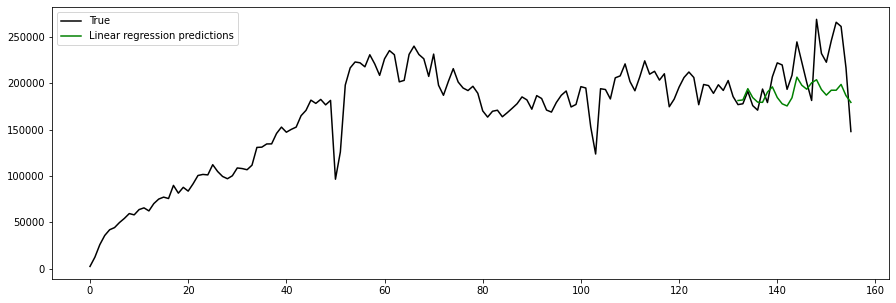

In [90]:
# Treinando novamente a regressão linear

best_index = 107

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(df_grouped['net_revenue'], color='black', label='True')
plt.legend()
plt.plot(pd.DataFrame(y_pred, index=X_test.index), color='green', label='Linear regression predictions')
plt.legend();

In [91]:
# Saving final model

#pickle.dump(model, open('linear_regression_model.pkl', 'wb'))

# 7.0 Error interpretation

## <font color="gray"> 7.1 Main </font>

Com o modelo selecionado e baseado nos erros em suas estimativas é possível fazer algumas avaliações.

Utilizando o erro MAPE foram então calculado valores inferiores (lower limit) e superiores (upper limit) para cada predição no conjunto de testes. Com base nesses limites foram então estabelecidos os valores pessimistas e otimistas para as respectivas previsões. Uma vez que a demanda do problema é uma previsão para 6 meses então foram criadas mais duas colunas contendo a soma dos valores estimados de net_revenue para os próximos 6 meses considerando expectativas pessimistas (quando o modelo erra para baixo) e expectativas otimistas (quando o modelo erra para cima). É possível observar que num cenário otimista a soma de net_revenue para os próximos 6 meses alcança o valor de 5.105.888 enquanto que em um cenário pessimista a soma alcança 3.977.452.

Além disso, se considerarmos o erro MAPE em termos de soma das previsões de net_revenue para os próximos 6 meses é possível notar que o erro cai para 0.096521 quando comparado ao modelo concebido para a previsão semanal onde o MAPE alcançou 0.124231, dessa forma o erro é menor para estimar o net_revenue acumulado de 6 meses do que o net_revenue acumulado semanal.



O modelo também foi avaliado na questão dos resíduos gerados pelos seus erros.

O código abaixo mostra as avaliações feitas:

In [92]:
# Treinando novamente a regressão linear

best_index = 107

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)


# storing true values and forecasted values
df_true_x_predictions = pd.DataFrame({'true':y_test, 'predictions':y_pred.astype('int')})

#calculating residuals
df_true_x_predictions['residuals'] = df_true_x_predictions['true'] - df_true_x_predictions['predictions']

#calculating 'upper_limit' and 'lower_limit' based o MAPE
df_true_x_predictions['upper_limit'] = (df_true_x_predictions['predictions'] + df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

df_true_x_predictions['lower_limit'] = (df_true_x_predictions['predictions'] - df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

# creating '6_month_best_scenario'
df_true_x_predictions['6_month_best_scenario'] = df_true_x_predictions['upper_limit'].sum()

# creating '6_month_worst_scenario'
df_true_x_predictions['6_worst_best_scenario'] = df_true_x_predictions['lower_limit'].sum()

# creating '6_month_true'
df_true_x_predictions['6_month_true'] = df_true_x_predictions['true'].sum()

# creating '6_month_predicted'
df_true_x_predictions['6_month_predicted'] = df_true_x_predictions['predictions'].sum()

# MAPE
df_true_x_predictions['6_month_mape'] = mean_absolute_percentage_error(df_true_x_predictions['6_month_true'], df_true_x_predictions['6_month_predicted'])

In [93]:
# Treinando novamente a regressão linear

best_index = 107

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)


# storing true values and forecasted values
df_true_x_predictions = pd.DataFrame({'true':y_test, 'predictions':y_pred.astype('int')})

#calculating residuals
df_true_x_predictions['residuals'] = df_true_x_predictions['true'] - df_true_x_predictions['predictions']

#calculating 'upper_limit' and 'lower_limit' based o MAPE
df_true_x_predictions['upper_limit'] = (df_true_x_predictions['predictions'] + df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

df_true_x_predictions['lower_limit'] = (df_true_x_predictions['predictions'] - df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

In [94]:
df_true_x_predictions.head()

,true,predictions,residuals,upper_limit,lower_limit
132,176928,181338,-4410,203865,158810
133,177844,181984,-4140,204592,159375
134,191343,194123,-2780,218239,170006
135,175846,184522,-8676,207445,161598
136,170926,179604,-8678,201916,157291


A figura abaixo mostra uma avaliação mais técnica do modelo em si. A análise foi feita observando a concordância entre as previsões do modelo com o valor real. Também foi feita uma análise de resíduos para observar tendências do modelo tanto com relação ao valor absoluto de net_revenue tanto com relação ao acrescimo de semanas. Observando os plots de resíduos fica clara a necessidade de realizar melhorias no modelo de forma a tornar os pontos mais dispersos no gráfico uma vez que a figura sugere que o modelo erra mais a media que os valores de net_revenue aumentam; o mesmo é observado com o aumento progressivo na quantidade de semanas.

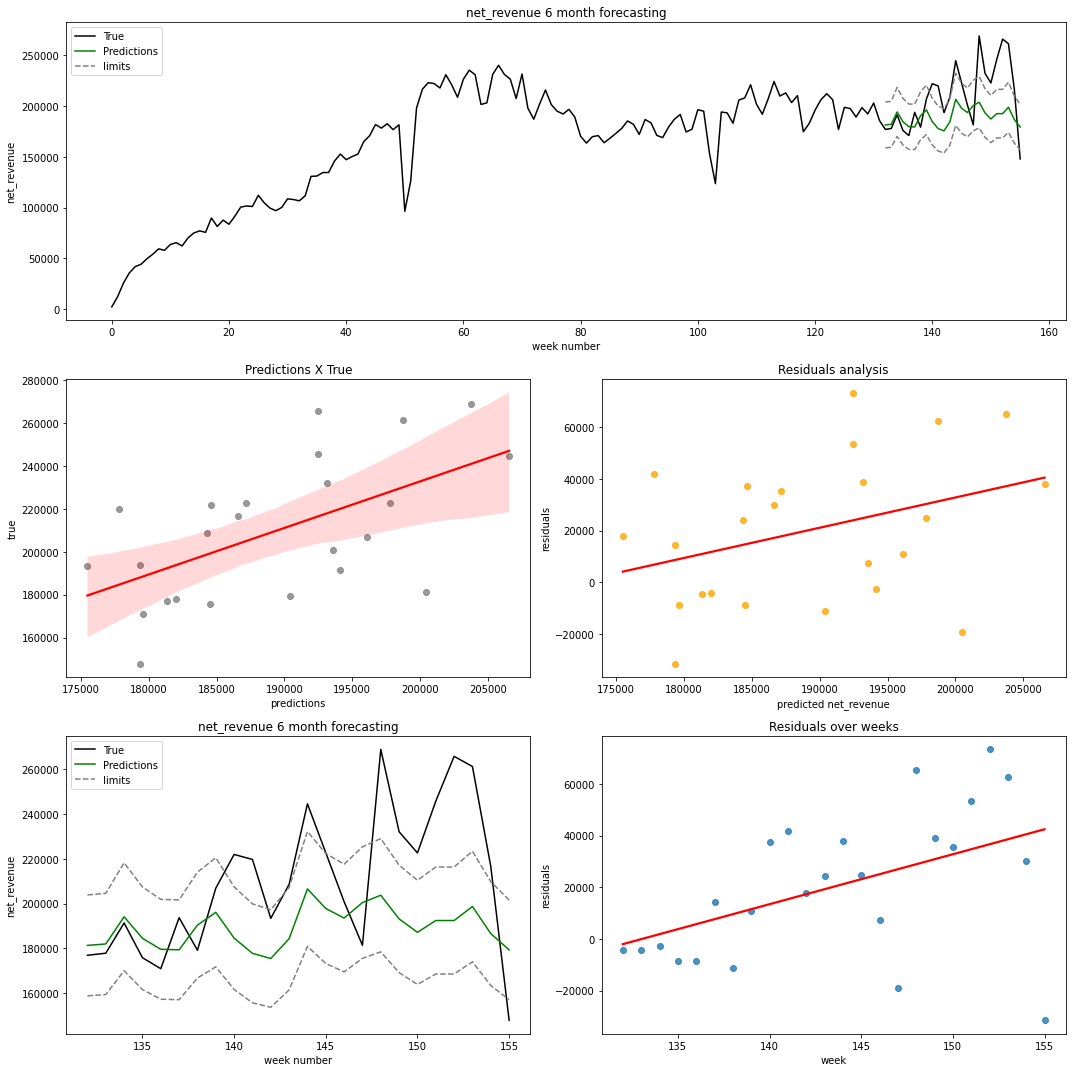

In [95]:
plt.figure(figsize=(15,15))


plt.subplot(3,1,1)
plt.plot(df_grouped['net_revenue'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,3)
sns.regplot(x='predictions', y='true', data=df_true_x_predictions,
            scatter_kws={"color": "grey"}, line_kws={"color": "red"})
plt.title('Predictions X True')


plt.subplot(3,2,4)
sns.regplot(x='predictions',y='residuals',data=df_true_x_predictions, ci=False,
            scatter_kws={"color": "orange"}, line_kws={"color": "red"})
plt.xlabel('predicted net_revenue')
plt.title('Residuals analysis')


plt.subplot(3,2,5)
plt.plot(df_true_x_predictions['true'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,6)
sns.regplot(x='index',y='residuals',data=df_true_x_predictions.reset_index(), ci=False, line_kws={"color": "red"})
plt.title('Residuals over weeks')
plt.xlabel('week')

plt.tight_layout();

# 8.0 Deploy

Para finalizar a primeira versão da solução proposta, o encerremento sera feito colocando o modelo treinado em produção. Embora ainda hajam pontos de melhoria, é importante gerar valor de uma maneira rápida em um intervalo curto de tempo. Além disso, com a primeira versão estruturada, os testes posteriores visando melhorias tendem a ser mais rápidos.

Para completar o deploy da solução o seguinte passo-a-passo será obedecido:

- Criar uma classe que contém os métodos de coleta e limpeza dos dados, feature engineering e predição.


- Criar uma API que será responsável por receber o dado bruto no formato json, importar a classe descrita acima e retornar os dados brutos e mais a previsão de net_revenue na forma de json.


- Colocar a API em um ambiente de núvem e expor um endpoint para requisições feitas a partir de quaisquer localidades, softwares e ferramentas.


Será considerado como dado de produção o dado separado como teste, contendo apenas as colunas 'year' e 'week' como exemplificado abaixo.

In [2]:
# Exemplo de dado de produção

print('Exemplo de dado de produção:')

df = pd.DataFrame({'year':2015, 'week':'W48'} ,index=[0])

df

Exemplo de dado de produção:


,year,week
0,2015,W48


## <font color="gray"> 10.1 Class data_prep.py </font>

In [332]:
import pickle
import pandas as pd
import numpy as np
import json
from math import floor




class Data_prep(object):
    
    def __init__(self):
        pass

        
    
    
    def feature_engineering(self, df):
        
        
        # Renaming 'week' column to 'week_of_year'
        
        df = df[['year', 'week']]
        
        df.columns = ['year', 'week_of_year']
        
        
        # creating 'week_of_year' columns
        df['week_of_year'] = df['week_of_year'].apply(lambda x: x.split('W')[1])
        
        
        # changing 'week_of_year' data type
        df['week_of_year'] = df['week_of_year'].astype('int')
        
        
        # reorganizing columns order
        df = df[['year','week_of_year']]
        
        
        
        # Creating 'semester_of_year' column
        
        df['semester_of_year'] =  [1 if i <26 else 2 for i in df['week_of_year']]
        
        
        
        # Creating 'month_of_year' column
        
        df['month_of_year'] = np.nan
        
        
        # Filling month of year
        
        for i in df['year']:
            
        
            if i==2013:
                    
        
                # 2013
                
                df.loc[df['year']==2013, 'month_of_year']  = [1 if it<= 5
                                                                  else 2 if 6<=it<=9
                                                                  else 3 if 10<=it<=13
                                                                  else 4 if 14<=it<=18
                                                                  else 5 if 19<=it<=22
                                                                  else 6 if 23<=it<=26
                                                                  else 7 if 27<=it<=31
                                                                  else 8 if 32<=it<=35
                                                                  else 9 if 36<=it<=40
                                                                  else 10 if 41<=it<=44
                                                                  else 11 if 45<=it<=48
                                                                  else 12 for it in df.loc[df['year']==2013, 'week_of_year'] ]
                
                
            elif i==2014:   
        
        
                # 2014
                
                df.loc[df['year']==2014, 'month_of_year']  = [1 if it<= 5
                                                                  else 2 if 6<=it<=9
                                                                  else 3 if 10<=it<=14
                                                                  else 4 if 15<=it<=18
                                                                  else 5 if 19<=it<=22
                                                                  else 6 if 23<=it<=27
                                                                  else 7 if 28<=it<=31
                                                                  else 8 if 32<=it<=35
                                                                  else 9 if 36<=it<=40
                                                                  else 10 if 41<=it<=44
                                                                  else 11 if 45<=it<=48
                                                                  else 12 for it in df.loc[df['year']==2014, 'week_of_year'] ]
                
            elif i==2015:
                
                
                # 2015
                
                df.loc[df['year']==2015, 'month_of_year']  = [1 if it<= 5
                                                                  else 2 if 6<=it<=9
                                                                  else 3 if 10<=it<=14
                                                                  else 4 if 15<=it<=18
                                                                  else 5 if 19<=it<=22
                                                                  else 6 if 23<=it<=27
                                                                  else 7 if 28<=it<=31
                                                                  else 8 if 32<=it<=36
                                                                  else 9 if 37<=it<=40
                                                                  else 10 if 41<=it<=44
                                                                  else 11 if 45<=it<=49
                                                                  else 12 for it in df.loc[df['year']==2015, 'week_of_year'] ]
                
        
                
        # changing 'month_of_year' data type
        
        df['month_of_year'] = df['month_of_year'].astype('int')
        
        
        
        # Creating 'quarter_of_the_year' column (trimestre)
        
        df['quarter'] = [1 if i<= 3
                          else 2 if 4<=i<=6
                          else 3 if 7<=i<=9
                          else 4  for i in df['month_of_year']]
        
        
        
        
        # Creating 'week_of_month' column
        
        df['week_of_month'] = np.nan
        
        
        # filling the column:
        
        
        # Filling week_of_month
        
        for i in df['year']:
            
        
            if i==2013:
                    
        
                # 2013
                
                df.loc[df['year']==2013, 'week_of_month']  = [1 if it in          [1, 6, 10, 14, 19, 23, 27, 32, 36, 41, 45, 49]
                                                                  else 2 if it in [2, 7, 11, 15, 20, 24, 28, 33, 37, 42, 46, 50]
                                                                  else 3 if it in [3, 8, 12, 16, 21, 25, 29, 34, 38, 43, 47, 51]
                                                                  else 4 if it in [4, 9, 13, 17, 22, 26, 30, 35, 39, 44, 48, 52]
                                                                  else 5 for it in df.loc[df['year']==2013, 'week_of_year'] ]
                
                
            if i==2014:
                    
        
                # 2014
                
                df.loc[df['year']==2014, 'week_of_month']  = [1 if it in       [1, 6, 10, 15, 19, 23, 28, 32, 36, 41, 45, 49]
                                                                  else 2 if it in [2, 7, 11, 16, 20, 24, 29, 33, 37, 42, 46, 50]
                                                                  else 3 if it in [3, 8, 12, 17, 21, 25, 30, 34, 38, 43, 47, 51]
                                                                  else 4 if it in [4, 9, 13, 18, 22, 26, 31, 35, 39, 44, 48, 52]
                                                                  else 5 for it in df.loc[df['year']==2014, 'week_of_year'] ]        
                
                
                
                
                
            if i==2015:
                    
        
                # 2015
                
                df.loc[df['year']==2015, 'week_of_month']  = [1 if it in       [1, 6, 10, 15, 19, 23, 28, 32, 37, 41, 45, 50]
                                                                  else 2 if it in [2, 7, 11, 16, 20, 24, 29, 33, 38, 42, 46, 51]
                                                                  else 3 if it in [3, 8, 12, 17, 21, 25, 30, 34, 39, 43, 47, 52]
                                                                  else 4 if it in [4, 9, 13, 18, 22, 26, 31, 35, 40, 44, 48, 53]
                                                                  else 5 for it in df.loc[df['year']==2015, 'week_of_year'] ]  
                    
        
        
        # changing 'week_of_month' data type
        
        df['week_of_month'] = df['week_of_month'].astype('int')
        
        
        
        
        # Organizar o dataset cronologicamente (importante para problemas de previsão)
        
        df = df.sort_values(by=['year','week_of_year'])
        
        
        
                
        
        # Reorganizar as colunas para as próximas etapas
        
        df = df[['year',
                 'month_of_year',
                 'week_of_month',
                 'week_of_year',
                 'quarter',
                 'semester_of_year']]
                
        
            
        # Uma vez que as variáveis de data já foi desmembrada em novas features, remover a coluna 'year'
        
        df = df.drop(columns=['year'])
        
        
        return df
    
    
    
    
    def data_preparation(self, df_3):
        
        X_test = df_3
        
        
        # Scaling month_of_year

        X_test['month_of_year_sin'] = X_test['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        X_test['month_of_year_cos'] = X_test['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        
     
       
        # Scaling quarter

        X_test['quarter_sin'] = X_test['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        X_test['quarter_cos'] = X_test['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        
       
        
        
        # Scaling week_of_month

        X_test['week_of_month_sin'] = X_test['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        X_test['week_of_month_cos'] = X_test['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        
        
        
        
        # Scaling week_of_year

        X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        
      
        
        
    
    
        # Mantendo apenas as colunas codificadas 
        
        X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                           'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]
            
    

    
        # 'semester_of_year' - dummies
        
        X_test['semester_of_year_1'] = X_test['semester_of_year'].apply(lambda x: 1 if x==1 else 0)
        
        X_test['semester_of_year_2'] = X_test['semester_of_year'].apply(lambda x: 1 if x==2 else 0)
        
        
        # removing original column
        X_test = X_test.drop(columns=['semester_of_year'])    
            
    
        # reorganizando a ordem das colunas
        X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin',
                         'week_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'quarter_sin', 'quarter_cos', 'semester_of_year_1',
                         'semester_of_year_2']]
        
        
        return X_test
        
        
        
            
    def get_predictions(self, model, test_raw, df_3):
        
        # prediction
        predictions = model.predict(df_3)
        
        # join predictions into the original data
        test_raw.loc[test_raw.index, 'prediction'] = [floor(i) for i in predictions]
        
        test_raw['prediction'] = test_raw['prediction'].astype(int)
        
        
        
        return test_raw.to_json(orient='records', date_format='iso')    

## <font color="gray"> 10.2 API_handler.py </font>

In [3]:
# Library imports

import pandas as pd
import pickle
from flask import Flask, request, Response
import json
from Data_prep_class.Data_prep import Data_prep



# Loading model
model = pickle.load(open('linear_regression_model.pkl', 'rb')) # Opening scaler


# initialize API
app = Flask(__name__)

# criando o endpoint (url que receberá os dados):
@app.route( '/net-revenue-forecaster/predict', methods=['POST'] )


# Whenever after receiving a call, the endpoint executes some function. For this case, it will always 
## execute the function after receiving a call, the endpoint executes some function.


def netrevenueforecaster_predict():
    test_json = request.get_json() # the request data will come as json format.
    
   
    if test_json: # there is data
        test_json = json.loads(test_json)
        
        if isinstance( test_json, dict ): #test if the data is a request of only 1 row (will come as dict)
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # otherwise the request will be in the form of a list (with each item being a dictionary):
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        
        # Instantiate Rossmann class
        pipeline = Data_prep()
        
        # feature engineering
        df2 = pipeline.feature_engineering( test_raw )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_predictions( model, test_raw, df3 )
        
        return df_response


    else: # if there is no data
        return Response( '{}', status=200, mimetype='application/json' )
    
    

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    #      (local host)    

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://10.95.42.133:5000/ (Press CTRL+C to quit)


## <font color="gray"> 10.3 API tester local </font>

In [6]:
# Loading test set

X_test = pd.read_csv('X_test_production.csv', index_col=0)

X_test.head()

,year,week
132,2015,W29
133,2015,W30
134,2015,W31
135,2015,W32
136,2015,W33


In [7]:
# Converting X_test_sampled to json

data_json = X_test.to_json(orient='records', date_format='iso')



# API Call =====================================================================================

# For the call to work the local server has to be active (terminal: python API_handler.py)
# If the result of executing this cell is 200, the request worked

url = 'http://0.0.0.0:5000/net-revenue-forecaster/predict' #endpoint (where the data will be sent.0.0.0.0 means it is a local host not connected to the internet. Port 5000 is Flask's default)

header = {'Content-type':'application/json'} #indicates to the API what type of request is being made





# Making the request

response = requests.post(url=url, headers=header, json=data_json)

print('Status Code: {}'.format(response.status_code))

Status Code: 200


In [8]:
df_predictions = pd.DataFrame(response.json(), columns=response.json()[0].keys())

df_predictions

,year,week,prediction
0,2015,W29,181338
1,2015,W30,181984
2,2015,W31,194123
3,2015,W32,184522
4,2015,W33,179604
5,2015,W34,179364
6,2015,W35,190413
7,2015,W36,196101
8,2015,W37,184600
9,2015,W38,177789


## <font color="gray"> 10.4 API tester remote/cloud </font>

In [11]:
import pandas as pd

# Loading test set

X_test = pd.read_csv('X_test_production.csv', index_col=0)

X_test.head()

,year,week
132,2015,W29
133,2015,W30
134,2015,W31
135,2015,W32
136,2015,W33


In [12]:
import requests

# Converting X_test_sampled to json

data_json = X_test.to_json(orient='records', date_format='iso')



# API Call =====================================================================================

# For the call to work the local server has to be active (terminal: python API_handler.py)
# If the result of executing this cell is 200, the request worked

url = 'https://net-revenue-forecaster.herokuapp.com/net-revenue-forecaster/predict' #endpoint (where the data will be sent.0.0.0.0 means it is a local host not connected to the internet. Port 5000 is Flask's default)

header = {'Content-type':'application/json'} #indicates to the API what type of request is being made





# Making the request

response = requests.post(url=url, headers=header, json=data_json)

print('Status Code: {}'.format(response.status_code))

Status Code: 200


In [13]:
df_predictions = pd.DataFrame(response.json(), columns=response.json()[0].keys())

df_predictions

,year,week,prediction
0,2015,W29,181338
1,2015,W30,181984
2,2015,W31,194123
3,2015,W32,184522
4,2015,W33,179604
5,2015,W34,179364
6,2015,W35,190413
7,2015,W36,196101
8,2015,W37,184600
9,2015,W38,177789


## <font color="gray"> 10.5 Deploy in Google Sheets </font>

Com o modelo disponível em um servidor em núvel para requisições é possível o acesso as predições à partir de quaisquer localidades, softwares e ferramentas. Um exemplo prático de disponibilização das predições para a equipe não técnica é mostrado no exemplo abaixo.

Nele podemos ver uma planilha do Google Sheets contendo os dados de produção em três colunas, uma dela o ano, a outra a semana e por fim a coluna  de previções de net revenue. Nela foi criada um botão chamado 'Forecasting' contendo a função 'Get predictions' onde os dados são coletados e a requisição do resultado da predição é realizada no modelo hospedado no servior em nuvem. Em poucos instantes é possível observar a estimativa de net_revenue para cado um dos exemplos de cada linha.

A figura abaixo mostra a planilha e o botão correspondente.

<img src="https://drive.google.com/uc?export=view&id=1geKOk_MCm3D5KnPpsbYKwgNfUbE-BZju" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" /> 

Após clicar no botão de predições os dados são então enviados para o modelo hospedado no servidor em nuvem. Isso leva poucos instantes.

<img src="https://drive.google.com/uc?export=view&id=1_x3fG4TXQEfzHKyWcBSOdzcwLjYNni06" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" /> 

Após a conclusão do processo é possível então visualizar o resultado das predições de net_revenue:

<img src="https://drive.google.com/uc?export=view&id=1r3tRaGYDYjBUmRIRfi5rfwyB9wcoPAq2" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" /> 

# <font color="green"> Relatório final, conclusões e pontos de melhora </font>

Nesse notebook foi proposto um passo-a-passo para propor uma primeira versão de uma solução de previsão de net_revenue utilizando técnicas e princícipios utilizados em projetos de ciência de dados. É importante destacar que o planejamento da execução de cada uma das etapas foi feita baseada no prazo disponibilizado para a entrega da solução, dessa forma existe margem para melhorias incrementais em cada uma das etapas dentro do fluxo proposto e essas melhorias podem impactar positivamente o desempenho do modelo estimador de net_revenue.

Para a projeção de net_revenue para os próximos 6 meses foram utilizadas técnicas de machine learning, desde as mais simples e intuitivas como a regressão linear, e aumentando a complexidade com Random Forest e Redes Neurais. Também foi utilizada a técnica estatística ARIMA. A primeira avaliação apontou para o ARIMA como a melhor abordagem, entretanto em uma segunda etapa de otimização decidiu-se prosseguir apenas com as técnicas multivariadas (as vantagens da utilização de técnicas de machine learning serão abordadas abaixo) onde Random Forest teve o melhor desempenho e Regressão Linear teve um desempenho similar. Devido a simplicidade, intuitividade e interpretabilidade da regressão linear decidiu-se então usar essa técnica para dar prosseguimento ao desenvolvimento da solução.


Com relação as melhorias que podem ser feitas neste projeto, seguem sugestões que podem ser implementadas em etapas futuras, no âmbito técnico:

- O conjunto de dados disponível exerce uma influência importante sobre o desempenho do modelo. É necessário ter tanto exemplos o bastante quanto variáveis descritoras que sejam capazes de descrever a relação dos dados com a variável que se deseja estimar. No âmbito dos dados dispóníveis, durante o desenvolvimento do projeto buscou-se enriquecer o conjunto de dados na etapa de feature engineering criando-se variáveis derivadas da semana do ano (week). Essa abordagem pode ser extendida considerando eventos que tenham um significado dentro do contexto de atuação do negócio e a partir desses eventos criar-se novas variáveis, como por exemplo feriado (sim ou não), dias até o próximo feriado (numérico), promoção (sim ou não), ticket de desconto (sim ou não) dias até a próxima promoção (numérico), estação do ano (categórico) seja no hemisfério norte ou sul dependendo de onde o negócio atua. Dessa forma essas novas variáveis podem, individualmente ou em conjunto auxiliar na obtenção de melhores resultados ao estimar net_revenue. Além disso, também poder ser criadas variáveis matematicamente como variáveis polinomiais, incluindo interações entre variáveis (e.g. x1 * x2, x1² · x2³ ) e transformações não lineares de variáveis(e.g log X, raiz quadrada de x, 1/x, X², exp(x), etc) que podem auxiliar a expôr a relação das variáveis preditoras com a variável alvo.


- Com diversas novas variáveis criadas é então possível selecionar alguma técnica de seleção de variáveis que escolheria dentre o novo conjunto de variáveis criadas (e também as já existentes) qual a combinação que melhor ajuda o modelo a diminuir os erros. Essa estratégia usualmente retorna bons resultados.


- A importância da relação entre a criação de novas variáveis com a estimação de net_revenue acima mencionada também justifica a escolhe de técnicas de machine learning ao invés de métodos estatísticos, como por exemplo o ARIMA. Uma vez que o machine learning utiliza a informação de diferentes variáveis para estimar um alvo, é possível então estimar a relevância de cada variável no resultado observado, e uma vez que, em um caso hipotético, uma previsão retorne o resultado abaixo do que se planeja é possível então "testar" valores para essas variáveis e avaliar os efeitos na previsão (as "alavancas de negócio"), enquanto que o ARIMA isso não é possível por ele só usa o valor da variável resposta na modelagem. Além disso, também existe a oportunidade de projetos de machine learning utilizando algoritmos de otimização, buscando quais valores para um determinado conjunto de variáveis maximizam um resultado esperado.


- Considerando que a criação e a seleção das novas variáveis impactou consideravelmente o desempenho do modelo, outros ajustes finos podem ser feitos para obter melhoras incrementais. Um deles seria a transformação matemática na variável alvo; dependendo do caso isso pode resultar em uma melhora no modelo, embora essa melhora usualmente seja inferior comparada a melhora que o feature engineering pode proporcionar. O mesmo vale para o ajuste fino de hiperparâmetros, a depender do modelo escolhido.


- Outro teste que pode ser aplicado seria, substituir o modelo de rede neural MLP (multi layer perceptron) testado nessa versão da solução por um modelo de rede neural LSTM (long short term memory) mais adequado para séries temporais. Entretando modelos de redes neurais exigem muitos exemplos para serem treinados, enquanto que o dataset disponibilizado contém menos de 200 exemplos para o treinamento.


- Com a primeira solução implementada, nas próximas versões os trechos de código mais comumente repetidos (e.g. testes de modelos) podem ser substituídos por funções, deixando o código mais resumido.


- Métricas de erro customizadas podem ser criadas para penalizar mais o modelo quando ele erra mais para valores superiores ao valor real ou para valores inferiores ao valor real. A depender do contexto no negócio a aplicação dessa abordagem pode ser útil.
